In [1]:
import os
from IPython.display import display
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
# from preprocessing import load_data
# from ydata_profiling import ProfileReport
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
# df = load_data(file_path='../data/dataset.csv')
PATH = os.getcwd()
df = pd.read_csv(os.path.join(PATH, "data/enriched_synthetic_data.csv"))
# df.drop(["music_id"], axis=1, inplace=True)
df.head()

user_id  age        education gender      country           music  \
0    83811   16   Undergraduate       F       Urban     Bank Account   
1    83811   16   Undergraduate       F       Urban     Little Talks   
2    13397   17   Middle School       M   Non-Urban    Wherever I Go   
3    70645   44        Graduate       M   Non-Urban   No New Friends   
4    70645   44        Graduate       M   Non-Urban           Dreams   

           artist_name                       featured_artists      genre  \
0            21 Savage                             Birdy, Zoé  Dark Trap   
1  Of Monsters and Men      Ninho, Snoop Dogg, Russ, Paramore        NaN   
2          OneRepublic  Keith Urban, DJ Khaled, NIKI, MF DOOM        NaN   
3            DJ Khaled                     The xx, LIT killah        Pop   
4       Campsite Dream                                    NaN    Country   

   plays  ...  loudness mode speechiness  instrumentalness  liveness  \
0     11  ... -8.228000    0    0.351000          0.000007  0.087100   
1    686  ... -7.879000    1    0.032200          0.000000  0.284500   
2    136  ... -7.344833    1    0.089400          0.043432  0.273133   
3    230  ... -7.606000    1    0.167000          0.000000  0.096600   
4    391  ... -9.894632    1    0.078837          0.235527  0.180354   

    valence       tempo  time_signature  release_date  explicit  
0  0.376000   75.016000             4.0    2017-09-23      True  
1  0.413000  101.890500             4.0    2013-04-12     False  
2  0.404183  120.850500             4.0    2009-02-03     False  
3  0.400000  109.283000             4.0    2017-01-01     False  
4  0.380815  120.488479             4.0          1974     False  

[5 rows x 27 columns]

In [3]:
# drop unused columns
df.drop(["education","country"], axis=1, inplace=True)

In [4]:
print(df.shape)  # prints the dimensions of the DataFrame

(19974, 25)


In [5]:
df.columns

Index(['user_id', 'age', 'gender', 'music', 'artist_name', 'featured_artists',
       'genre', 'plays', 'duration', 'music_id', 'id_artists', 'acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'release_date', 'explicit'],
      dtype='object')

In [6]:
# Define presets for data visualization
def presets():
    plt.rc('figure', autolayout = True)

    plt.rc('axes',
        labelsize = 'large',
        labelweight = 'bold',
        titlesize = 14,
        titleweight = 'bold',
        titlepad = 10
    )

    %config InlineBackend.figure_format = 'retina'
    pd.options.display.max_rows = 10
    sns.set_style('darkgrid')
    # Set preset for darkmode for matplotlib and seaborn visualizations
    plt.style.use('dark_background')

    warnings.filterwarnings(action = 'ignore', category = UserWarning)
    return

presets()



In [7]:
df.info(memory_usage="deep")  # prints the memory usage of the DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19974 entries, 0 to 19973
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           19974 non-null  int64  
 1   age               19974 non-null  int64  
 2   gender            19974 non-null  object 
 3   music             19974 non-null  object 
 4   artist_name       19974 non-null  object 
 5   featured_artists  9618 non-null   object 
 6   genre             17450 non-null  object 
 7   plays             19974 non-null  int64  
 8   duration          19974 non-null  float64
 9   music_id          19974 non-null  object 
 10  id_artists        19974 non-null  object 
 11  acousticness      19974 non-null  float64
 12  danceability      19974 non-null  float64
 13  energy            19974 non-null  float64
 14  key               19974 non-null  int64  
 15  loudness          19974 non-null  float64
 16  mode              19974 non-null  int64 

In [8]:
df['release_date'] .value_counts()

release_date
1996          183
2000          181
1972          172
1997          166
1995          165
             ... 
1998-05-01      1
2007-11-08      1
2012-05-19      1
2011-12-27      1
2017-03-22      1
Name: count, Length: 3402, dtype: int64

In [9]:
# df.shape
df.describe(include="all")  # prints the summary statistics of the DataFrame

user_id           age gender   music artist_name  \
count   19974.000000  19974.000000  19974   19974       19974   
unique           NaN           NaN      2    9470        5085   
top              NaN           NaN      M  Closer       Drake   
freq             NaN           NaN  10000      49         271   
mean    49680.999149     35.925253    NaN     NaN         NaN   
...              ...           ...    ...     ...         ...   
min         4.000000     13.000000    NaN     NaN         NaN   
25%     24543.250000     18.000000    NaN     NaN         NaN   
50%     49514.000000     30.000000    NaN     NaN         NaN   
75%     74545.750000     52.000000    NaN     NaN         NaN   
max     99998.000000     80.000000    NaN     NaN         NaN   

       featured_artists       genre         plays     duration  \
count              9618       17450  19974.000000  19974.00000   
unique             8585          38           NaN          NaN   
top       Miracle Tones   Classical           NaN          NaN   
freq                  7        1479           NaN          NaN   
mean                NaN         NaN    384.862972      3.87686   
...                 ...         ...           ...          ...   
min                 NaN         NaN      1.000000      0.00000   
25%                 NaN         NaN      1.000000      3.33000   
50%                 NaN         NaN    225.000000      3.75000   
75%                 NaN         NaN    660.000000      4.28000   
max                 NaN         NaN   3002.000000     19.93000   

                      music_id  ...      loudness          mode   speechiness  \
count                    19974  ...  19974.000000  19974.000000  19974.000000   
unique                   11528  ...           NaN           NaN           NaN   
top     7BKLCZ1jbUBVqRi2FVlTVw  ...           NaN           NaN           NaN   
freq                        33  ...           NaN           NaN           NaN   
mean                       NaN  ...     -8.805136      0.729749      0.085706   
...                        ...  ...           ...           ...           ...   
min                        NaN  ...    -37.796000      0.000000      0.000000   
25%                        NaN  ...    -10.082778      0.000000      0.043182   
50%                        NaN  ...     -8.465000      1.000000      0.063075   
75%                        NaN  ...     -7.064333      1.000000      0.096595   
max                        NaN  ...      1.399000      1.000000      0.954000   

        instrumentalness      liveness       valence         tempo  \
count       19974.000000  19974.000000  19974.000000  19974.000000   
unique               NaN           NaN           NaN           NaN   
top                  NaN           NaN           NaN           NaN   
freq                 NaN           NaN           NaN           NaN   
mean            0.156571      0.186839      0.477929    121.014846   
...                  ...           ...           ...           ...   
min             0.000000      0.009360      0.000000      0.000000   
25%             0.000445      0.126085      0.367500    111.692446   
50%             0.100860      0.170092      0.464207    120.628039   
75%             0.229892      0.215405      0.579846    129.374425   
max             0.981000      0.995000      0.981000    212.070000   

        time_signature  release_date  explicit  
count     19974.000000         19974     19974  
unique             NaN          3402         2  
top                NaN          1996     False  
freq               NaN           183     18710  
mean          3.944878           NaN       NaN  
...                ...           ...       ...  
min           0.000000           NaN       NaN  
25%           4.000000           NaN       NaN  
50%           4.000000           NaN       NaN  
75%           4.000000           NaN       NaN  
max           5.000000           NaN       NaN  

[11 rows x 25 columns]

In [10]:
profile = ProfileReport(
    df, title="EDA Report", explorative=True
)  # generates a profile report of the DataFrame

NameError: name 'ProfileReport' is not defined

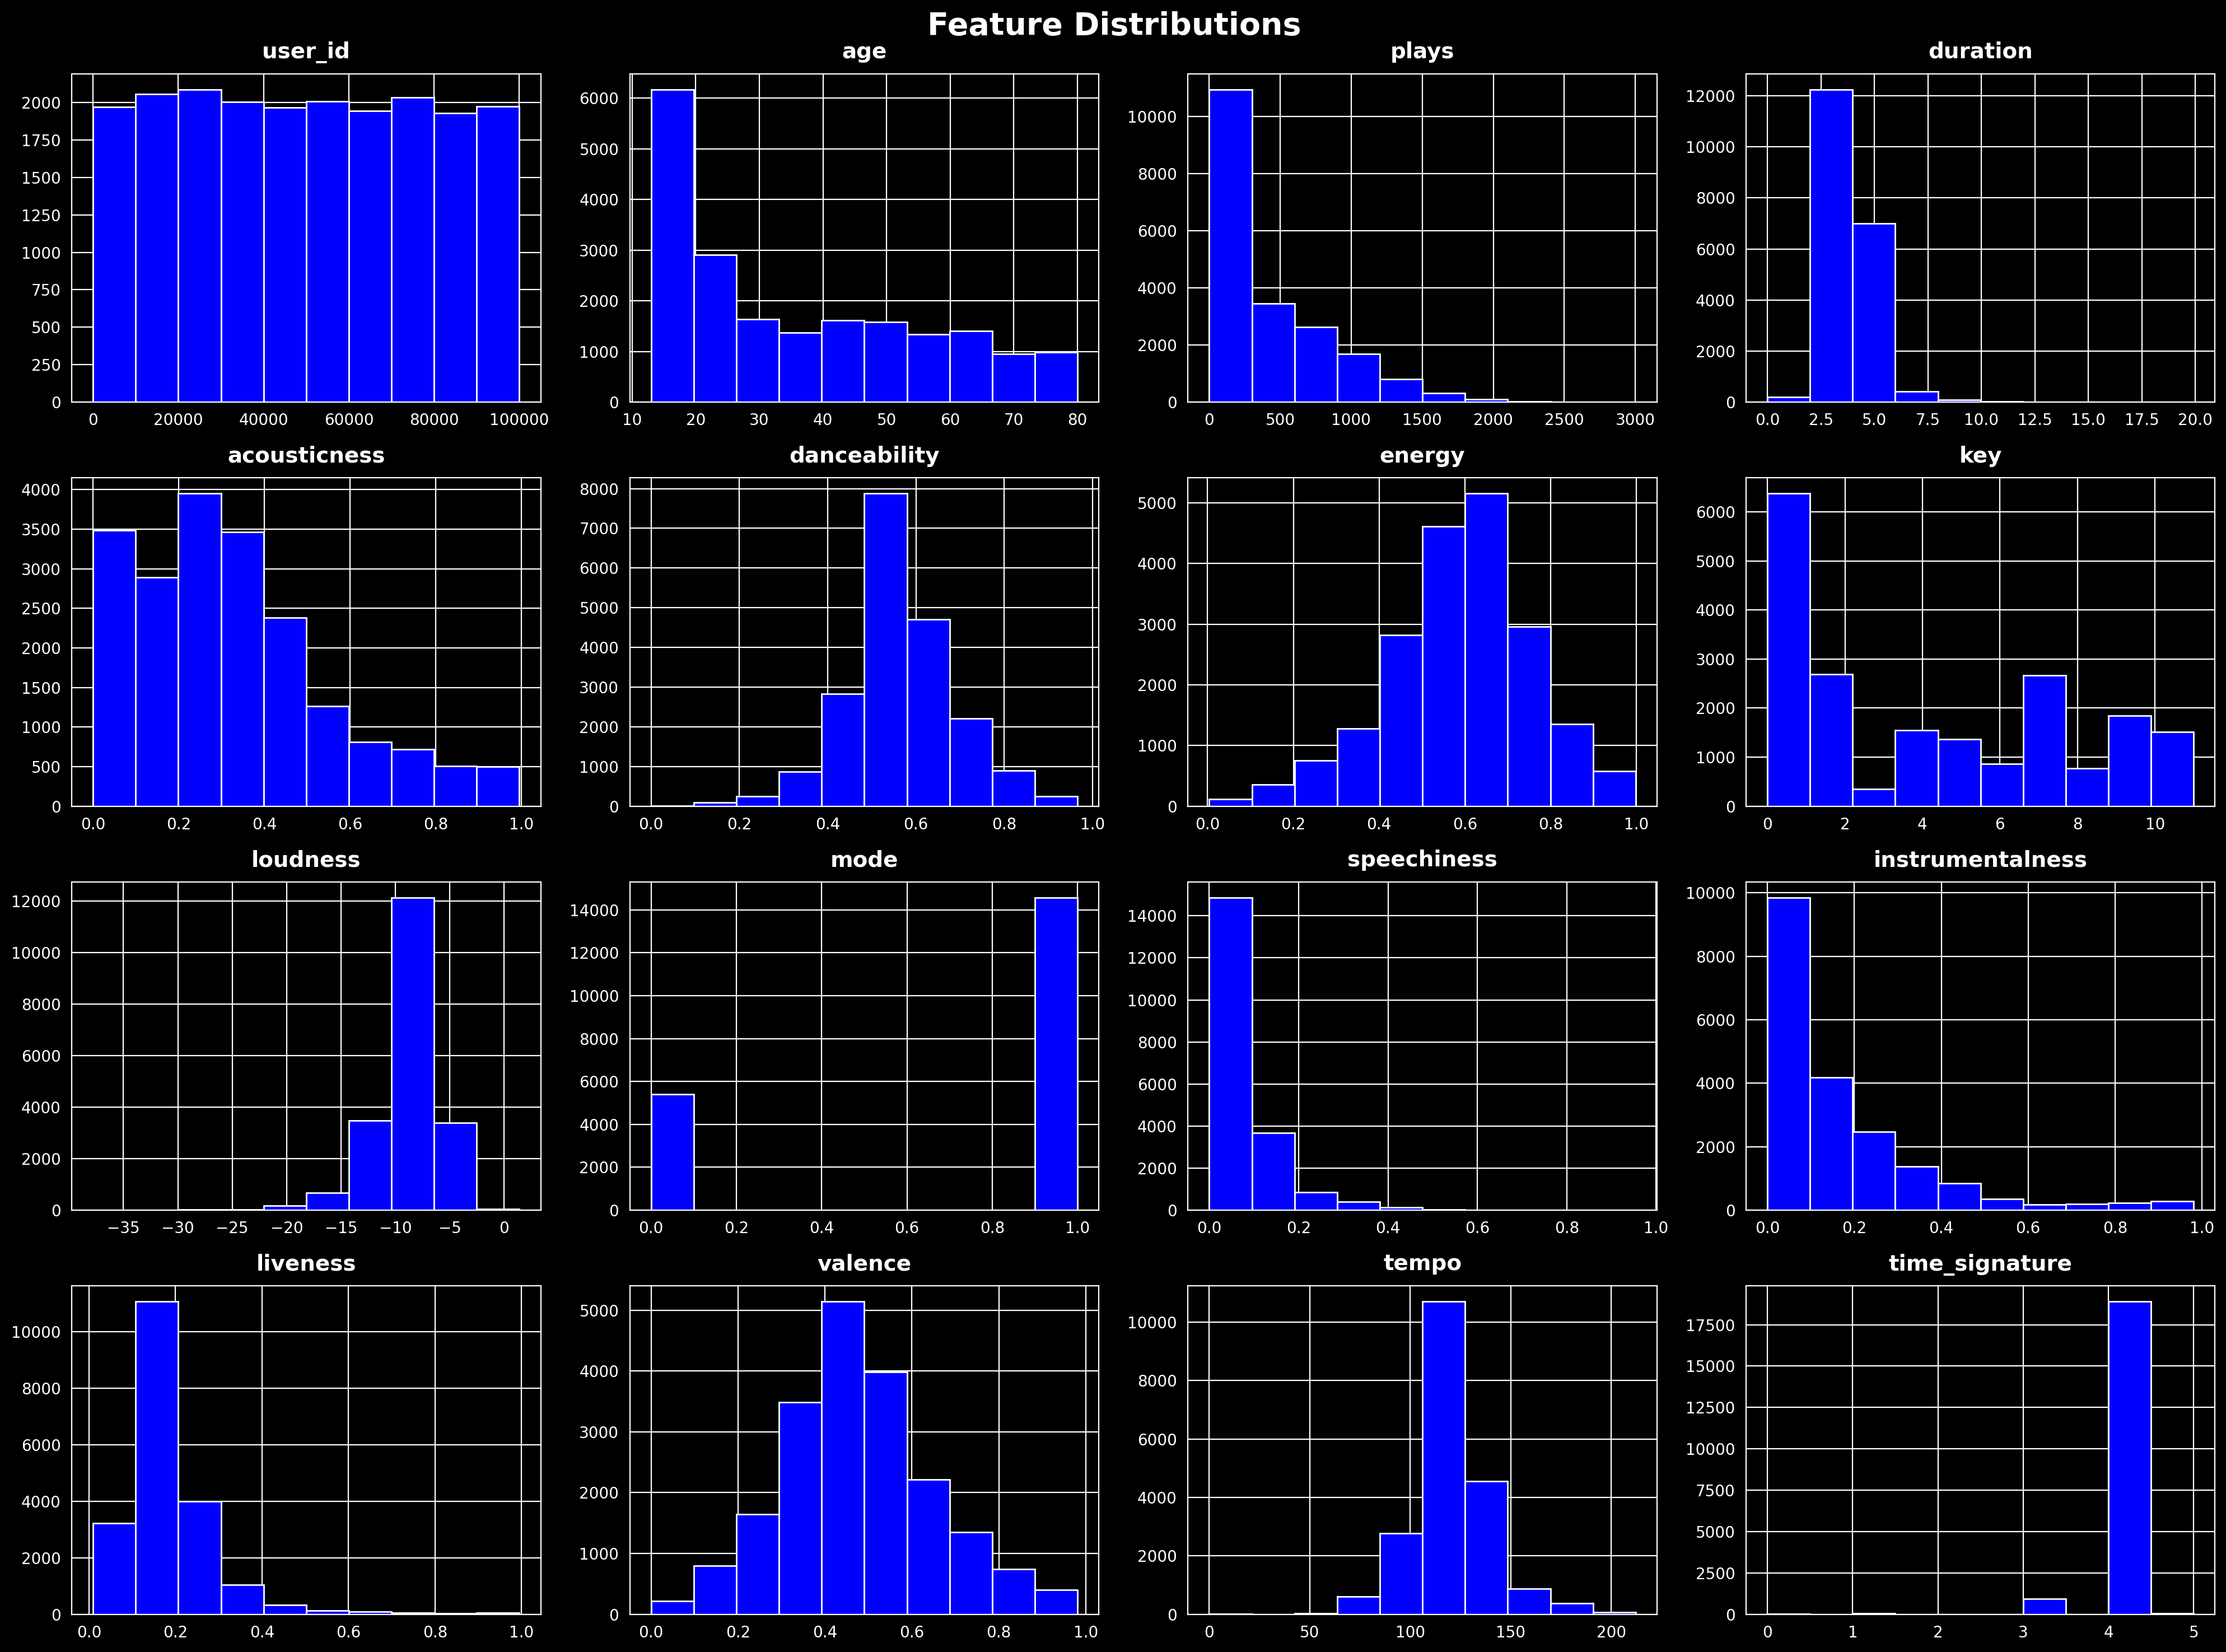

In [11]:
# Plot histograms with sky blue color
supt_presets = dict(fontsize=20, fontweight="bold")

df.hist(figsize=(20, 15), color="blue")
plt.suptitle("Feature Distributions", **supt_presets)
plt.show()  # plots the histograms of the DataFrame with sky blue color

In [12]:
def check_missing_value():
    # show number of missing values as a dataframe by column
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    missing_values = missing_values.sort_values(ascending=False)
    missing_values = missing_values.reset_index()
    missing_values.columns = ["Feature", "Missing Values"]
    return missing_values


check_missing_value()

Feature  Missing Values
0  featured_artists           10356
1             genre            2524

In [13]:
# Fill featured_artists missing values with "Unknown"
df["featured_artists"].fillna("None", inplace=True)

/tmp/ipykernel_14936/327049541.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["featured_artists"].fillna("None", inplace=True)


In [14]:
# Fill genre missing values with "Unknown"
df['genre']= df["genre"].fillna("Unknown")
df.dropna(axis = 0, inplace = True)  #drop any other missing values

In [15]:
check_missing_value()

Empty DataFrame
Columns: [Feature, Missing Values]
Index: []

In [16]:
df.select_dtypes(
    include=["category", "object"]
).columns.tolist()  # prints the columns with categorical data

['gender',
 'music',
 'artist_name',
 'featured_artists',
 'genre',
 'music_id',
 'id_artists',
 'release_date']

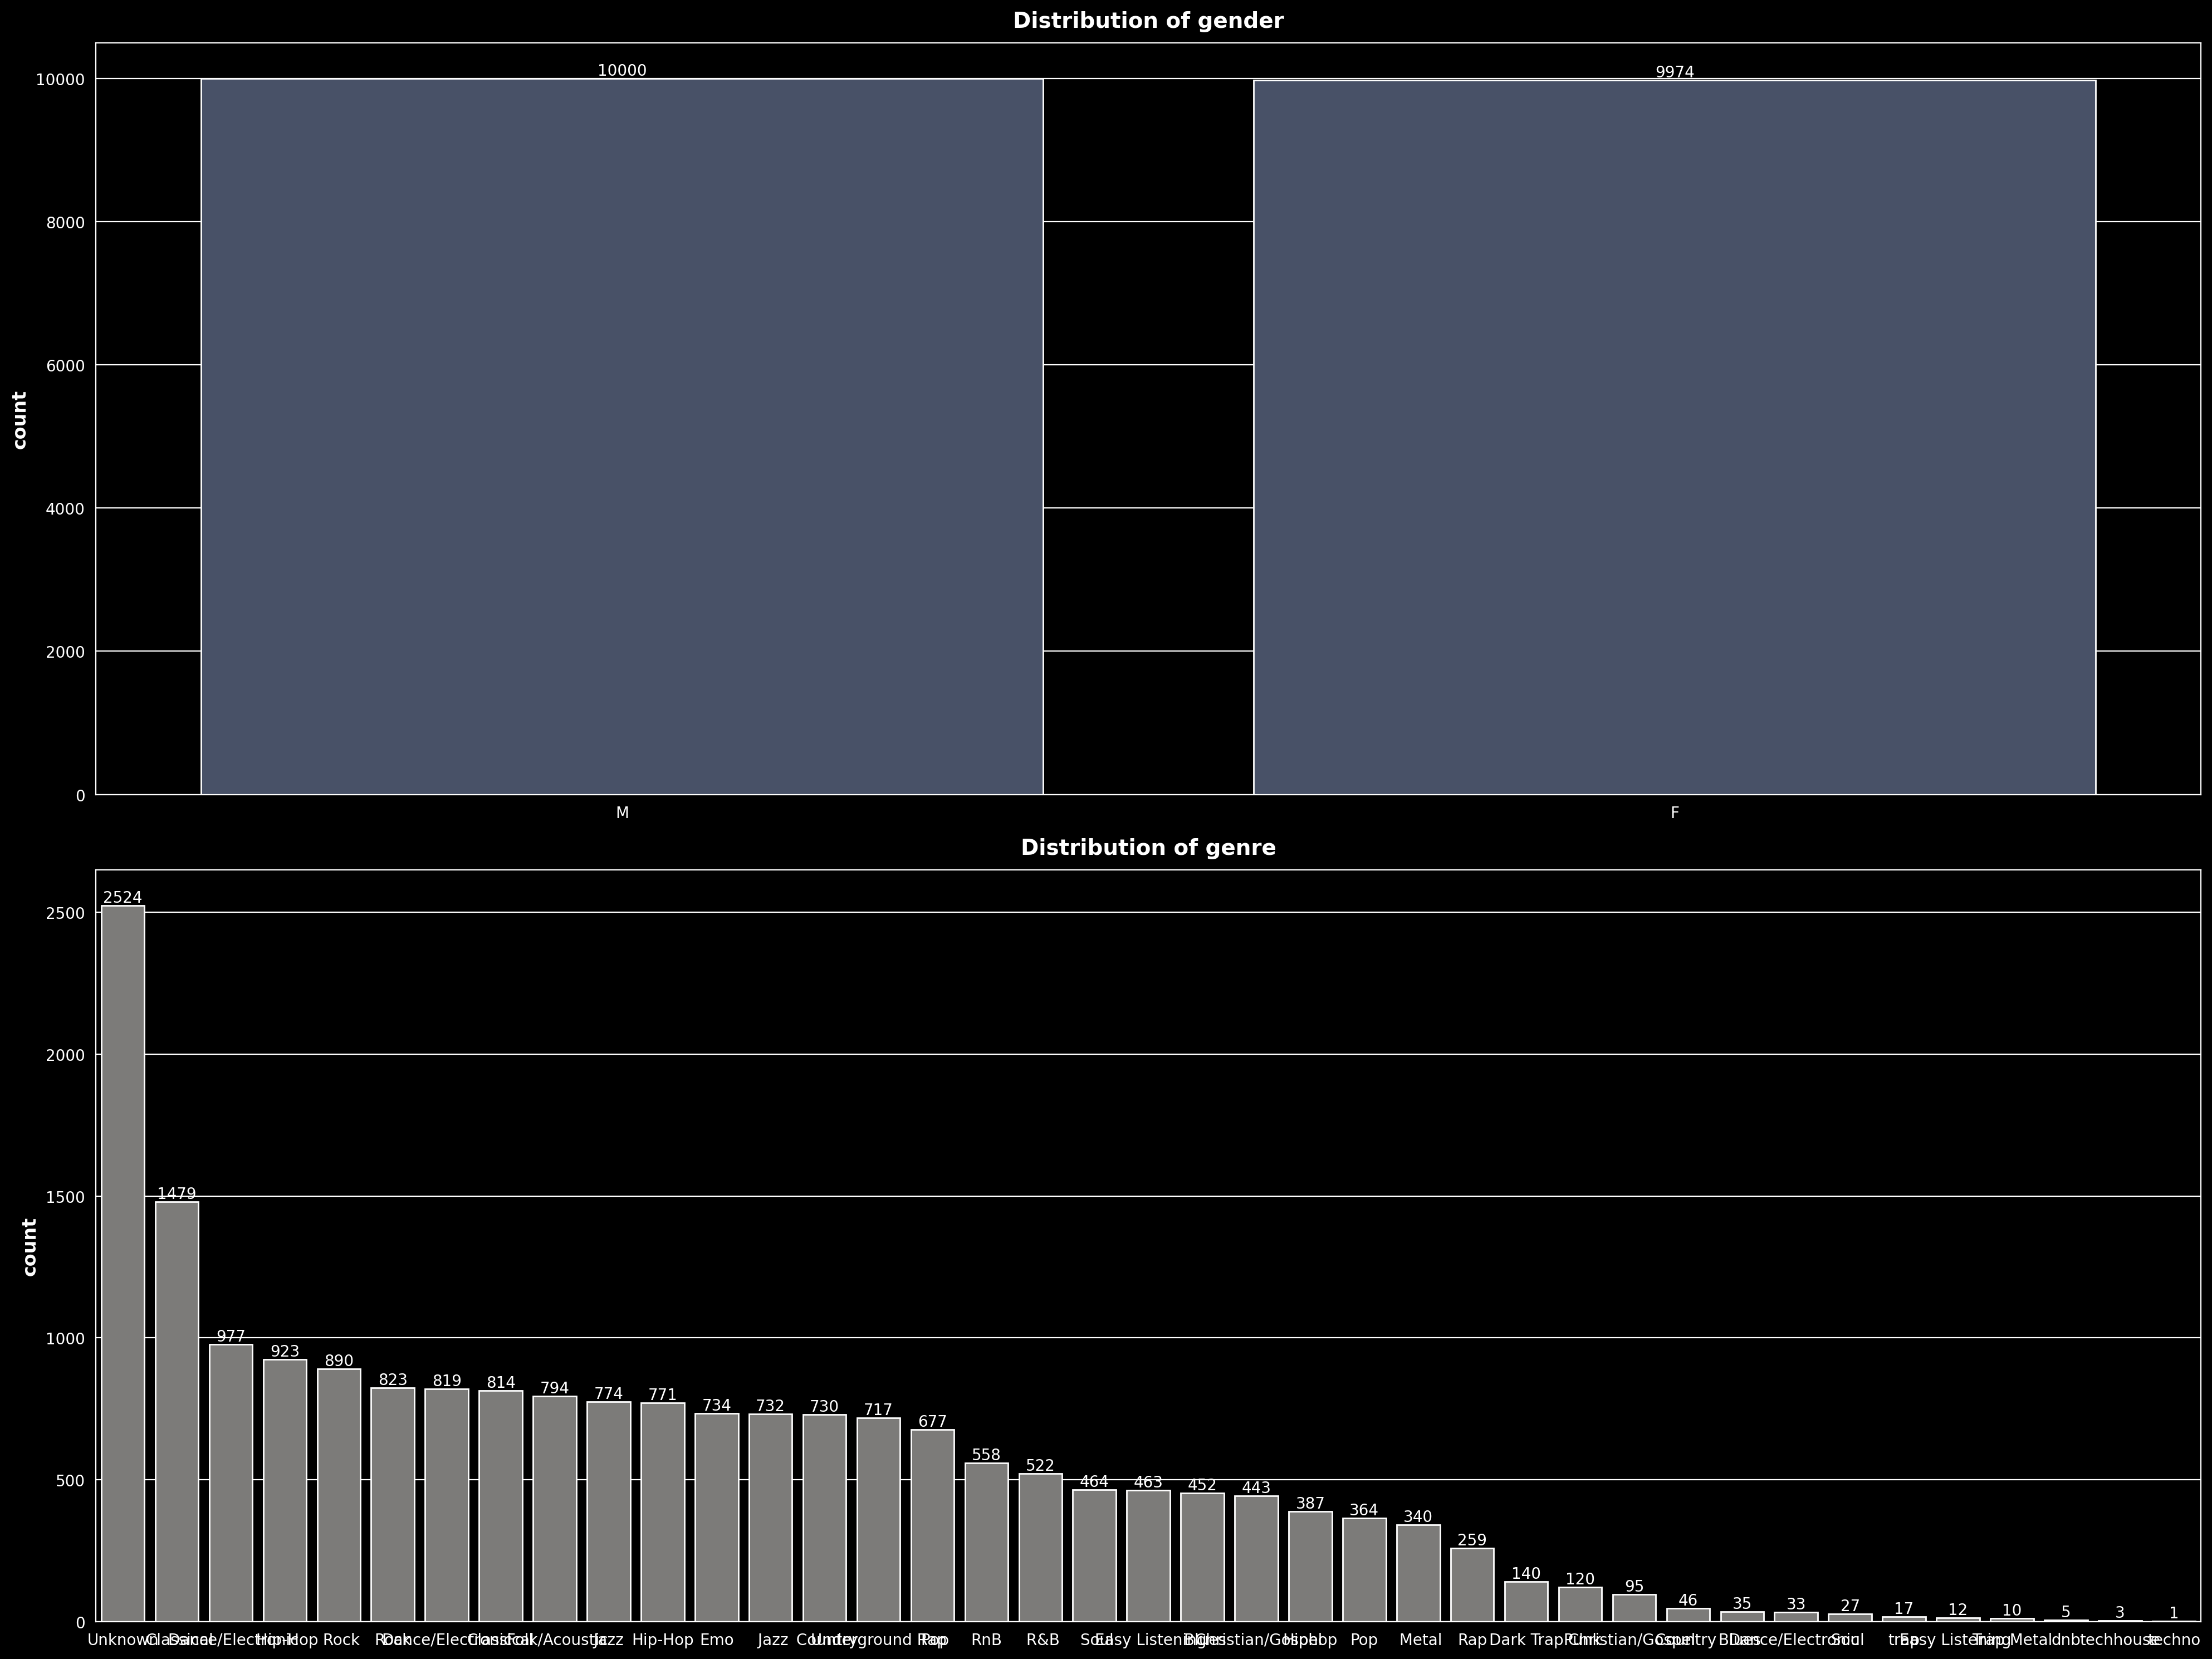

In [17]:
# distribution of categorical columns
cat_cols = ["gender","genre","explicit"]
fig, axes = plt.subplots(2, 1, figsize=(20, 15))
cc = sns.color_palette(n_colors=len(cat_cols), palette="cividis")

for i, ax in enumerate(axes.flatten()):
    # Count the occurrences of each category
    count_data = df[cat_cols[i]].value_counts().sort_values(ascending=False)
    sns.countplot(x=cat_cols[i], data=df, order=count_data.index, ax=ax, color=cc[i])
    ax.set(xlabel="", title=f"Distribution of {cat_cols[i]}")
    ax.bar_label(ax.containers[0], fmt="%.0f")
plt.show()

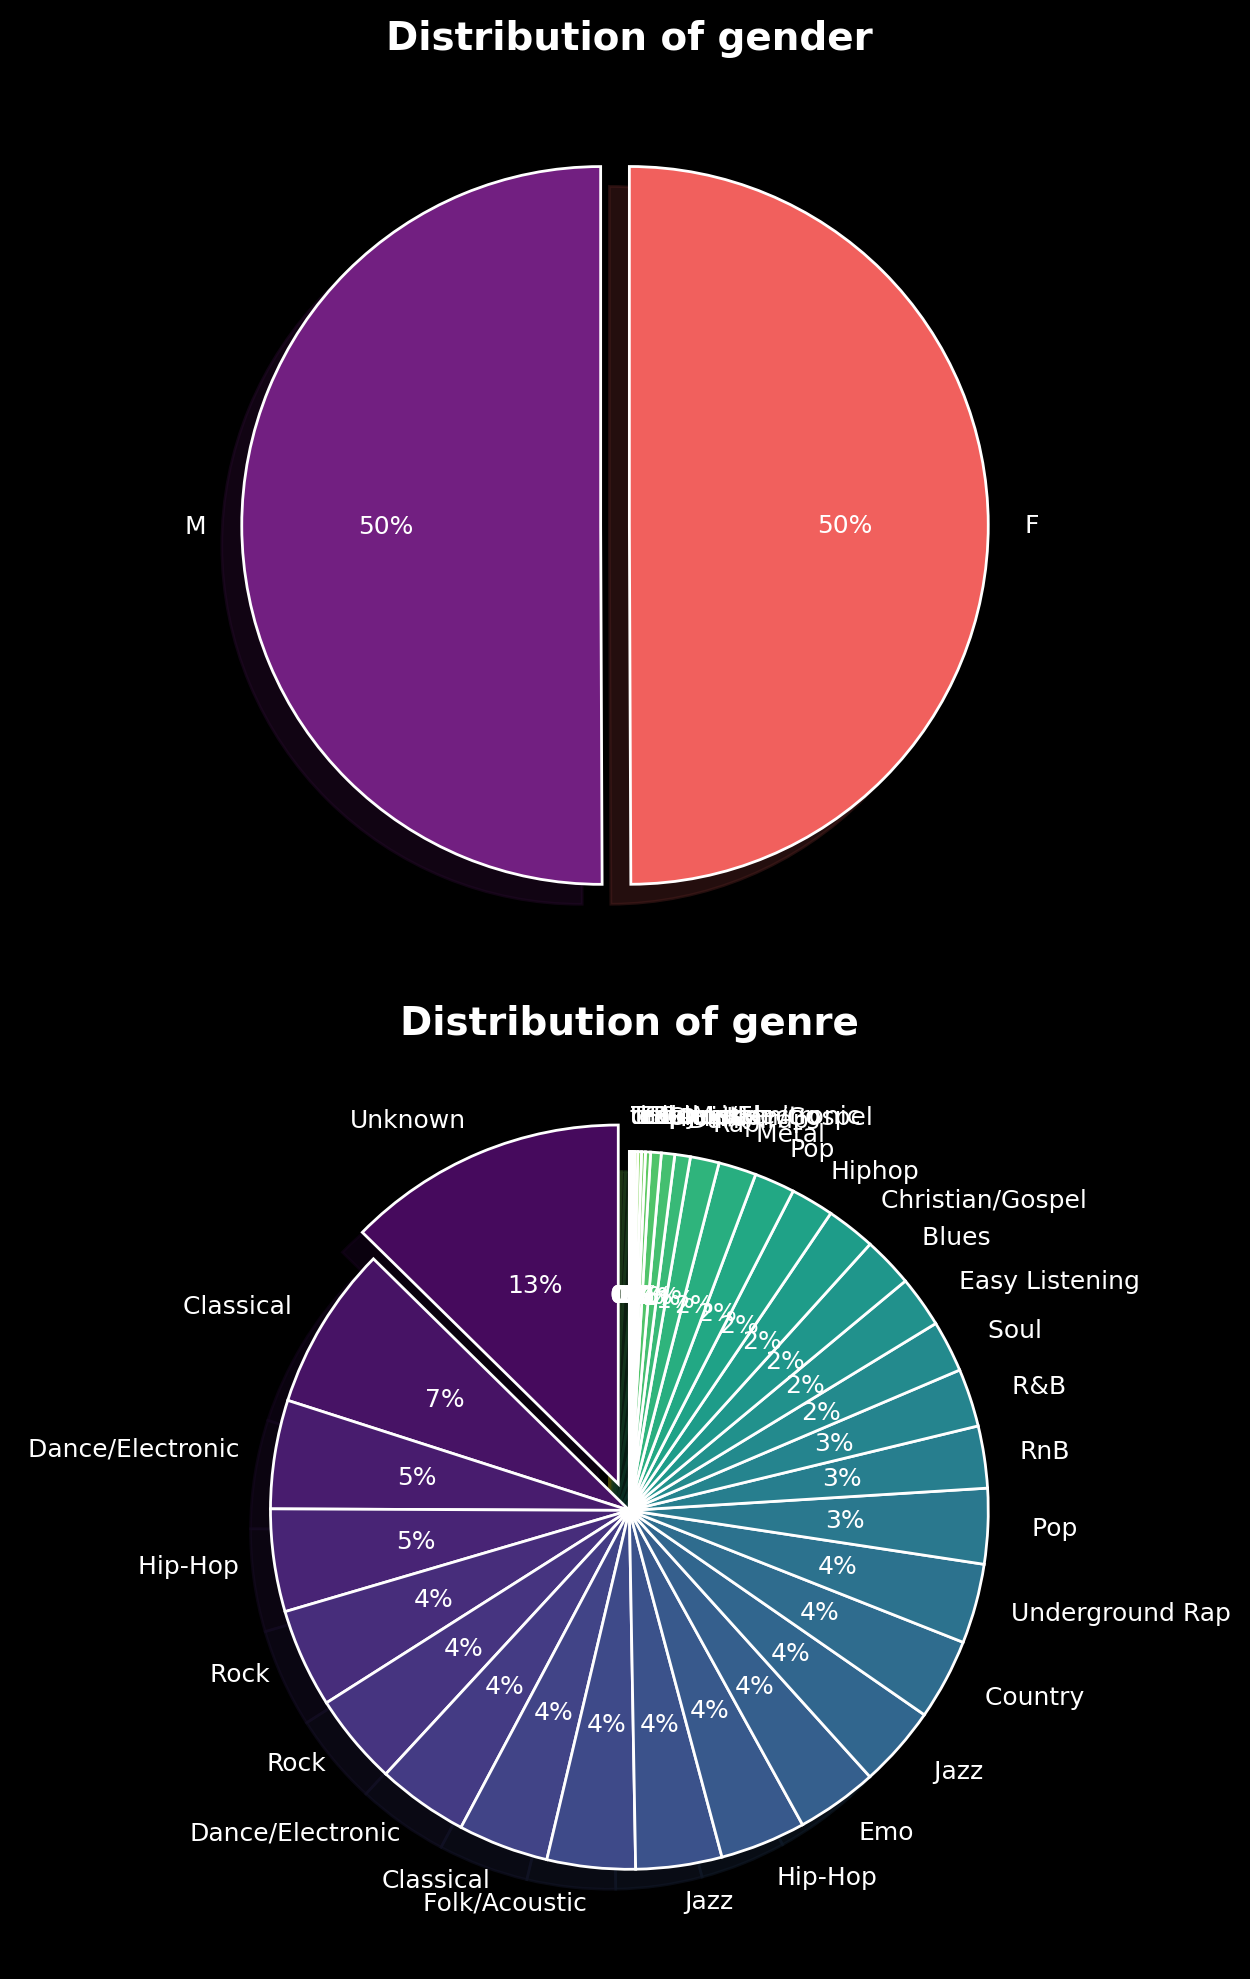

In [19]:
cat_cols = [ "gender", "genre", "explicit"]
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
cc = ["magma", "viridis", "cividis", "magma"]

for i, ax in enumerate(axes.flatten()):
    # Count the occurrences of each category
    count_data = df[cat_cols[i]].value_counts().sort_values(ascending=False)
    # Create pie chart
    n = count_data.shape[0]
    wedges, texts, autotexts = ax.pie(
        count_data,
        labels=count_data.index,
        autopct="%.0f%%",
        colors=sns.color_palette(n_colors=n, palette=cc[i]),
        startangle=90,
        textprops={"fontsize": 9},
        explode=[0.08] + [0] * (n - 1),
        shadow=True,
    )
    ax.set(title=f"Distribution of {cat_cols[i]}")

plt.tight_layout()
plt.show()  # plots the distribution of categorical columns

## Fixing Data Quality Issues With Genre

In [20]:
df['genre'].unique()

array(['Dark Trap', 'Unknown', ' Pop', ' Country', 'Classical', 'Rock',
       'Hiphop', ' Soul  ', 'Dance/Electronic', 'Jazz', ' Soul',
       ' Classical', ' Christian/Gospel', ' Dance/Electronic', 'Hip-Hop',
       ' Hip-Hop', 'Underground Rap', ' Jazz', ' Rock', ' Folk/Acoustic',
       ' Country  ', ' Easy Listening', 'Emo', ' Metal', ' R&B', 'Rap',
       ' Christian/Gospel  ', 'RnB', ' Blues', 'Pop', ' Punk',
       ' Dance/Electronic  ', 'Trap Metal', 'trap', ' Easy Listening  ',
       ' Blues  ', 'dnb', 'techhouse', 'techno'], dtype=object)

In [21]:
# Strip leading and trailing whitespace from the genre column
df['genre'] = df['genre'].str.strip()

# Define the mapping for similar genres
genre_mapping = {
    ' Pop': 'Pop',
    ' Country': 'Country',
    ' Classical': 'Classical',
    ' Christian/Gospel': 'Christian/Gospel',
    ' Dance/Electronic': 'Dance/Electronic',
    ' Hip-Hop': 'Hip-Hop',
    'Hiphop': 'Hip-Hop',
    ' Jazz': 'Jazz',
    ' Rock': 'Rock',
    ' Soul': 'Soul',
    ' Country  ': 'Country',
    ' Christian/Gospel  ': 'Christian/Gospel',
    'R&B': 'RnB',
    'RnB': 'RnB',
}

# Apply the mapping to the genre column
df['genre'] = df['genre'].replace(genre_mapping)

# Verify the cleaned genres
unique_genres = df['genre'].unique()
print(unique_genres)


['Dark Trap' 'Unknown' 'Pop' 'Country' 'Classical' 'Rock' 'Hip-Hop' 'Soul'
 'Dance/Electronic' 'Jazz' 'Christian/Gospel' 'Underground Rap'
 'Folk/Acoustic' 'Easy Listening' 'Emo' 'Metal' 'RnB' 'Rap' 'Blues' 'Punk'
 'Trap Metal' 'trap' 'dnb' 'techhouse' 'techno']


In [22]:
# If genre value counts less than 100, replace with "Other"
genre_counts = df['genre'].value_counts()
other_genres = genre_counts[genre_counts < 100].index
df['genre'] = df['genre'].replace(other_genres, 'Other')

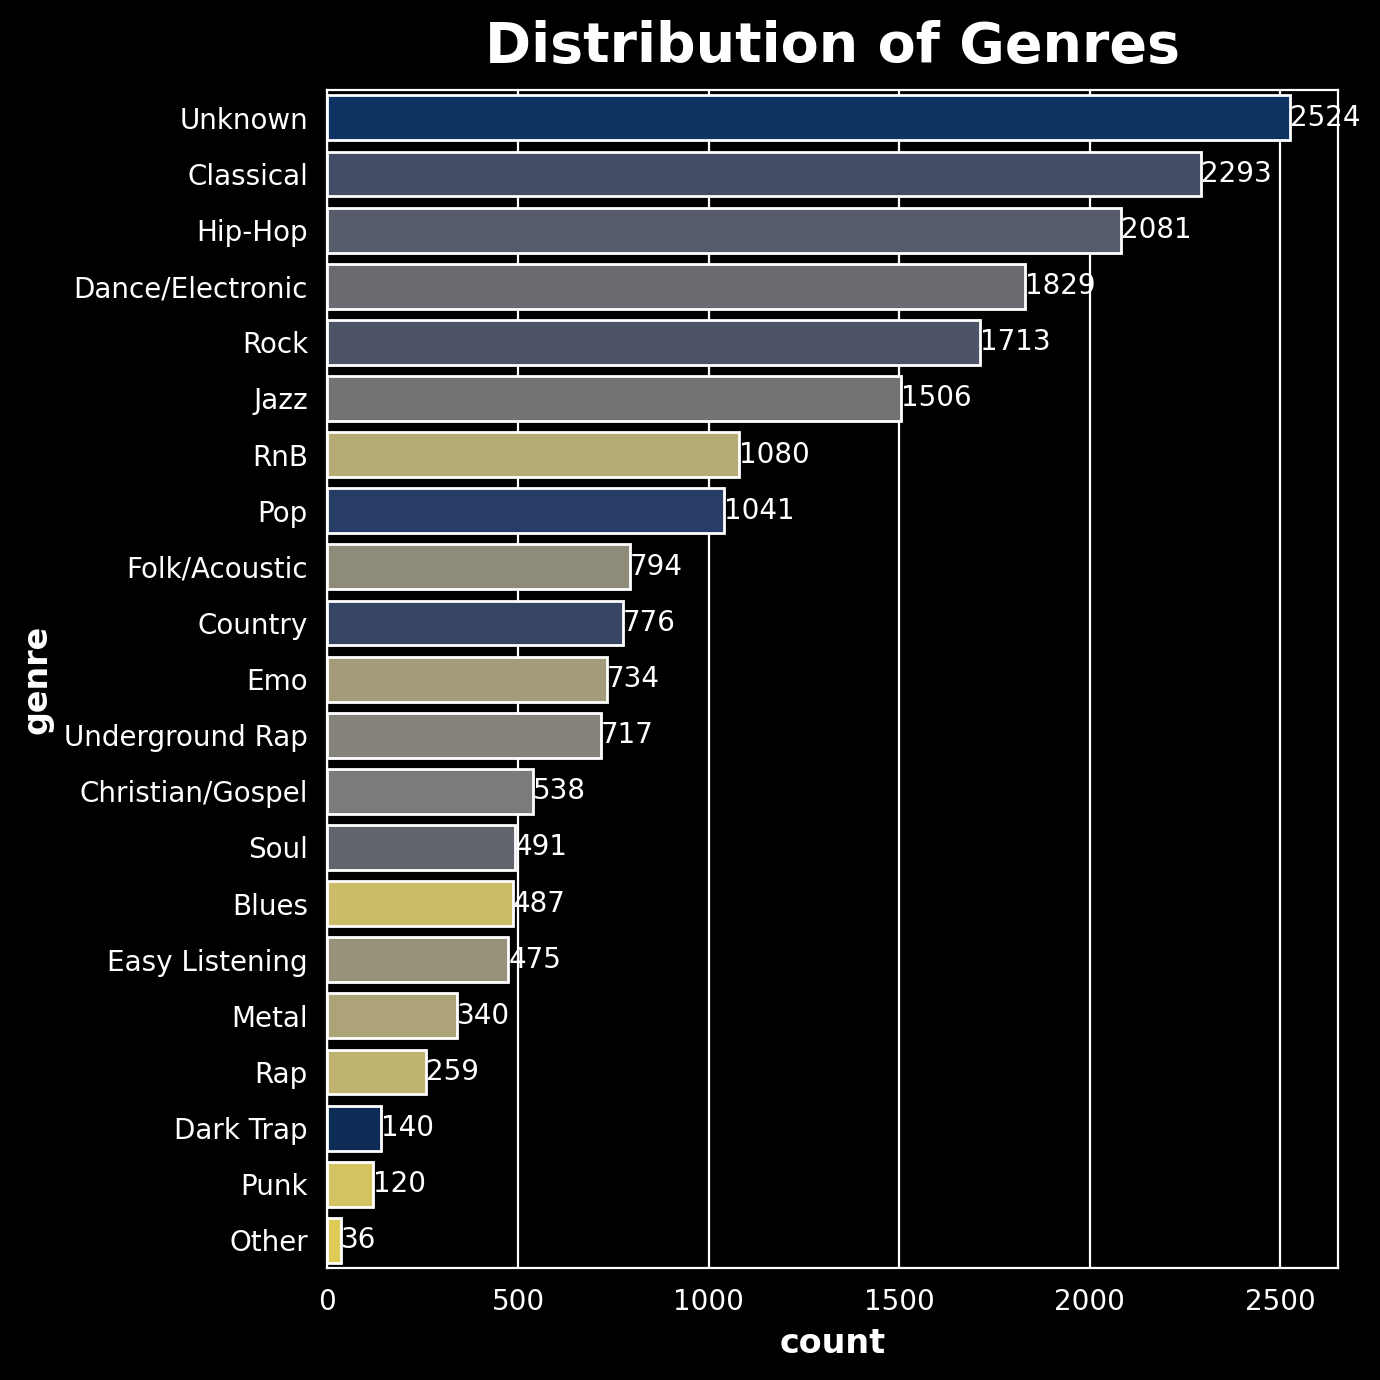

In [23]:
supt_presets = dict(fontsize=20, fontweight="bold")

count_order = df["genre"].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(7, 7))
sns.countplot(
    df,
    y="genre",
    hue="genre",
    order=count_order.index,
    ax=ax,
    palette="cividis",
    legend=False,
)
ax.set_title("Distribution of Genres", **supt_presets)
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f")  # plots the distribution of genres

In [24]:
# profile.to_notebook_iframe()  # displays the profile report in the Jupyter notebook

## Analysis of Song Names

---


In [25]:
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

df_ = df.copy()
# Text Preprocessing
# nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

In [26]:
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text


df_["cleaned_music"] = df_["music"].apply(preprocess_text)

# Word Frequency Analysis
all_words = " ".join(df_["cleaned_music"]).split()
word_freq = Counter(all_words)

In [27]:
display(df_["cleaned_music"].head(20))

0      bank account
1      little talks
2       wherever go
3       new friends
4            dreams
          ...      
15           upside
16             love
17         practice
18    crooked teeth
19     livin prayer
Name: cleaned_music, Length: 20, dtype: object

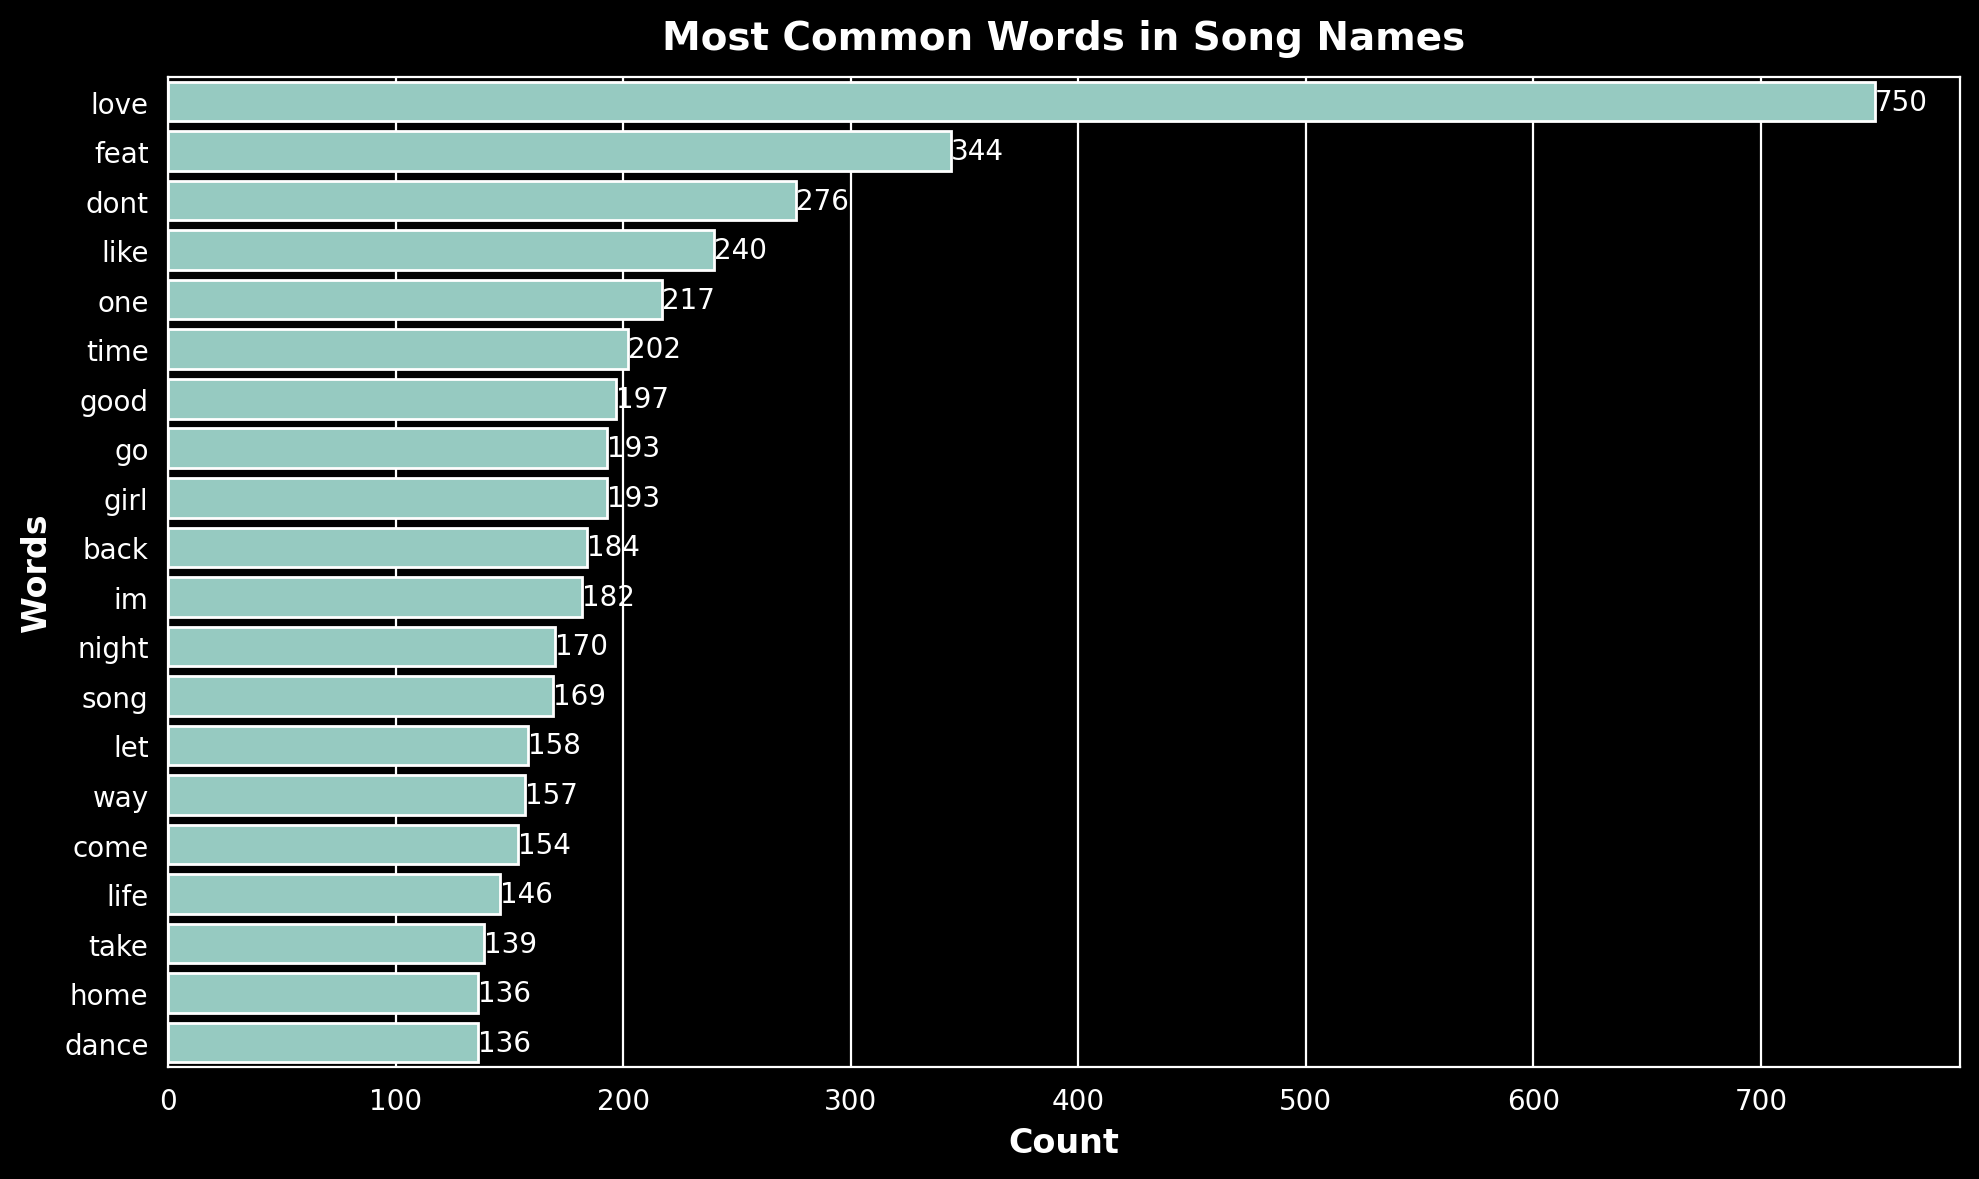

In [28]:
most_common_words = word_freq.most_common(20)

# Plotting Most Common Words
words, counts = zip(*most_common_words)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), ax=ax)
plt.title("Most Common Words in Song Names")
plt.xlabel("Count")
plt.ylabel("Words")
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f")
plt.show()

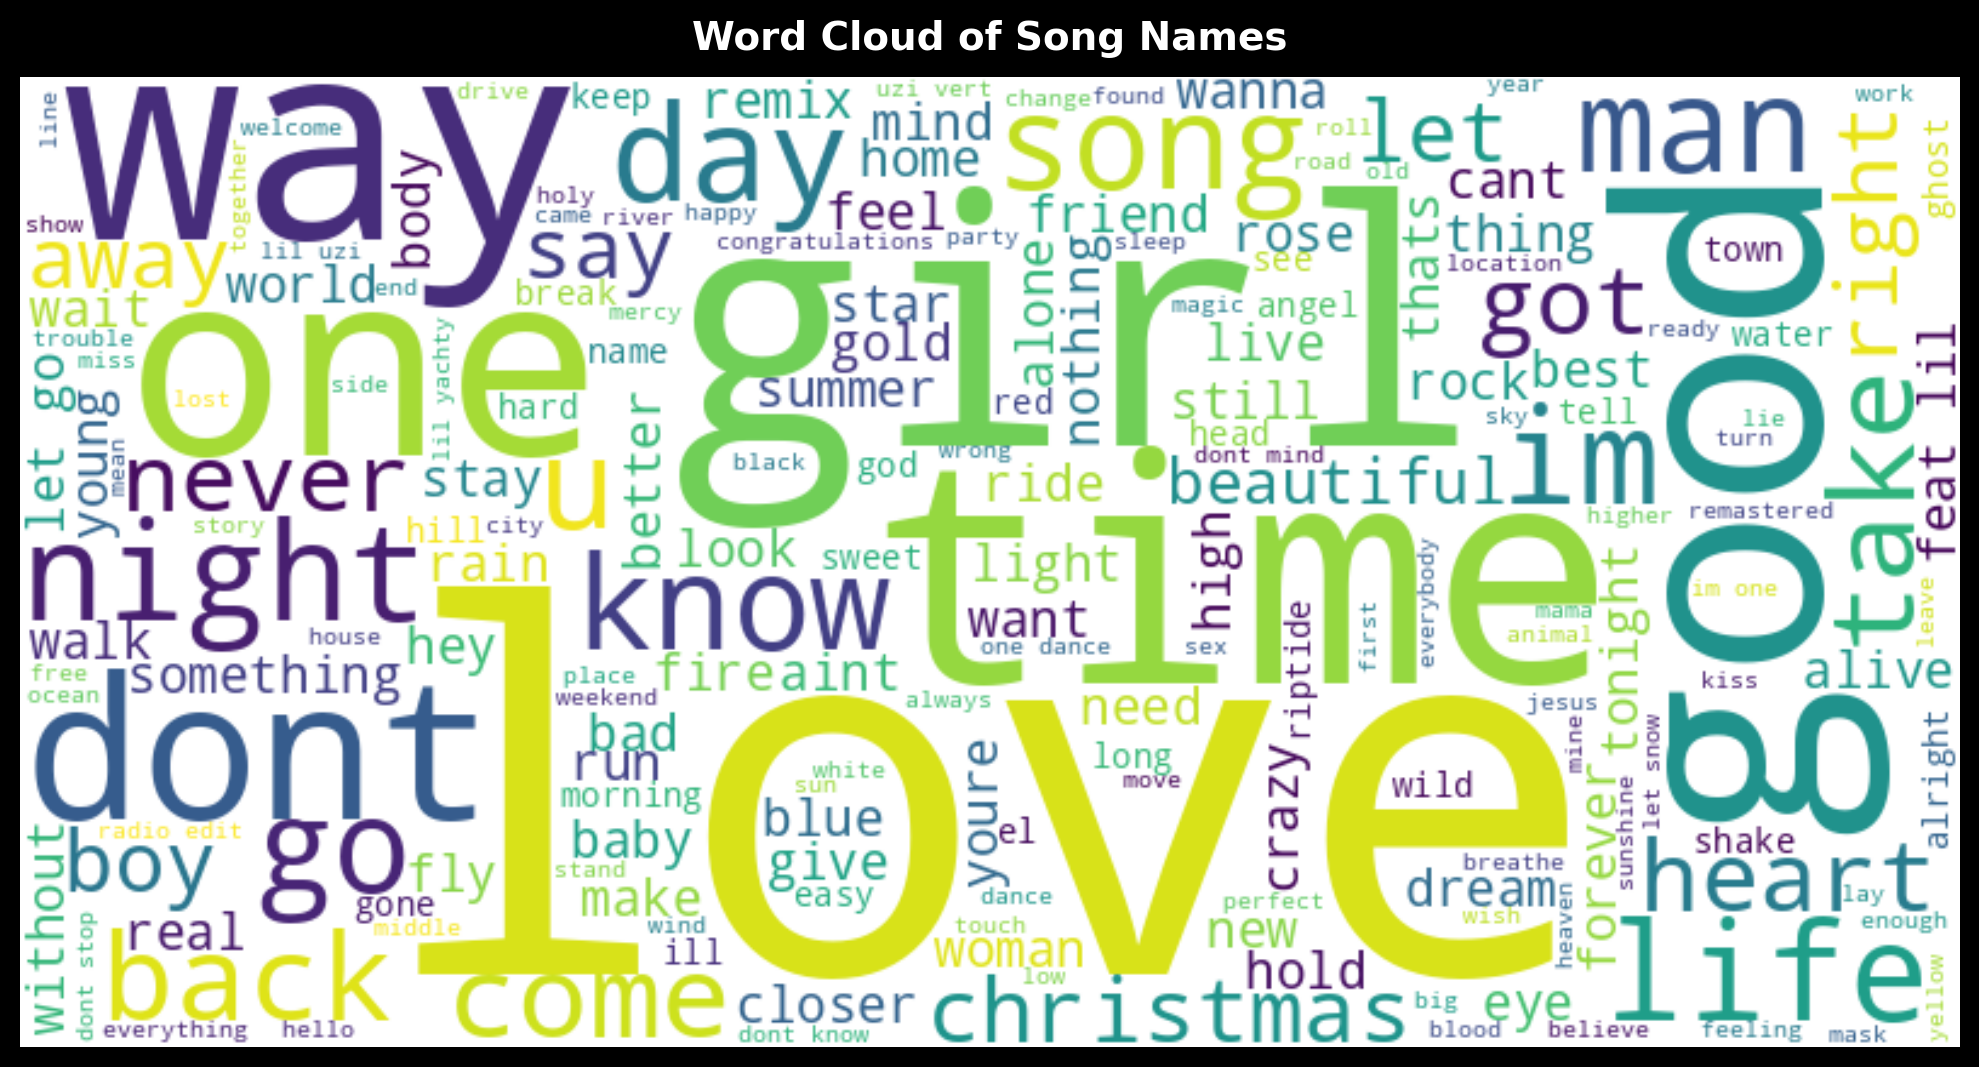

In [29]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    " ".join(all_words)
)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Song Names")
plt.show()

## N-Gram Analysis

---


In [30]:
from nltk.util import ngrams


def get_ngrams(text, n):
    n_grams = ngrams(text.split(), n)
    return [" ".join(grams) for grams in n_grams]


df_["bigrams"] = df_["cleaned_music"].apply(lambda x: get_ngrams(x, 2))
bigram_list = [item for sublist in df_["bigrams"].tolist() for item in sublist]
bigram_freq = Counter(bigram_list)
most_common_bigrams = bigram_freq.most_common(20)

display(most_common_bigrams)

[('let go', 48),
 ('feat lil', 47),
 ('let snow', 29),
 ('dont know', 27),
 ('radio edit', 26),
 ('dont stop', 24),
 ('im one', 23),
 ('dont mind', 23),
 ('one dance', 23),
 ('lil yachty', 23),
 ('lil uzi', 22),
 ('uzi vert', 22),
 ('im gonna', 21),
 ('ispy feat', 21),
 ('say name', 21),
 ('trap queen', 20),
 ('bad boujee', 20),
 ('boujee feat', 20),
 ('let love', 20),
 ('young dumb', 20)]

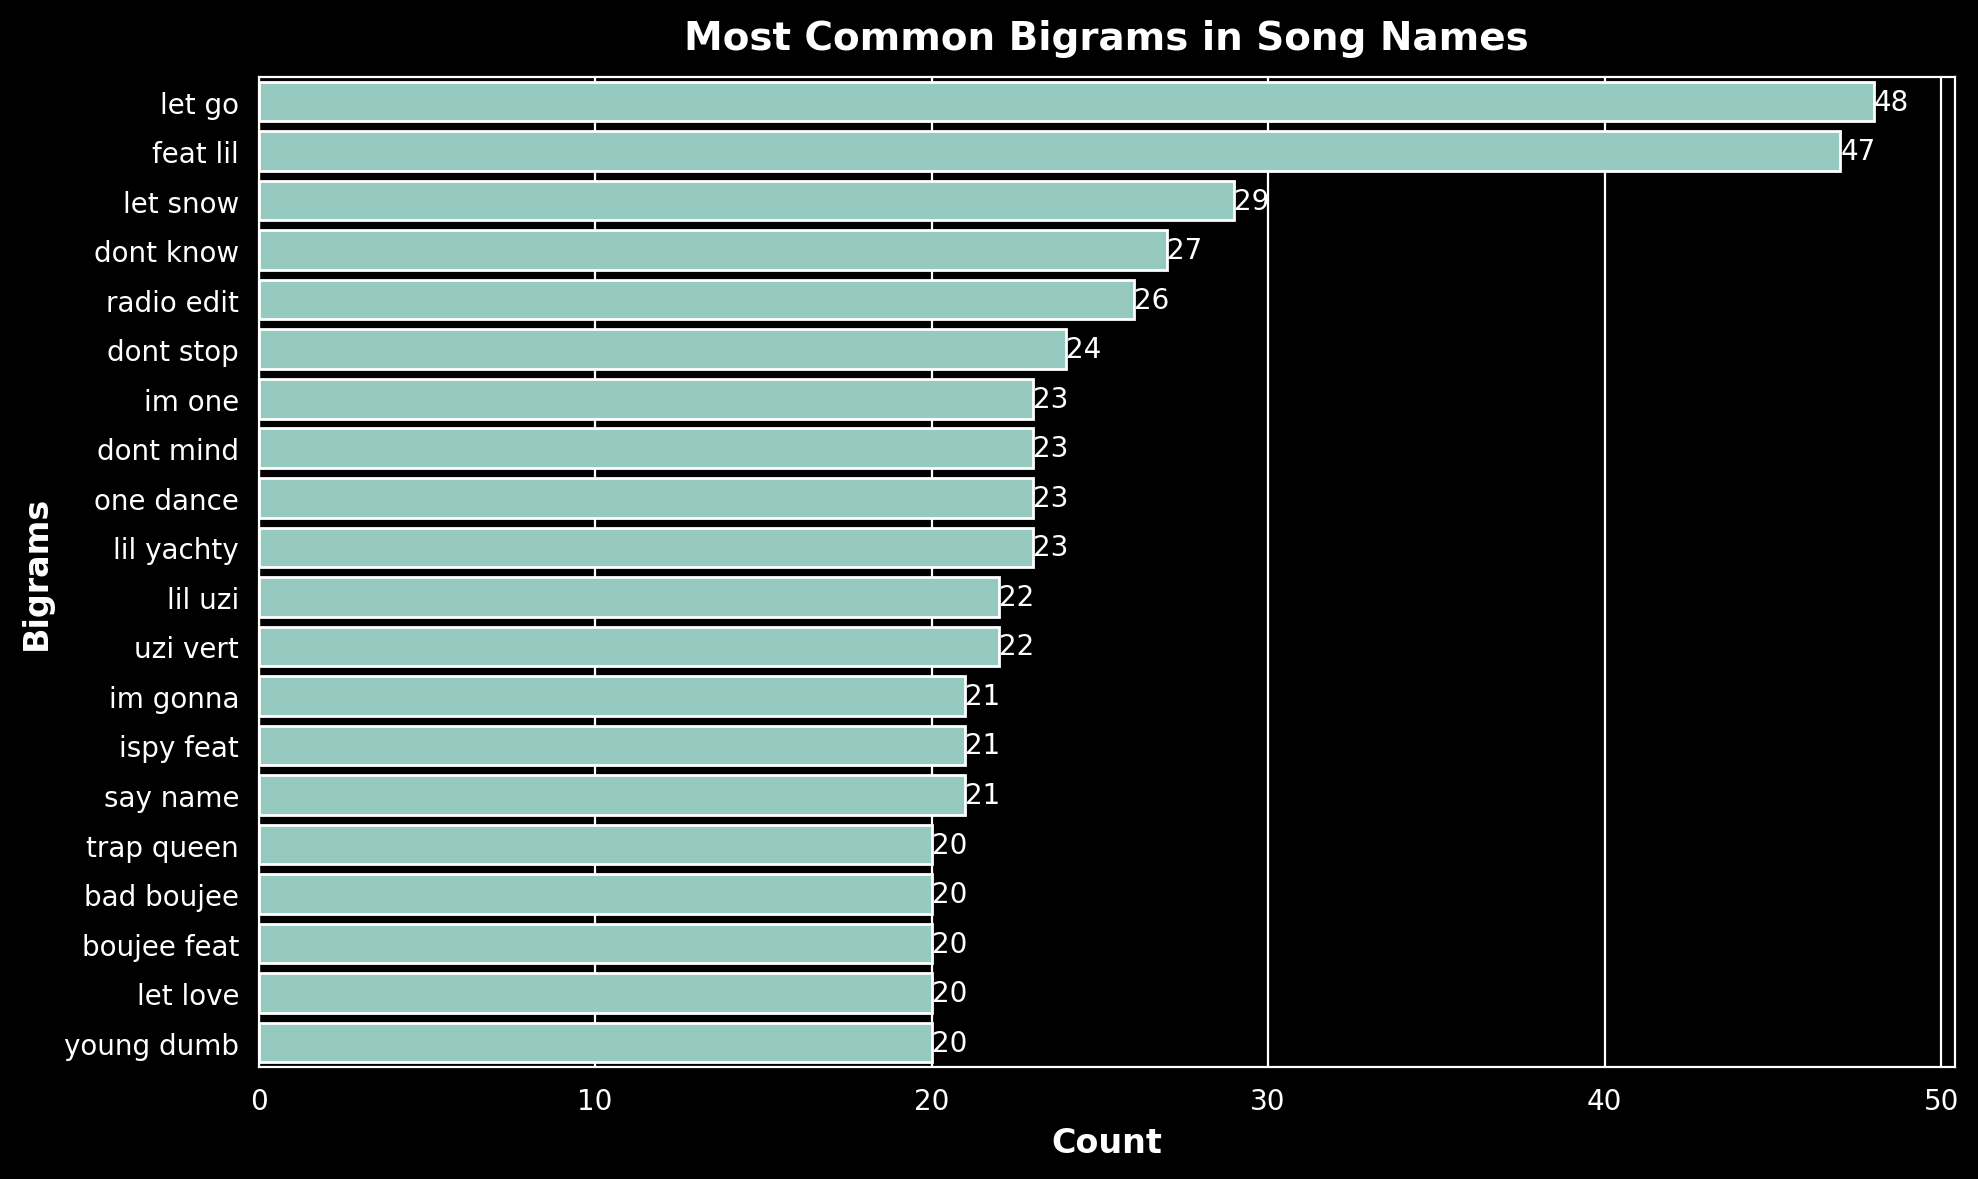

In [31]:
bigrams, counts = zip(*most_common_bigrams)
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(bigrams), ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f")
plt.title("Most Common Bigrams in Song Names")
plt.xlabel("Count")
plt.ylabel("Bigrams")
plt.show()

In [32]:
# Select numeric columns only
df_numeric = df.select_dtypes(include=[np.number])

# Identify outliers using IQR method
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

# Define outlier criteria
outliers = (df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))
print(outliers.sum())

# Remove outliers
df_no_outliers = df_numeric[
    ~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
]

user_id                0
age                    0
plays                259
duration             915
acousticness         691
                    ... 
instrumentalness     918
liveness            1049
valence              405
tempo               1600
time_signature      1076
Length: 16, dtype: int64


## Statistical Tests

In [33]:
df.columns

Index(['user_id', 'age', 'gender', 'music', 'artist_name', 'featured_artists',
       'genre', 'plays', 'duration', 'music_id', 'id_artists', 'acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'release_date', 'explicit'],
      dtype='object')

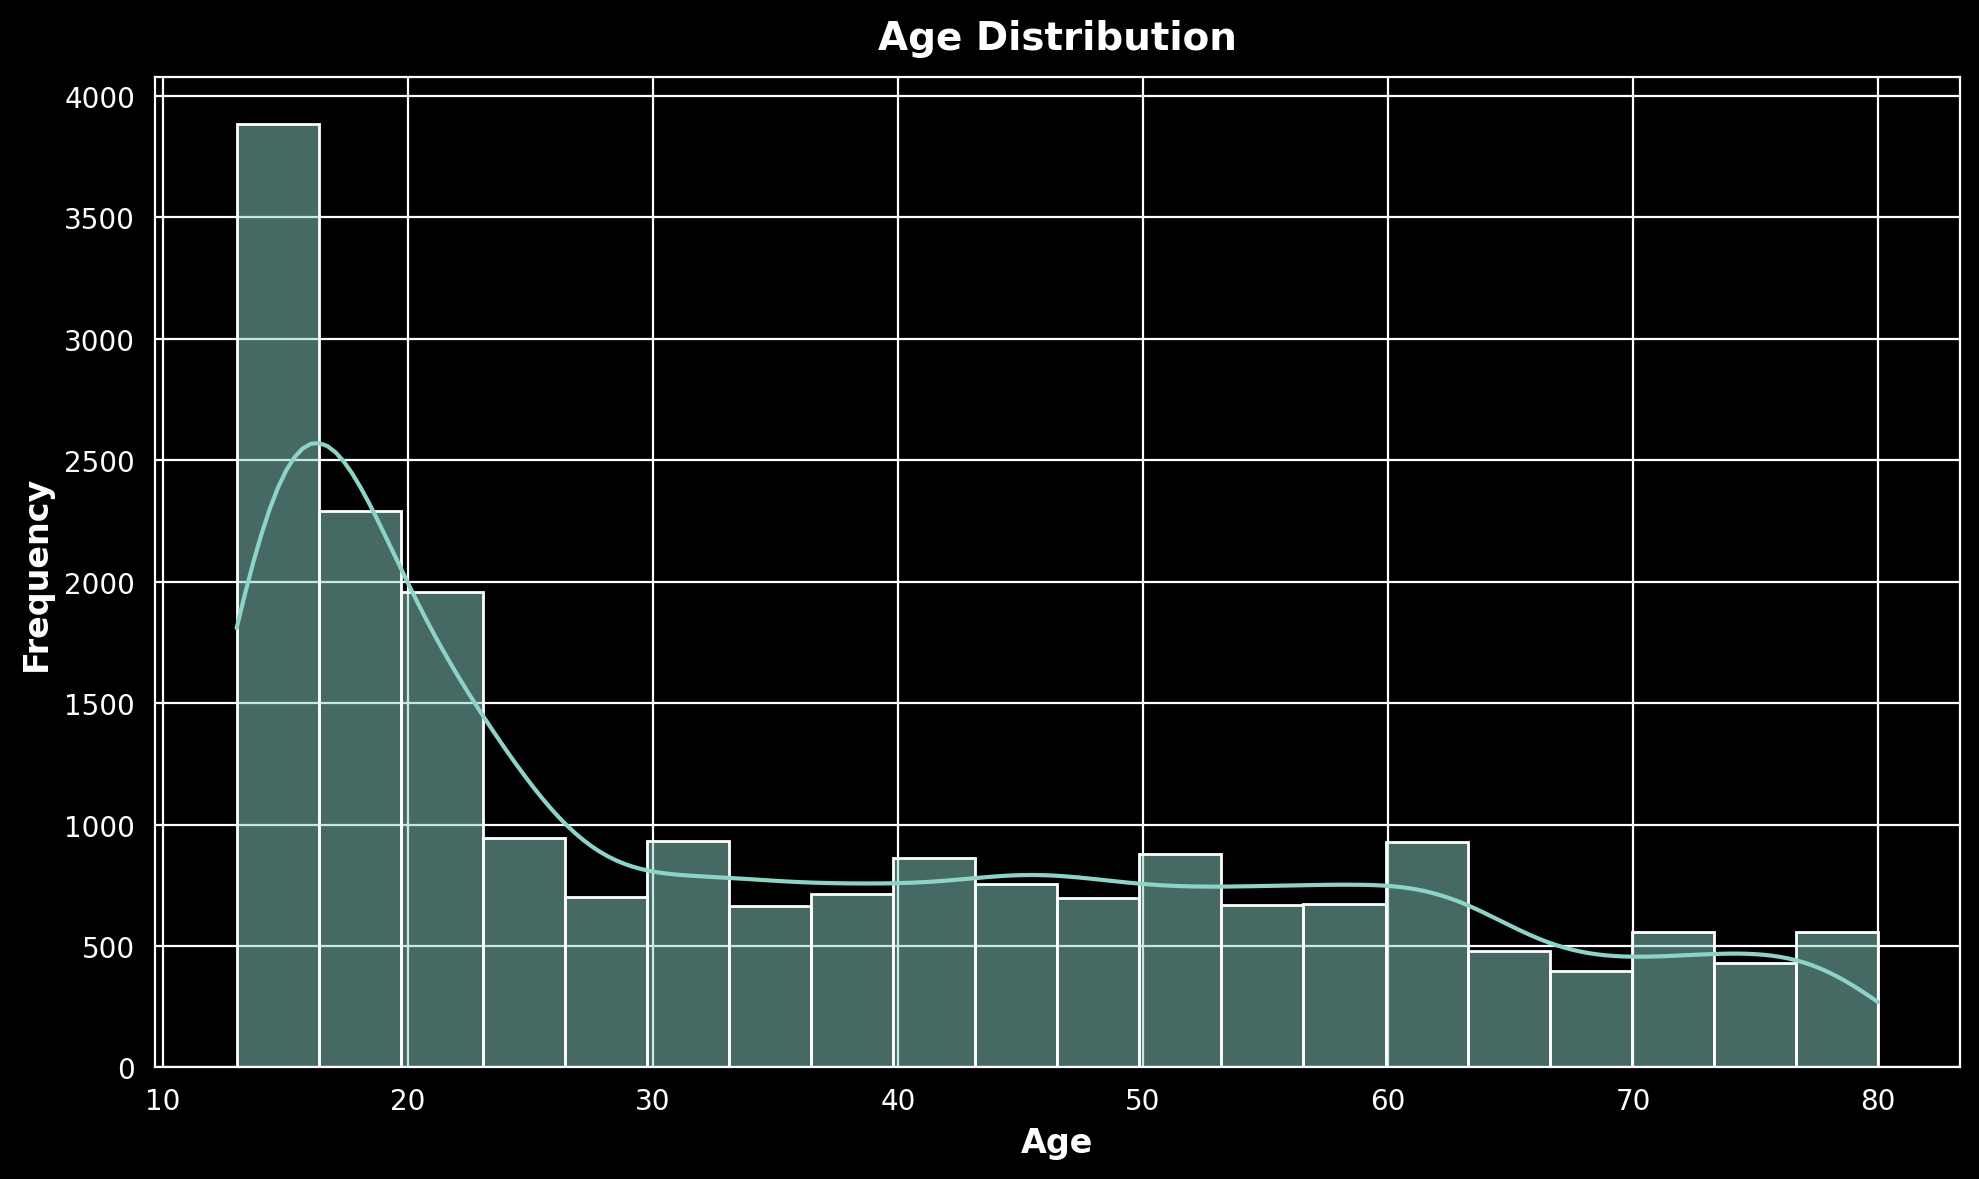

In [34]:
# Histograms for age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [35]:
df['age_group'] = pd.cut(df['age'], bins=[0,26,42,58,77,100], labels=['Gen Z', 'Millenials', 'Gen X', 'Baby Boomers', 'Silent Generation'])


In [36]:
from scipy.stats import chi2_contingency, f_oneway, ttest_ind

# Chi-Square Test for Independence between gender and genre
contingency_table = pd.crosstab(df['gender'], df['genre'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f'Chi-Square Test:\np-value = {p:.3f}\n{"="*60}\n')

# ANOVA to test differences in danceability across age groups
age_groups = df['age'].unique()
danceability_data = [df[df['age'] == age_group]['danceability'] for age_group in age_groups]
f_stat, p_val = f_oneway(*danceability_data)
print(f'ANOVA:\np-value = {p_val:.3f}')


Chi-Square Test:
p-value = 0.291

ANOVA:
p-value = 0.940


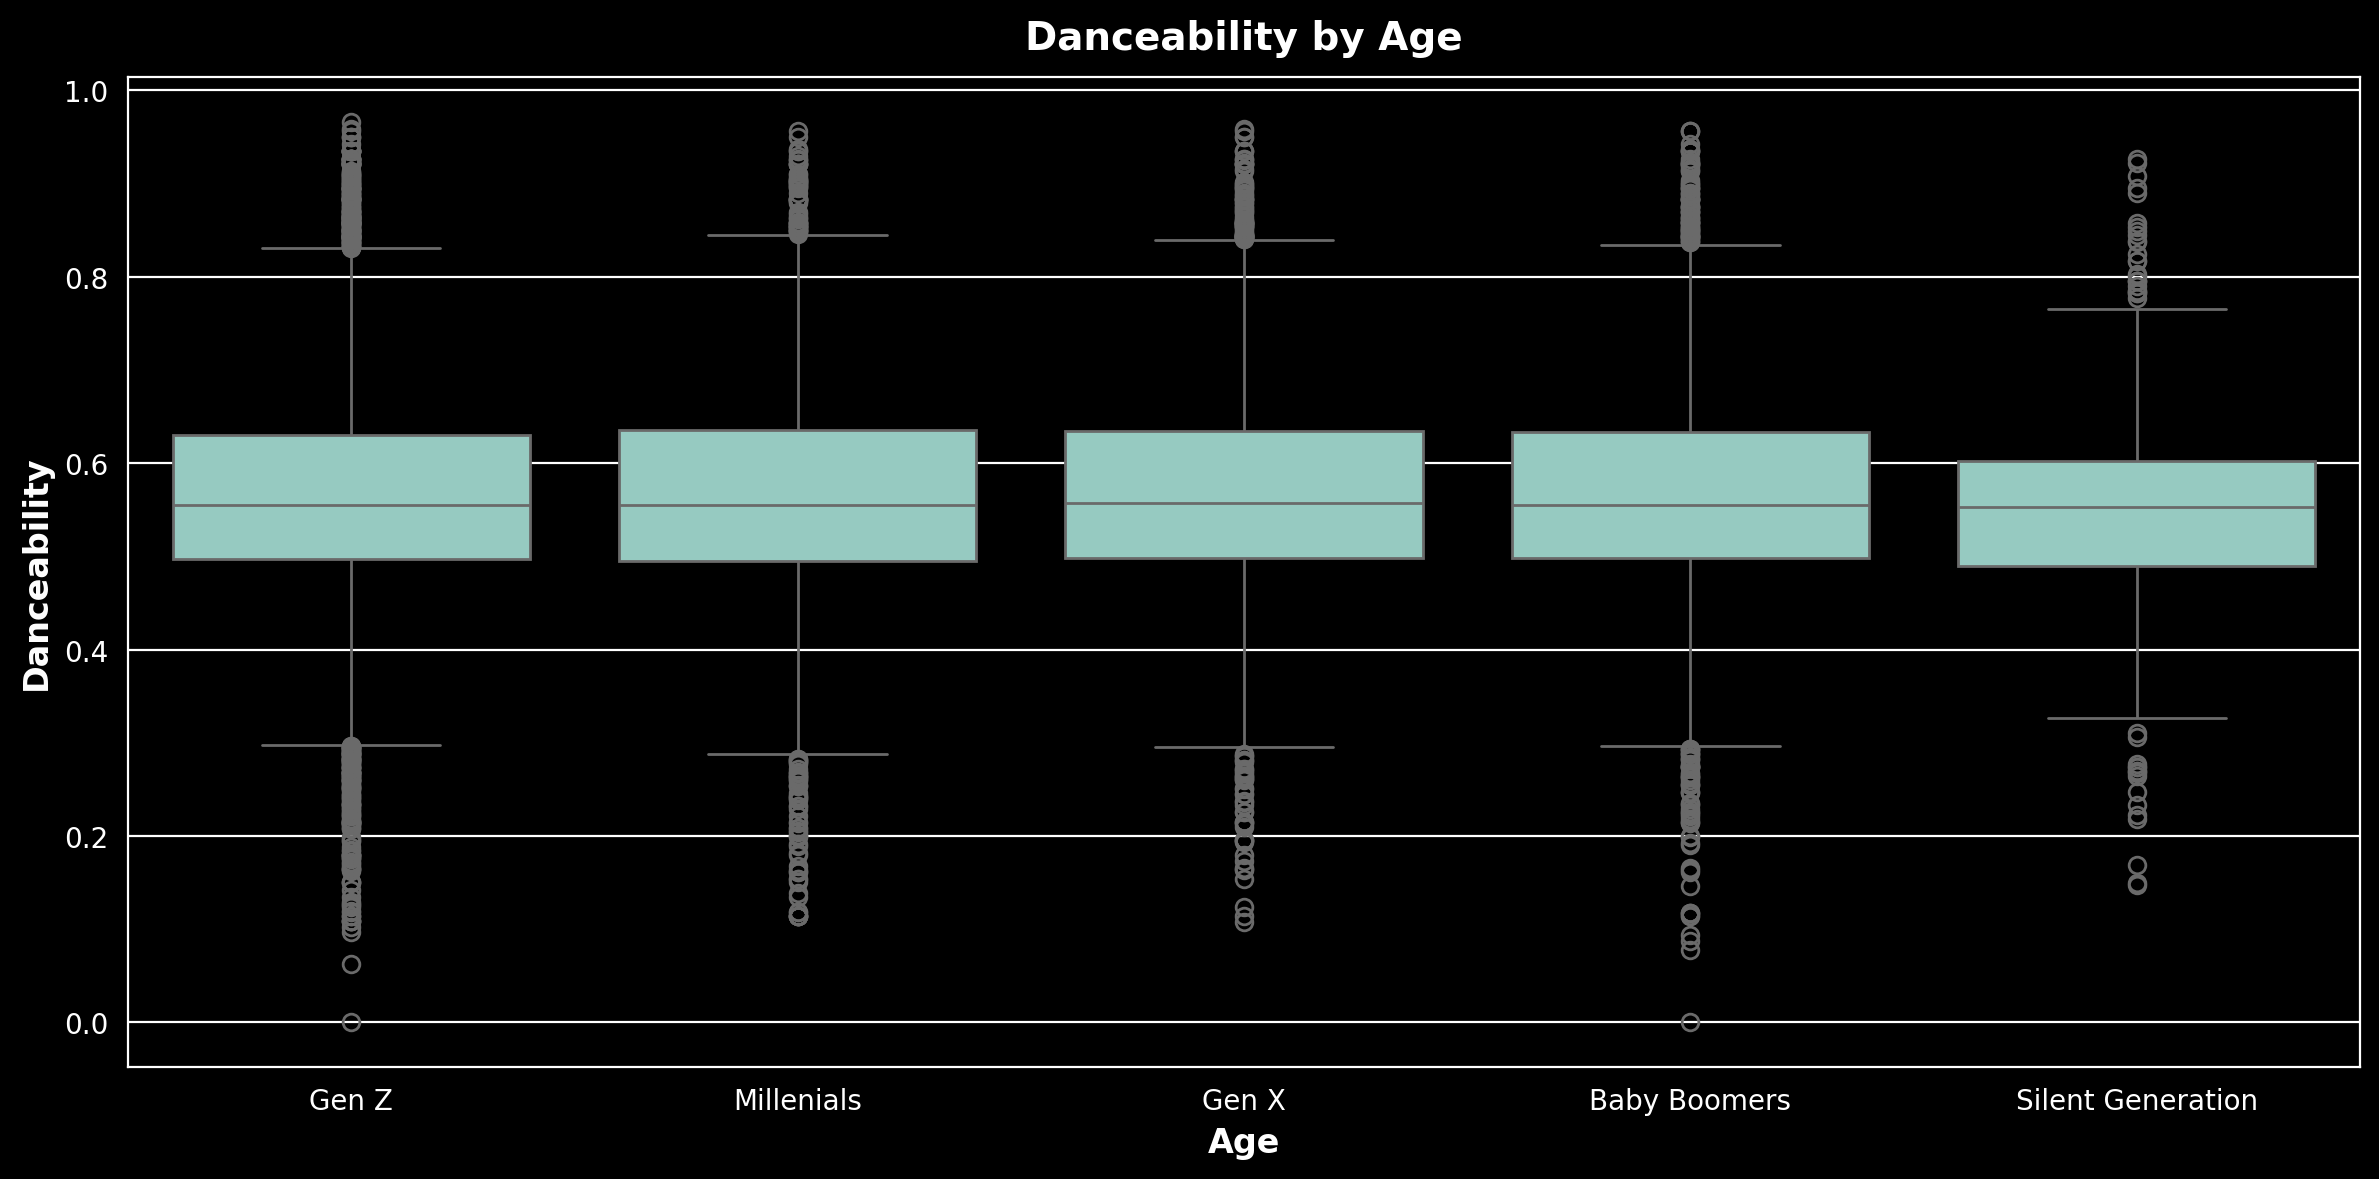

In [37]:
# Visualize danceability across different age groups
plt.figure(figsize=(12, 6))
sns.boxplot(x='age_group', y='danceability', data=df)
plt.title('Danceability by Age')
plt.xlabel('Age')
plt.ylabel('Danceability')
plt.show()

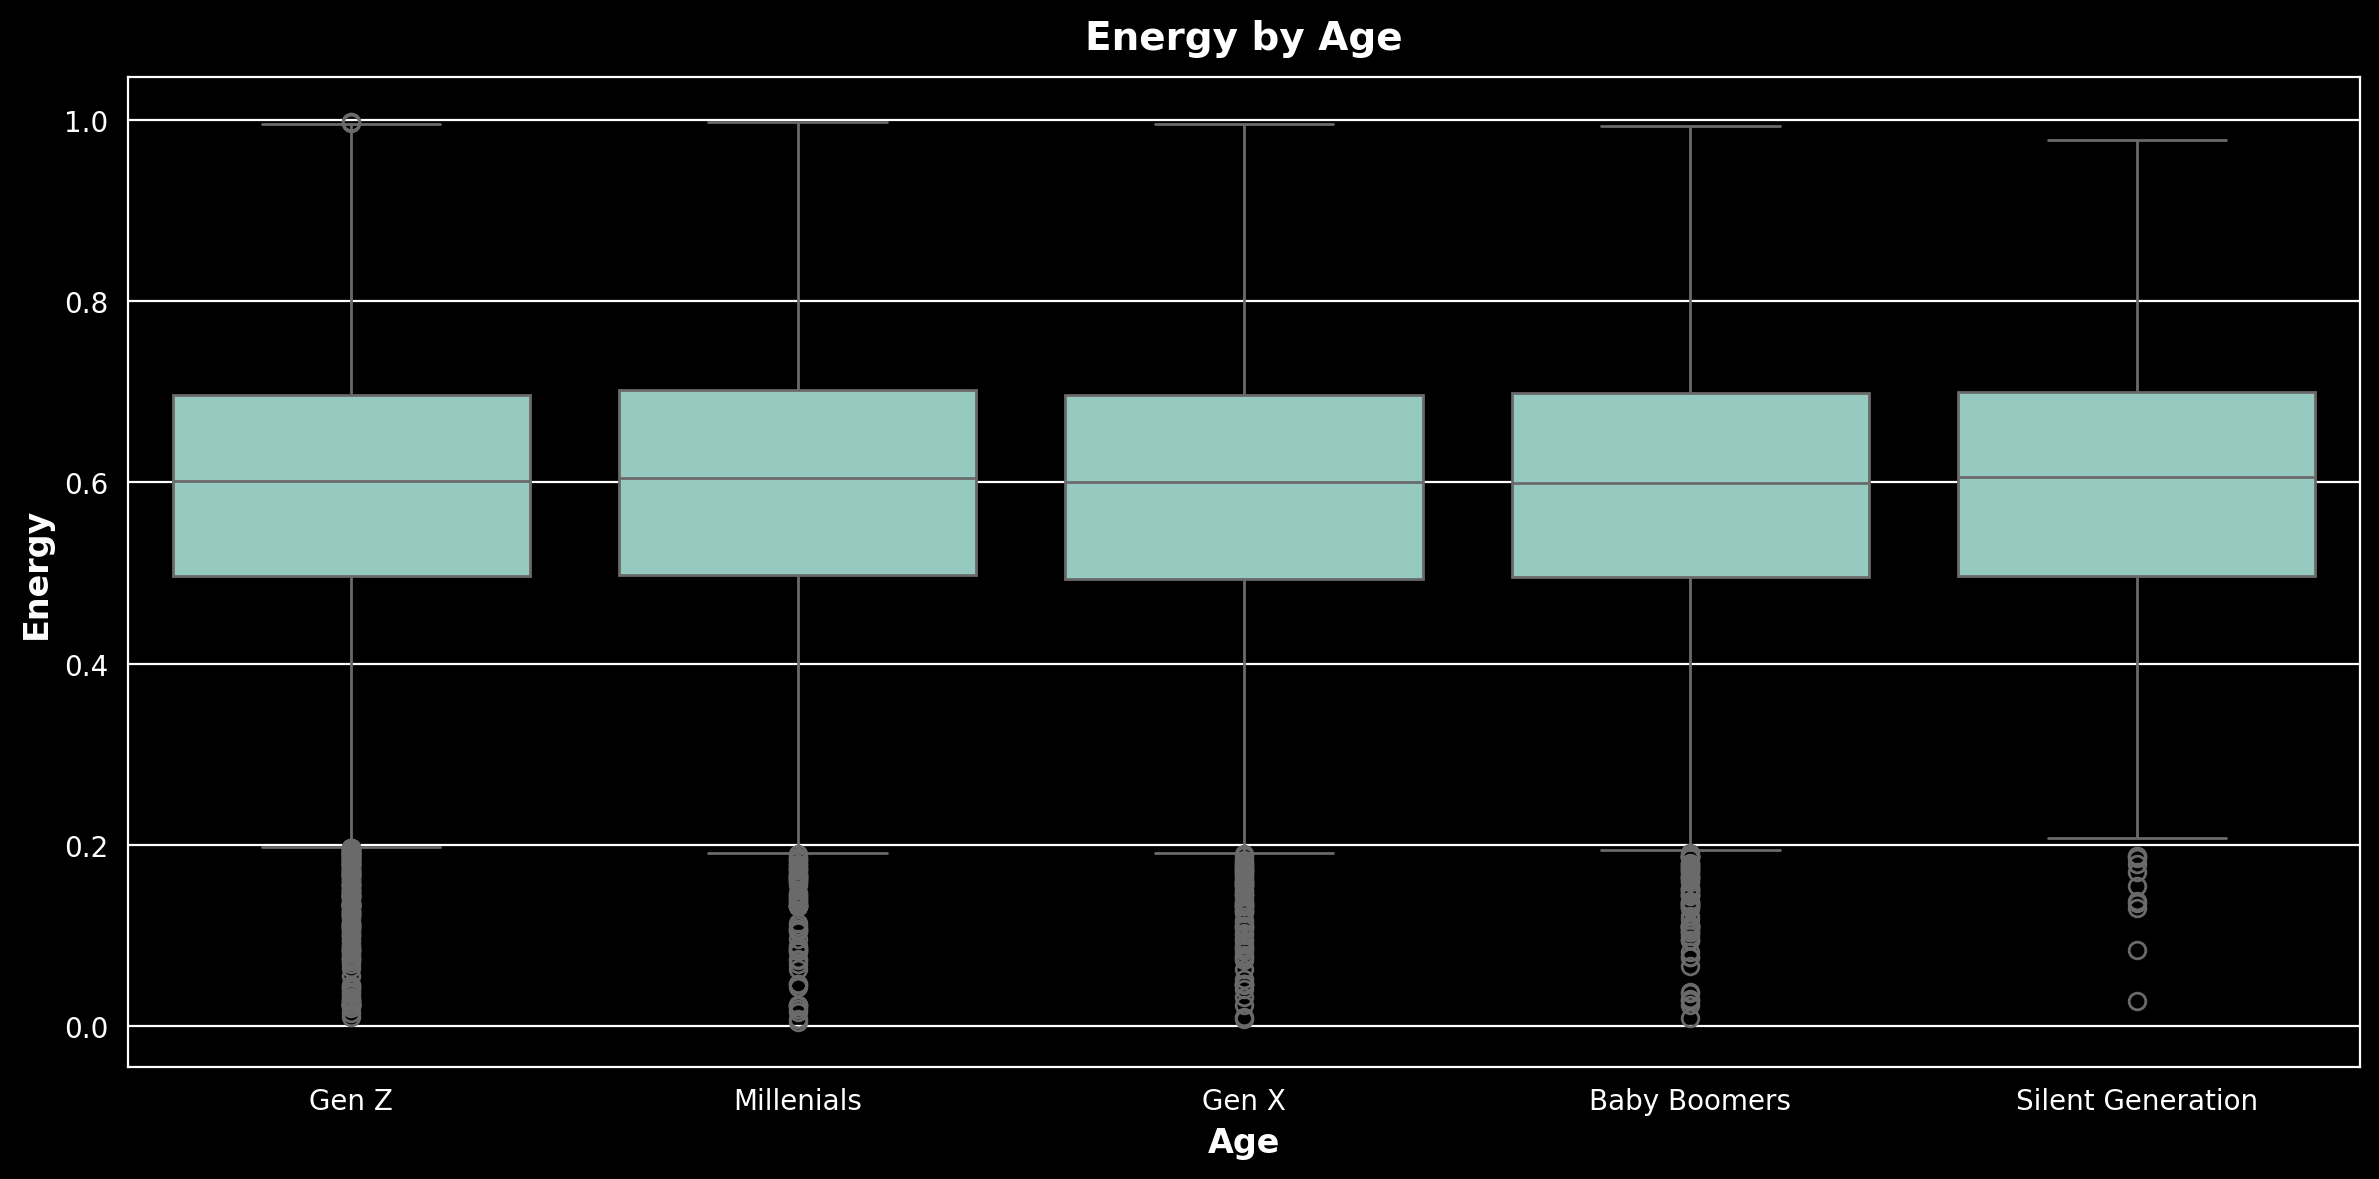

In [38]:
# Visualize energy across different age groups
plt.figure(figsize=(12, 6))
sns.boxplot(x='age_group', y='energy', data=df)
plt.title('Energy by Age')
plt.xlabel('Age')
plt.ylabel('Energy')
plt.show()

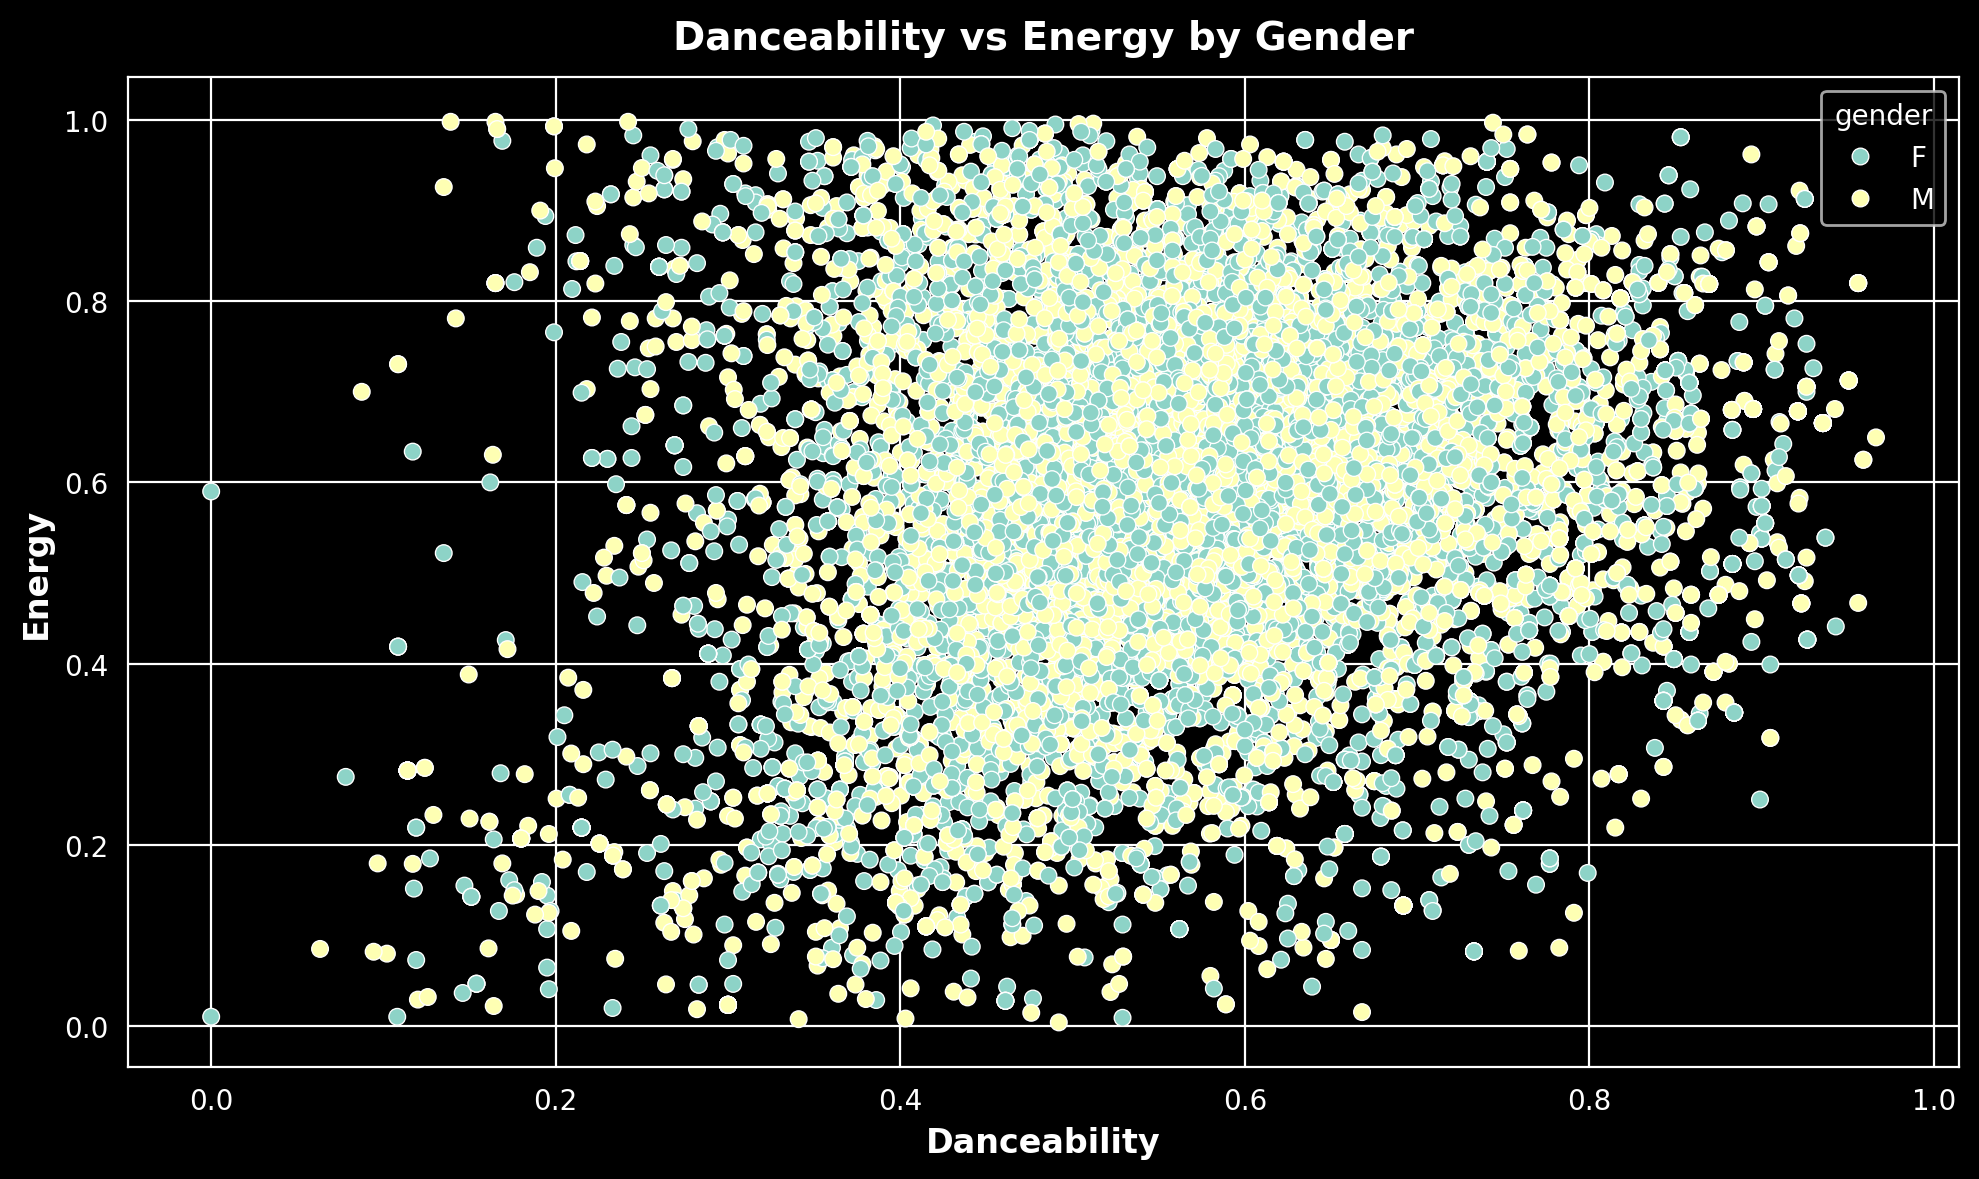

In [39]:
# Scatter plot to explore relationships between danceability and energy
plt.figure(figsize=(10, 6))
sns.scatterplot(x='danceability', y='energy', hue='gender', data=df)
plt.title('Danceability vs Energy by Gender')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.show()

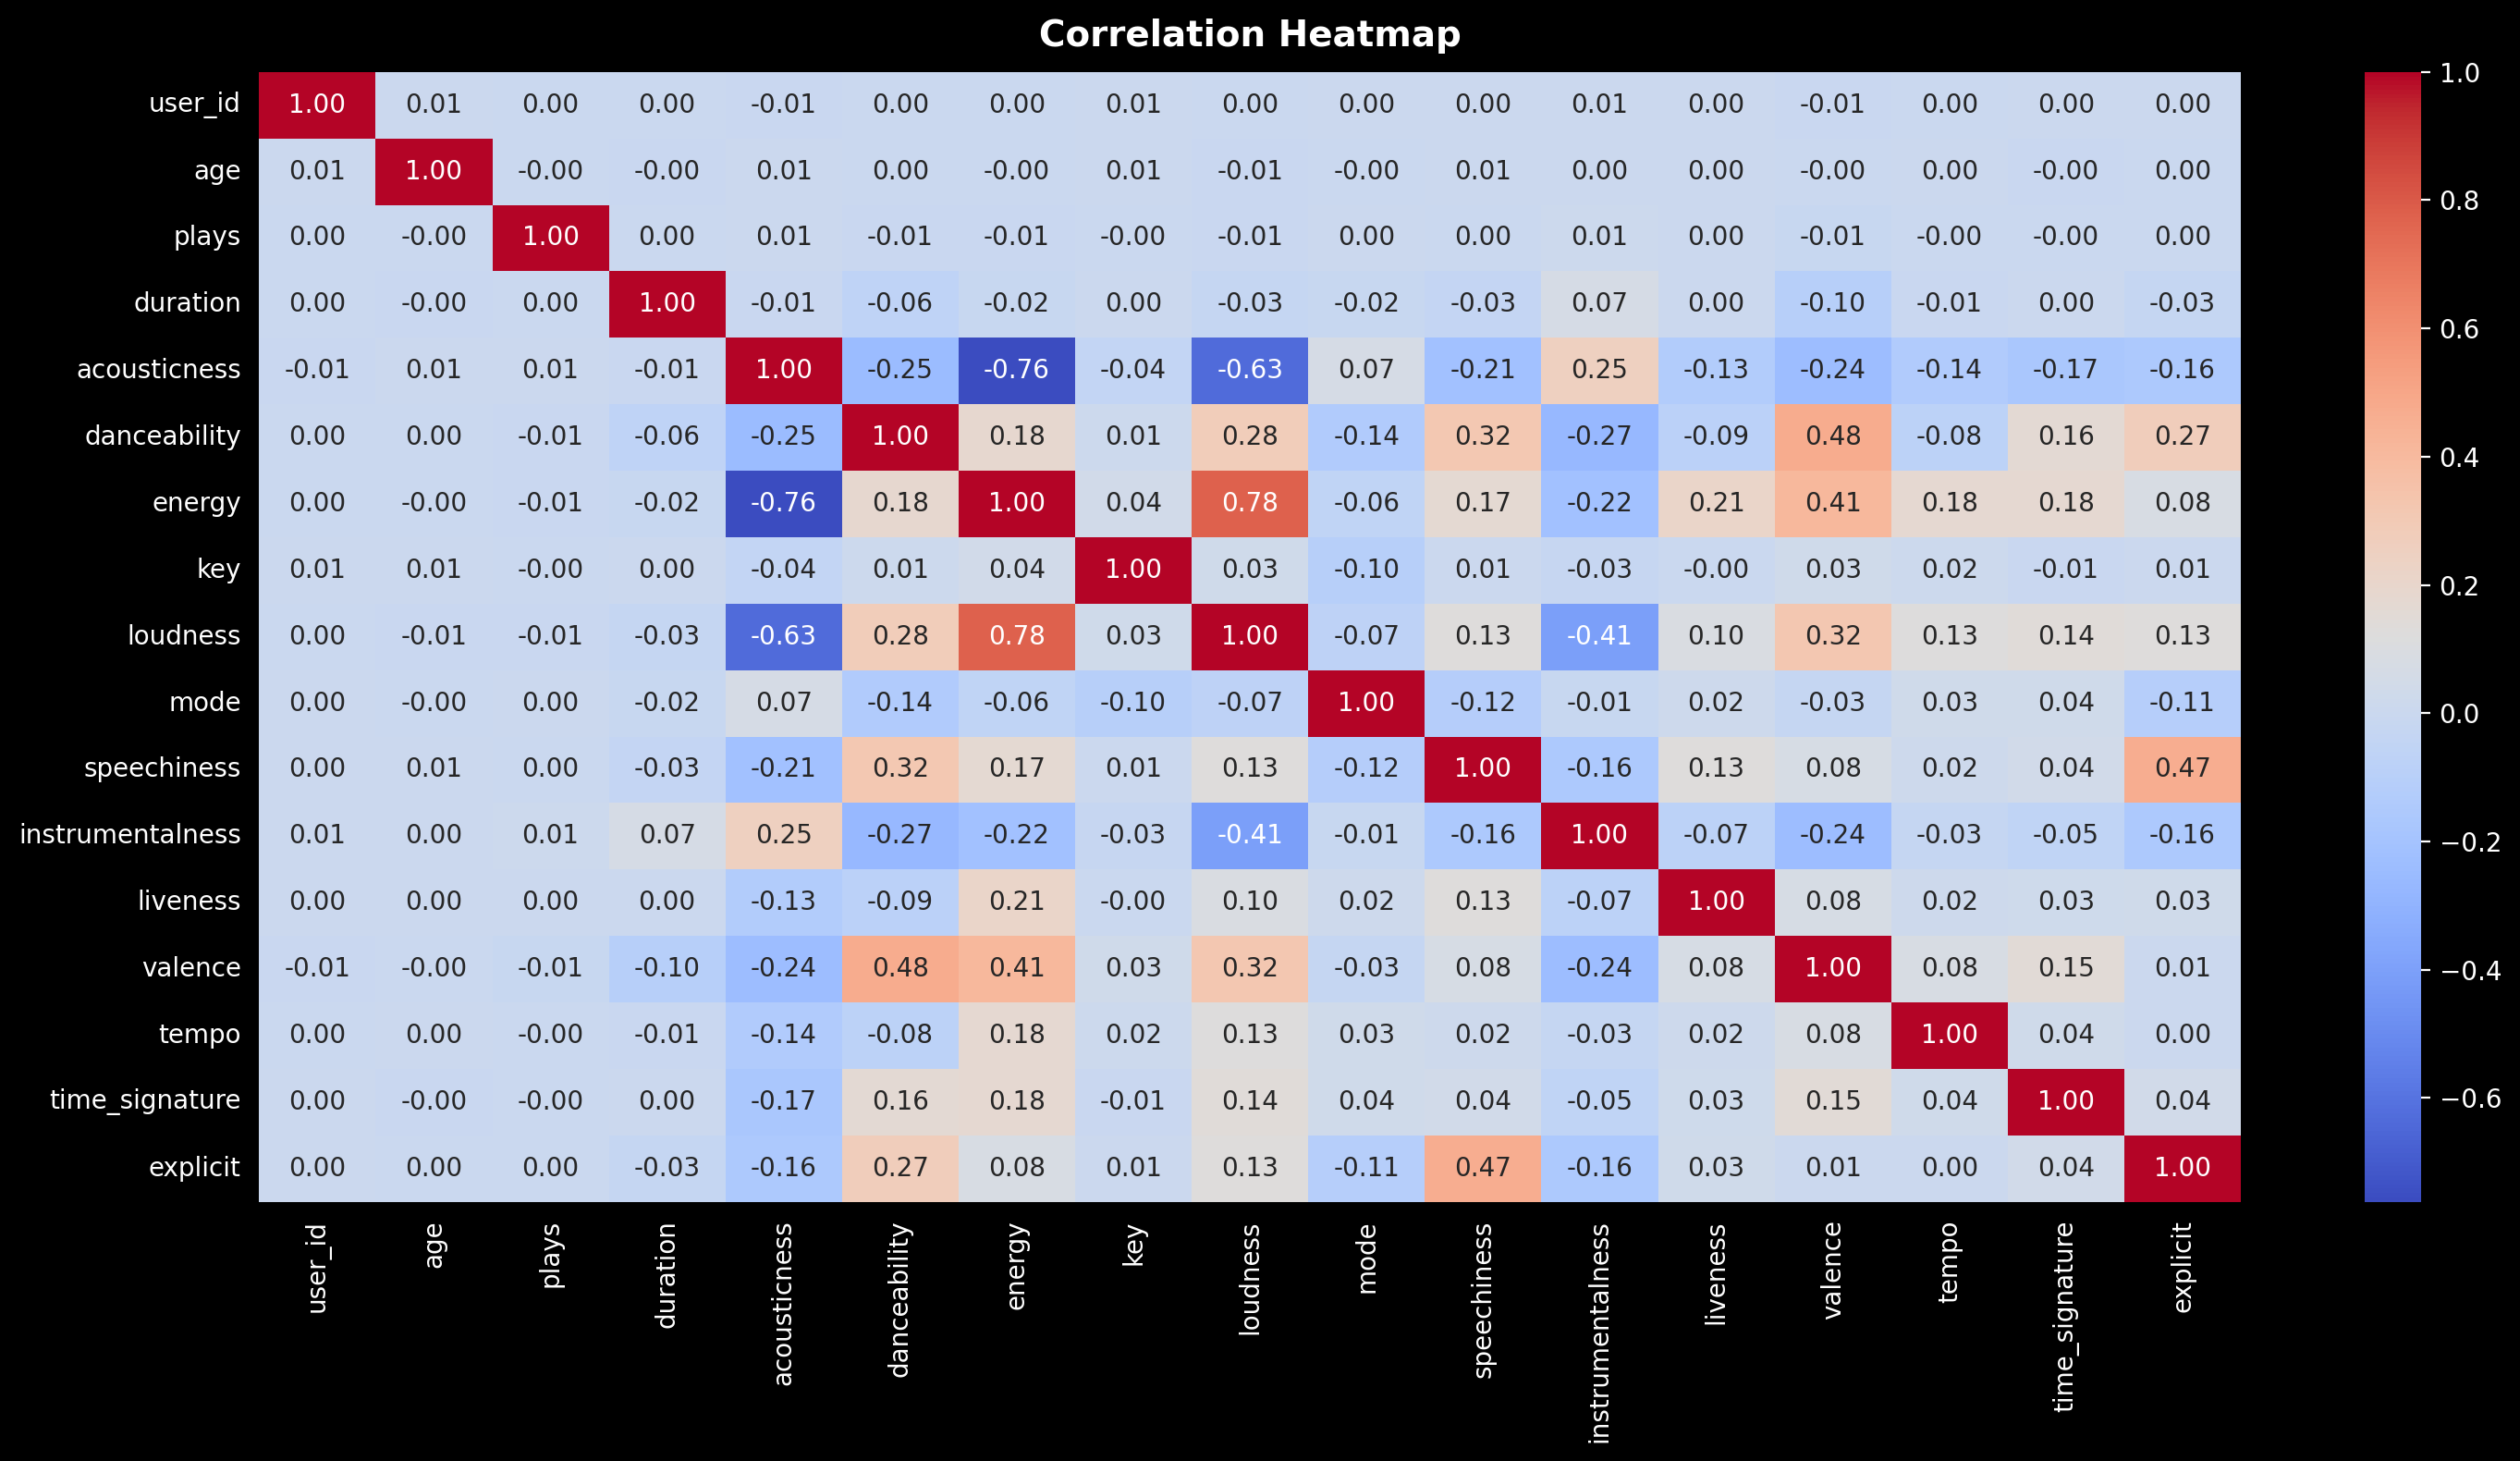

In [40]:
# Plot a correlation heatmap
plt.figure(figsize=(15, 8))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()  # plots the correlation heatmap

## Age based Preferences

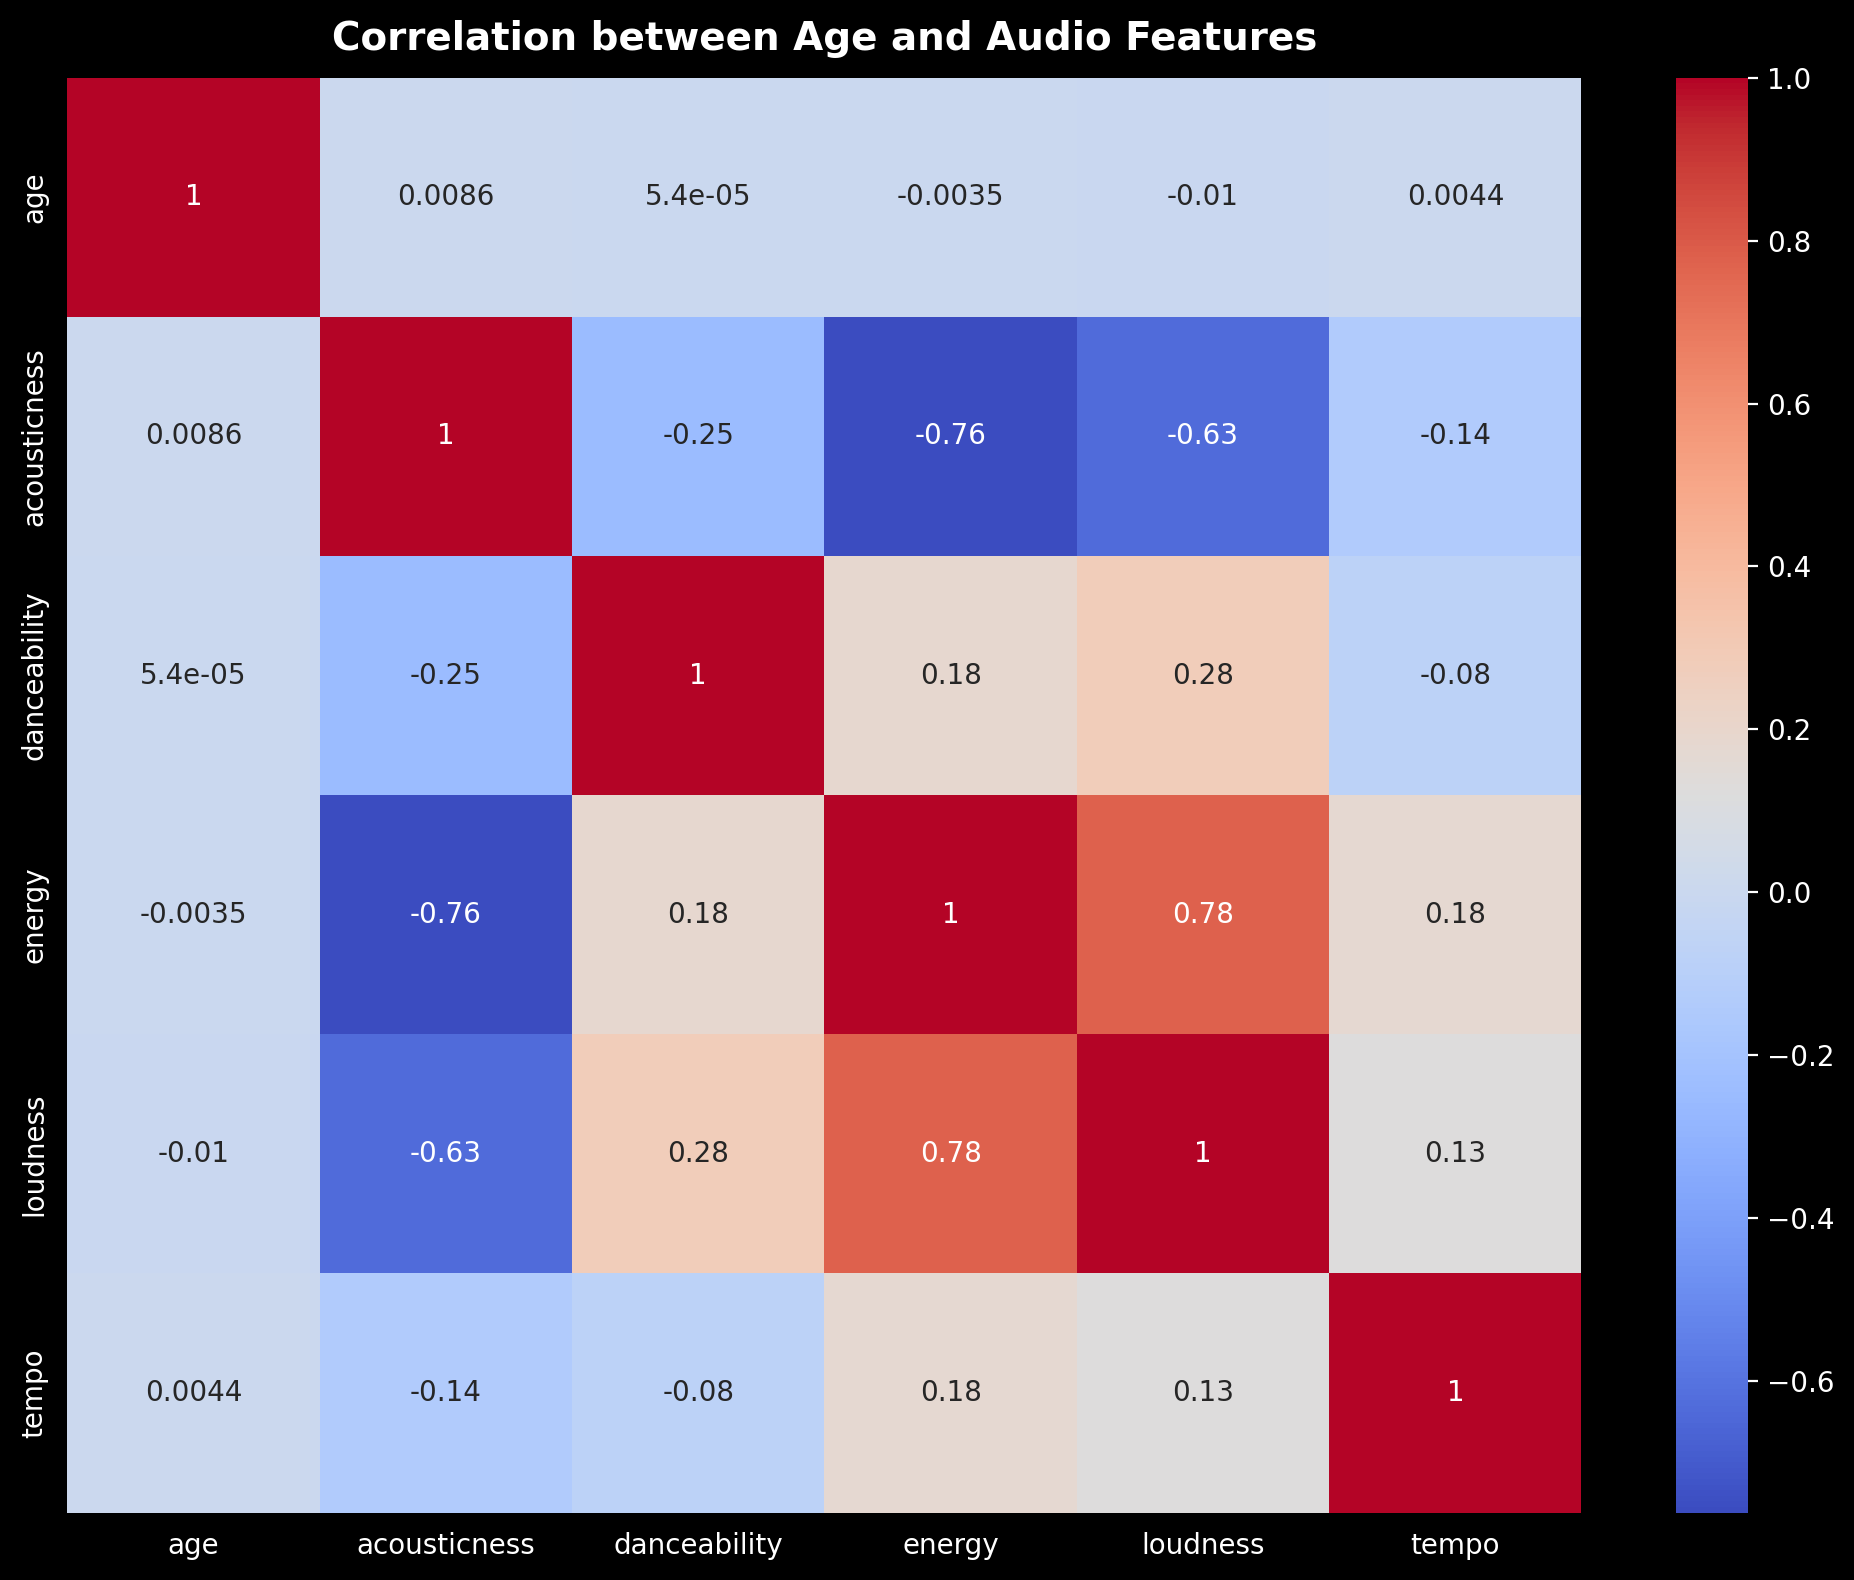

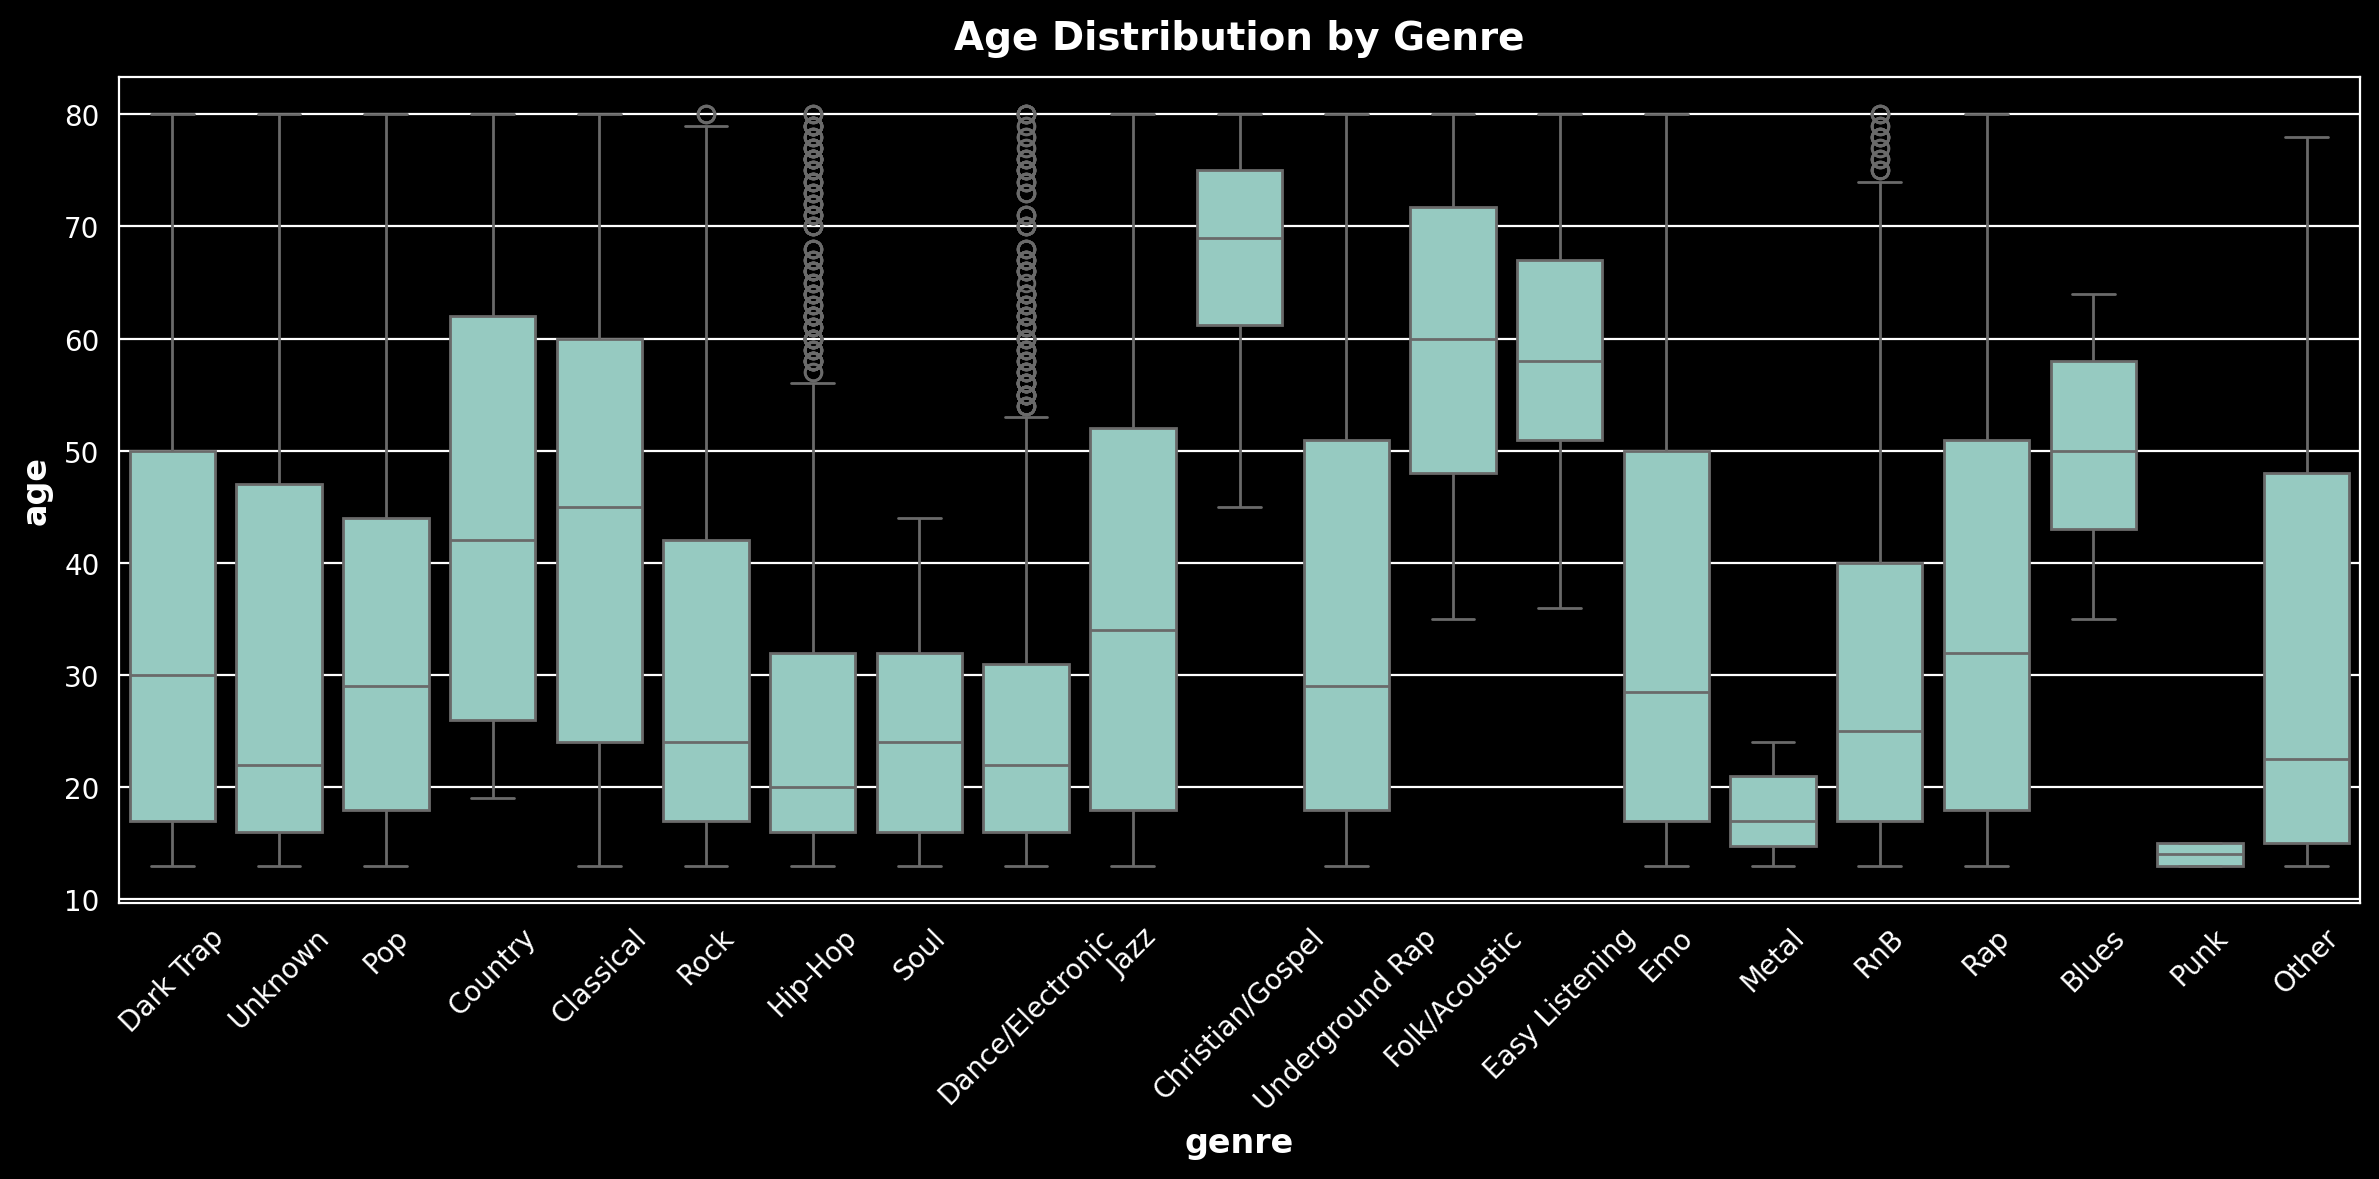

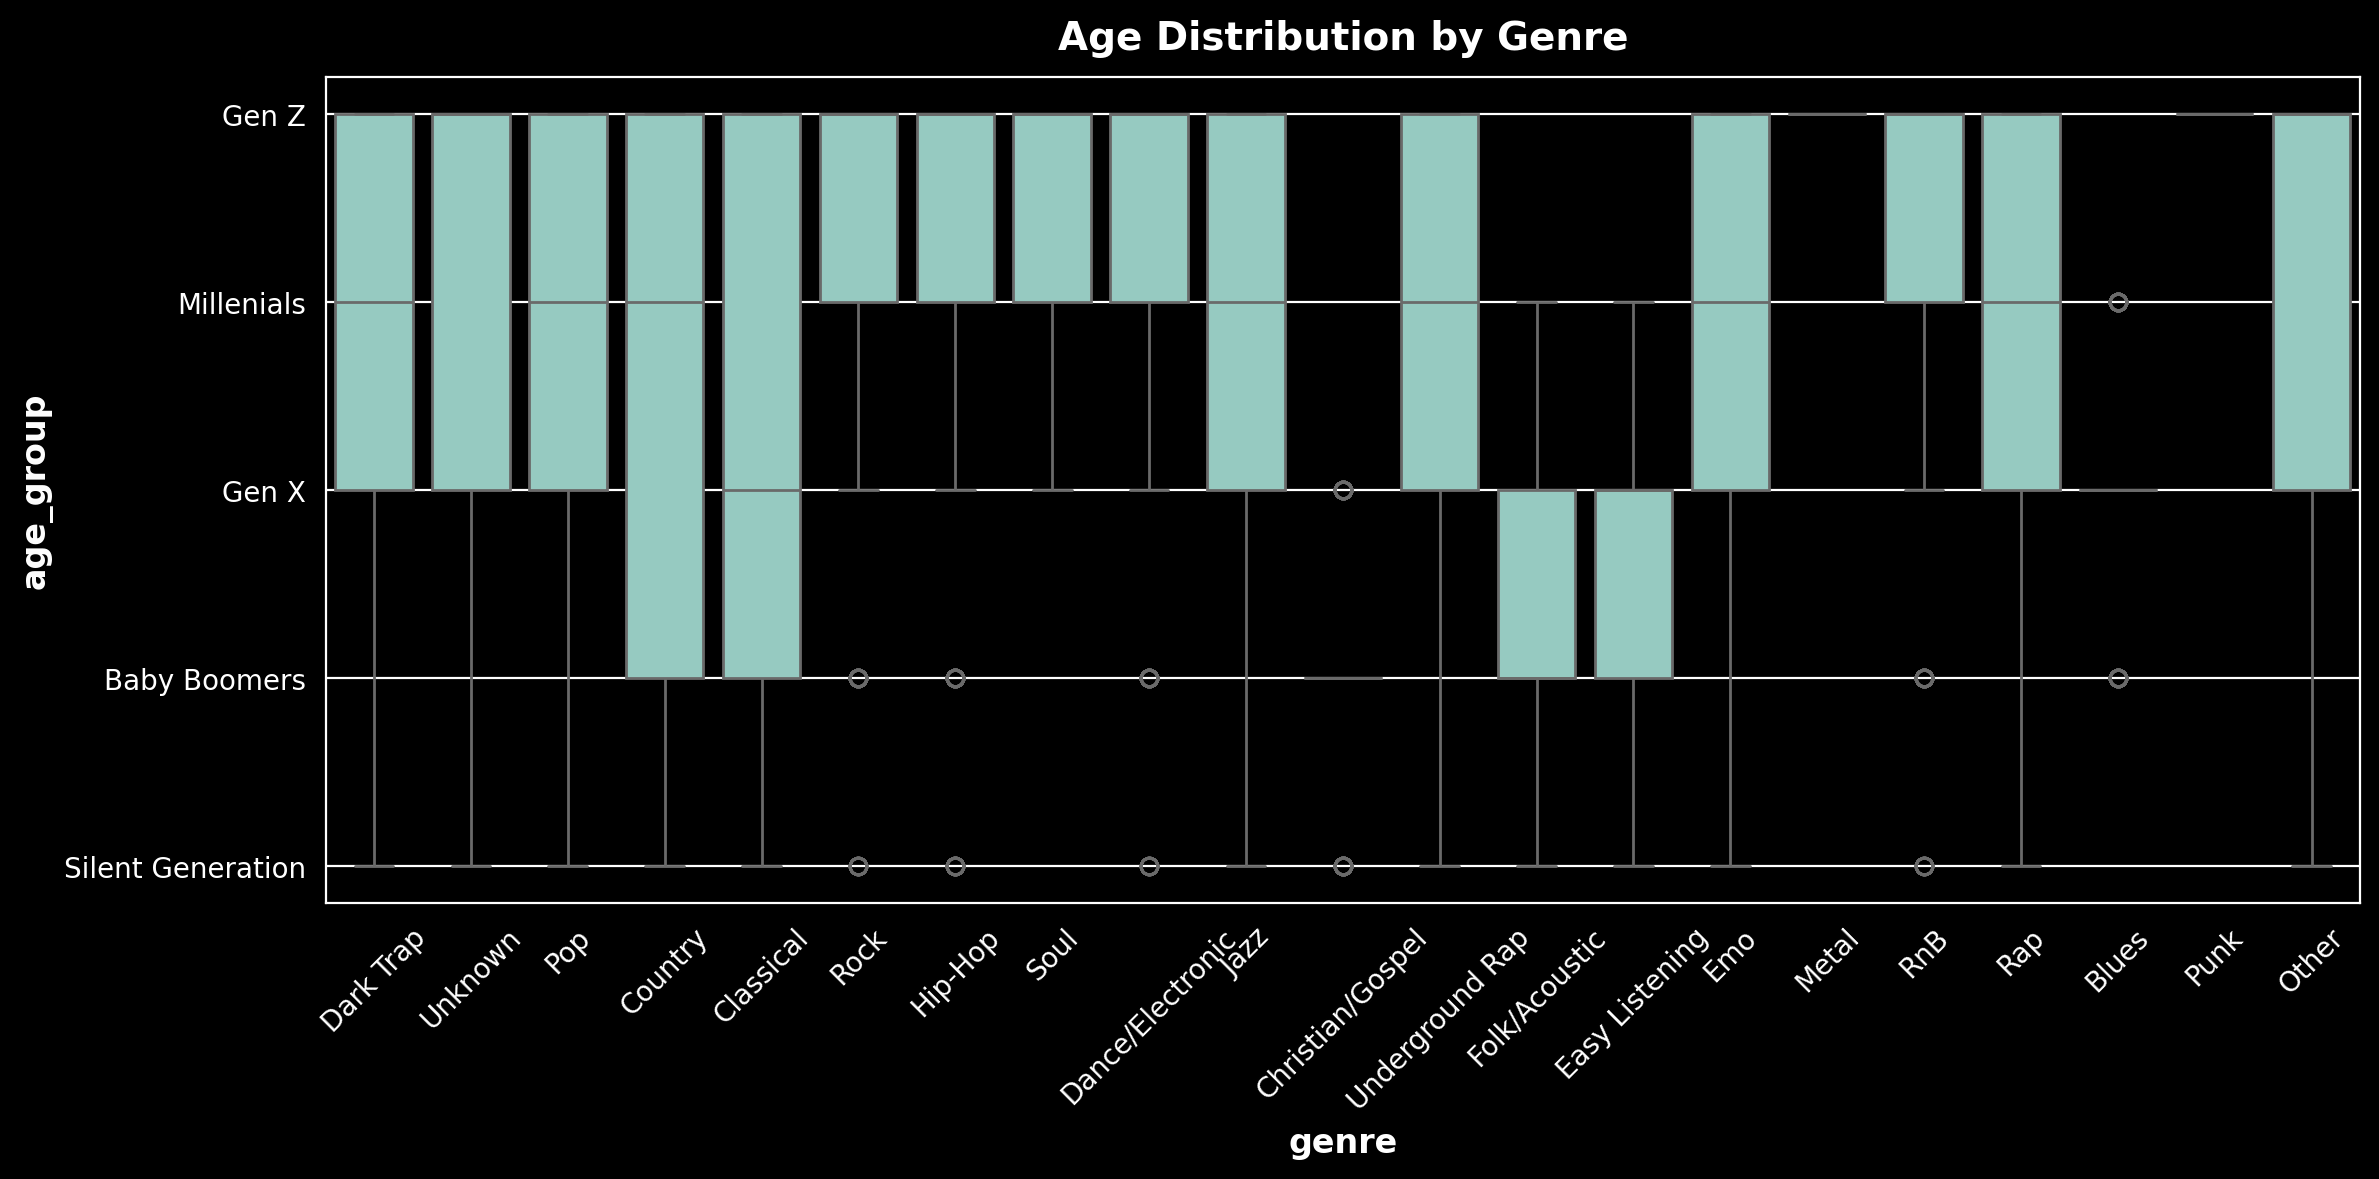

In [41]:
# Correlation between age and audio features
audio_features = ['acousticness', 'danceability', 'energy', 'loudness', 'tempo']
correlation_matrix = df[['age'] + audio_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Age and Audio Features')
plt.show()

# Age vs Genre preferences
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='age', data=df)
plt.title('Age Distribution by Genre')
plt.xticks(rotation=45)
plt.show()

# Age group vs Genre preferences
plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='age_group', data=df)
plt.title('Age Distribution by Genre')
plt.xticks(rotation=45)
plt.show()

## Gender-based preferences

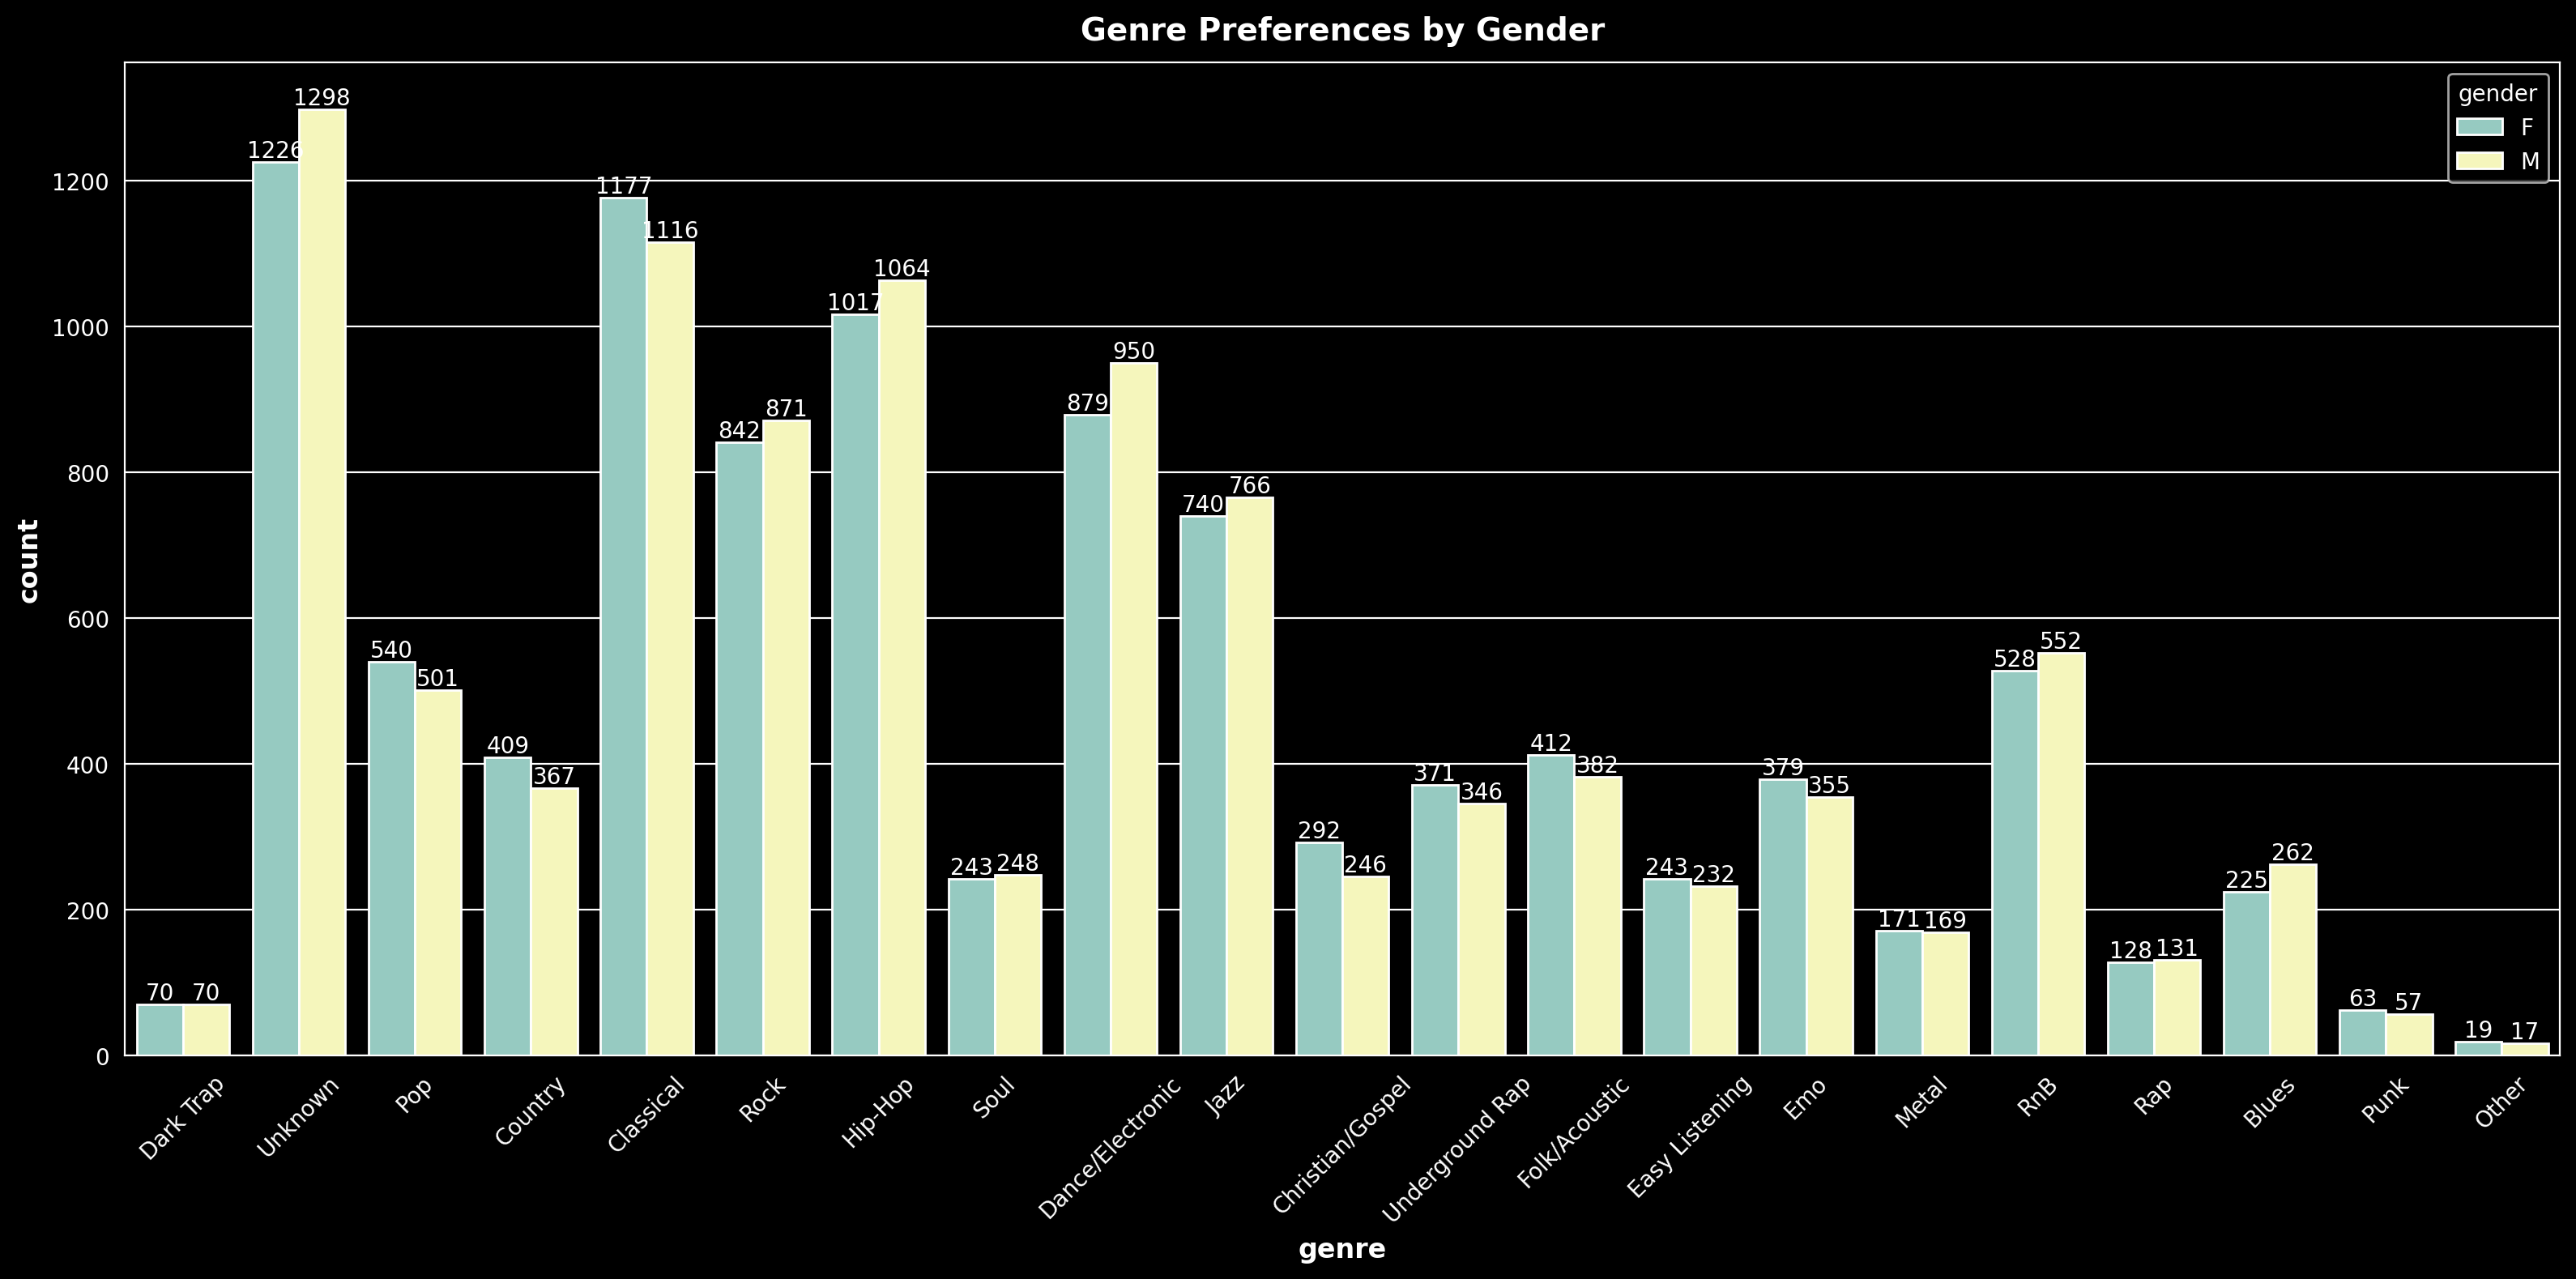

acousticness:
t-statistic = 0.960
p-value = 0.337
danceability:
t-statistic = -1.419
p-value = 0.156
energy:
t-statistic = -0.353
p-value = 0.724
loudness:
t-statistic = -0.467
p-value = 0.640
tempo:
t-statistic = -0.357
p-value = 0.721


In [42]:
# Gender vs Genre preferences
fig, ax = plt.subplots(figsize=(16, 8))
sns.countplot(x='genre', hue='gender', data=df, ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f")
plt.title('Genre Preferences by Gender')
plt.xticks(rotation=45)
plt.show()

# Gender vs Audio Features
for feature in audio_features:
    t_stat, p_value = stats.ttest_ind(df[df['gender'] == 'M'][feature],
                                      df[df['gender'] == 'F'][feature])
    print(f"{feature}:\nt-statistic = {t_stat:.3f}\np-value = {p_value:.3f}\n{'='* 60}")

## Age and Explicit Content

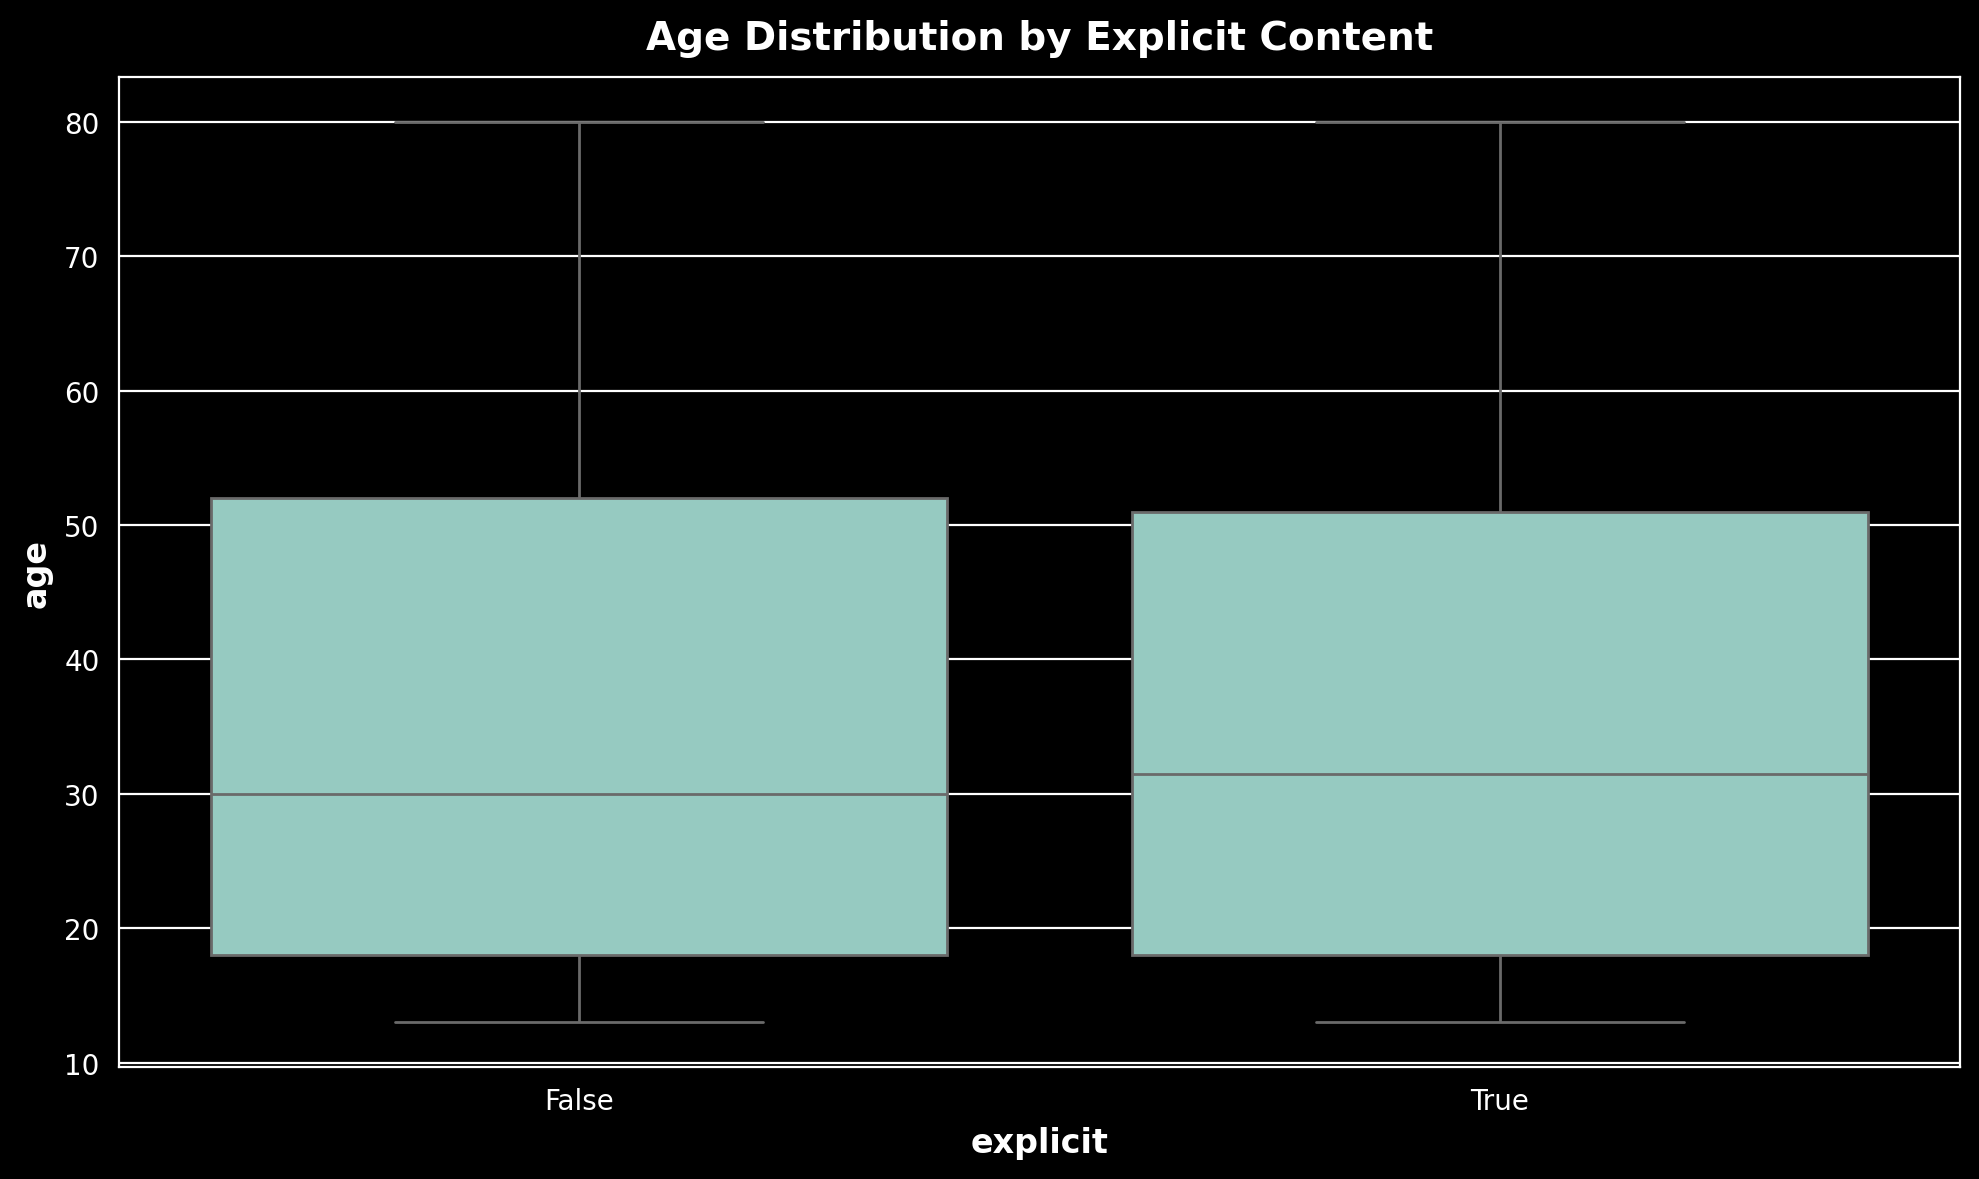

Chi-square statistic: 4.774535222086405
p-value: 0.311


In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='explicit', y='age', data=df)
plt.title('Age Distribution by Explicit Content')
plt.show()

# Chi-square test
contingency_table = pd.crosstab(pd.cut(df['age'], bins=5), df['explicit'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}\np-value: {p_value:.3f}")

## Genre and audio features

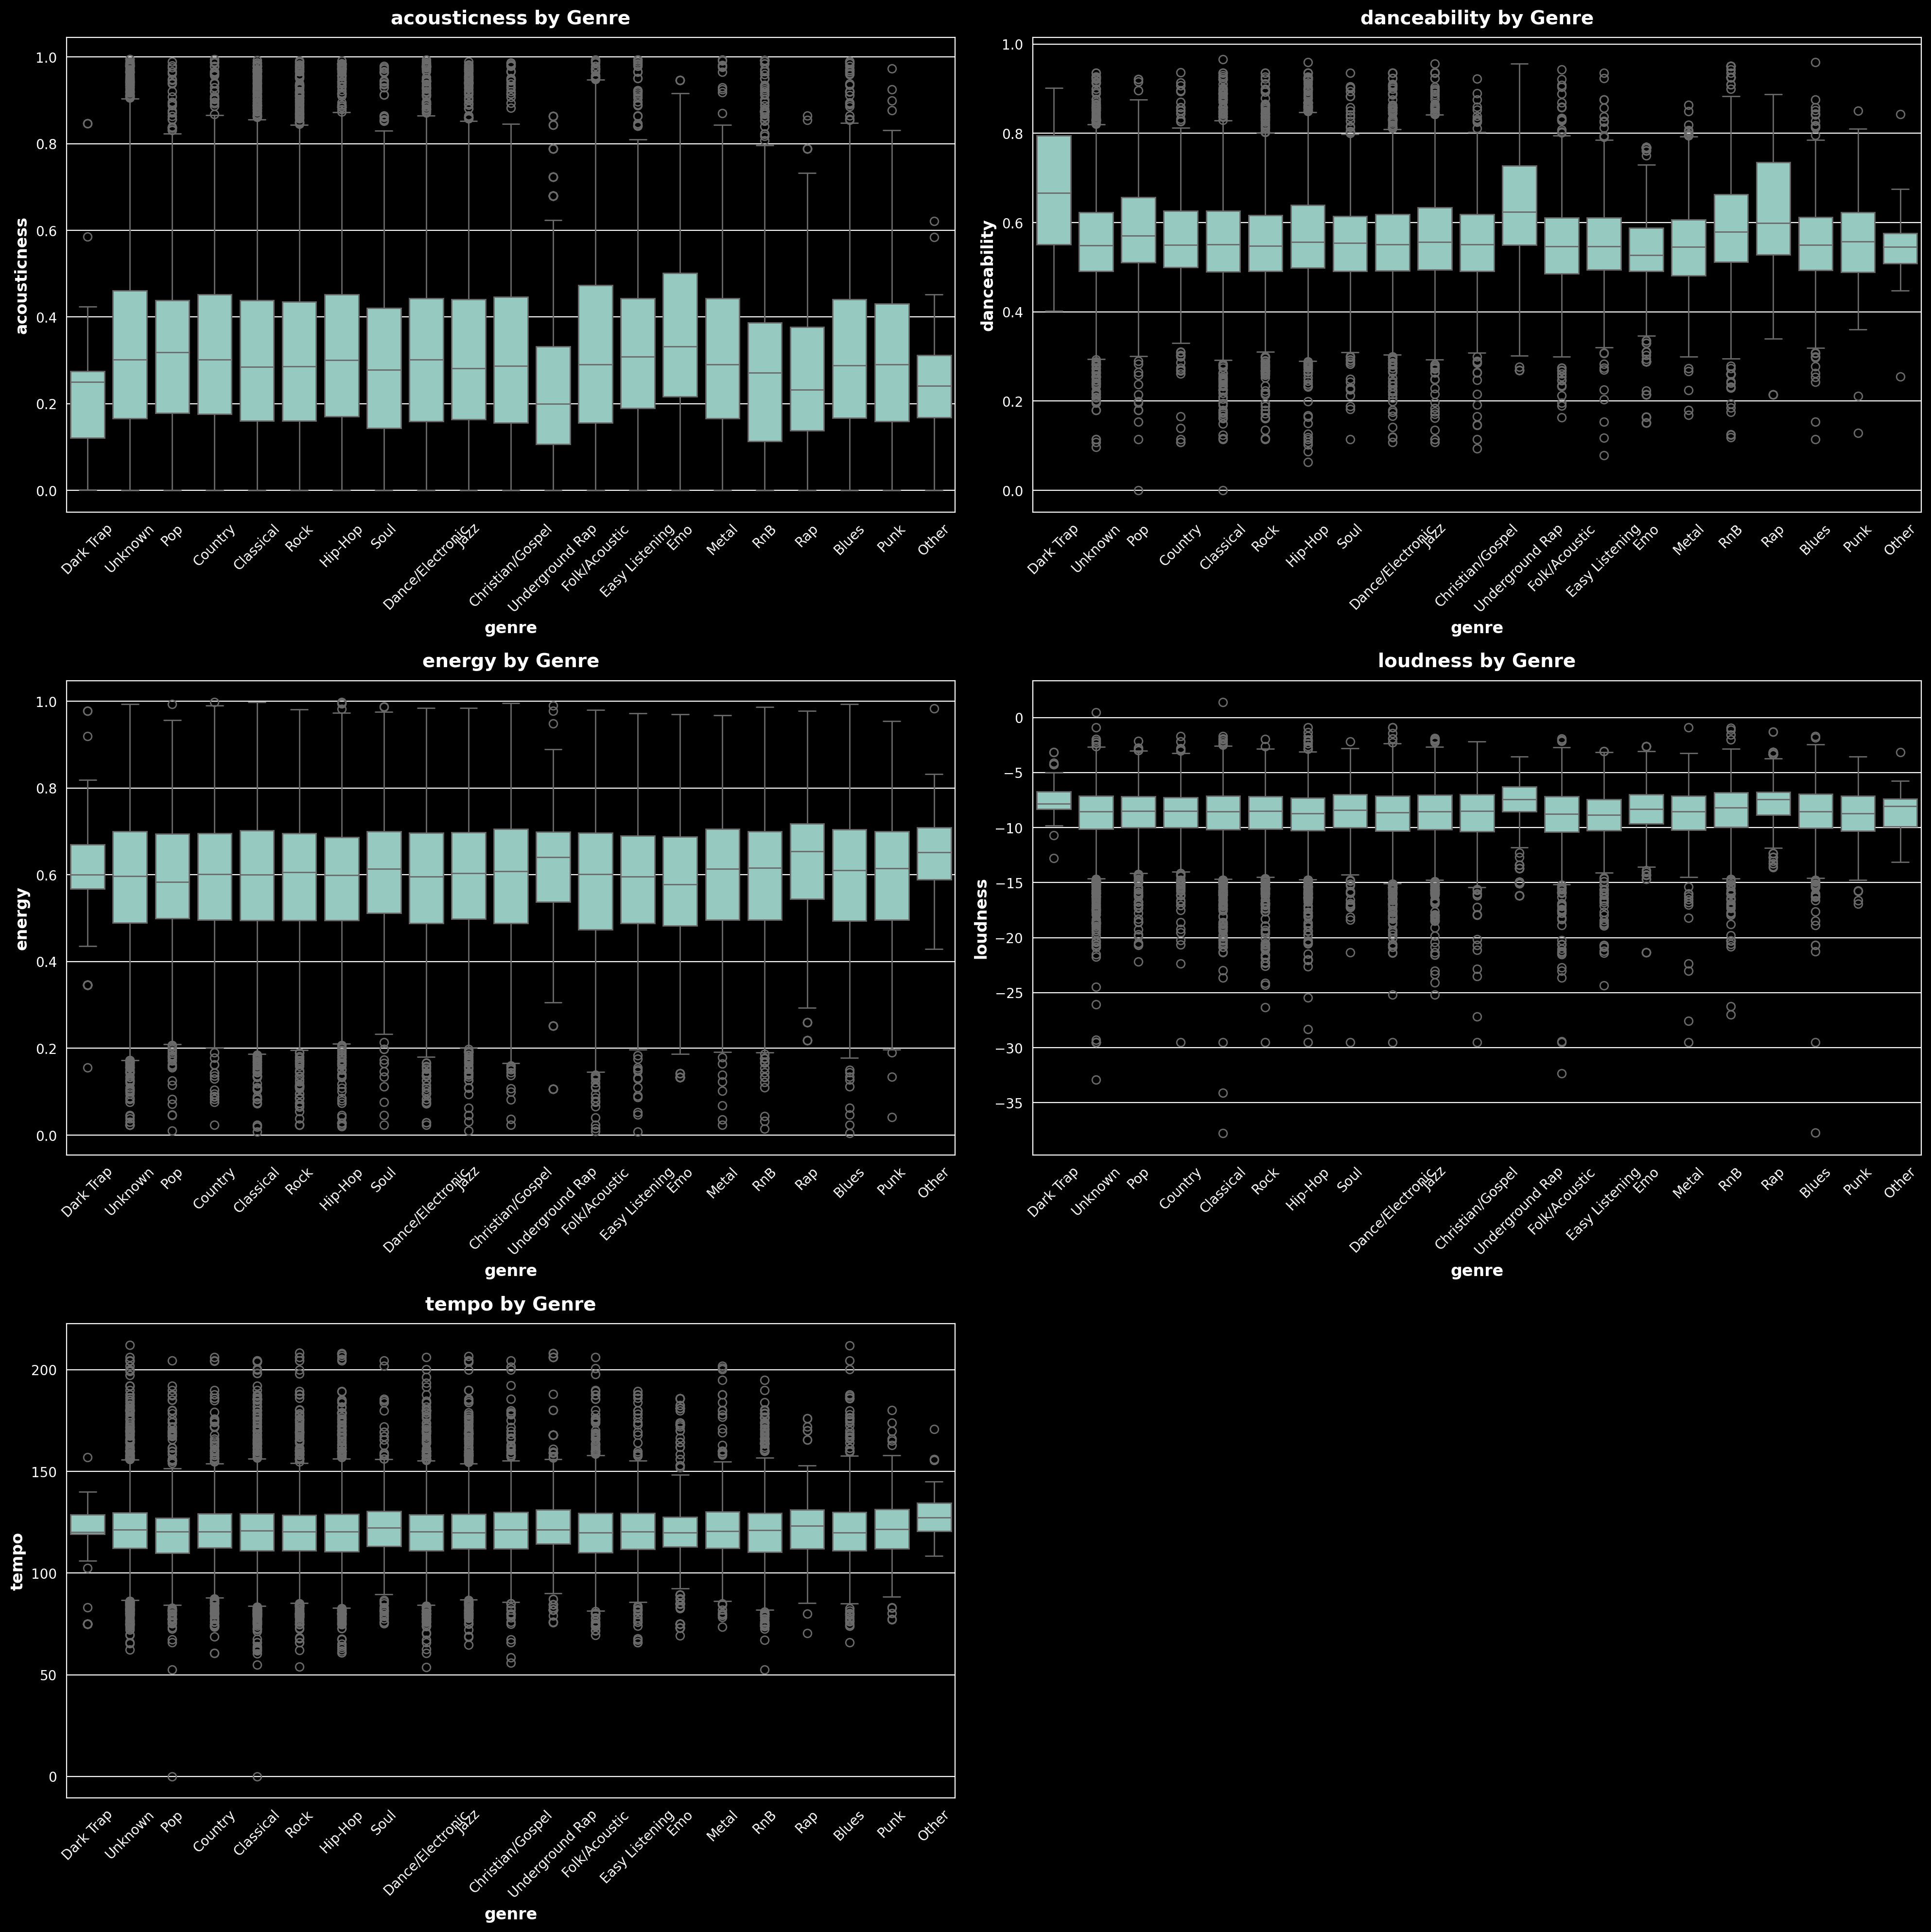

In [44]:
plt.figure(figsize=(20, 20))
for i, feature in enumerate(audio_features, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='genre', y=feature, data=df)
    plt.title(f'{feature} by Genre')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Age and Release Date

## Fix inconsistencies with Date column

In [45]:
df['release_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 19974 entries, 0 to 19973
Series name: release_date
Non-Null Count  Dtype 
--------------  ----- 
19974 non-null  object
dtypes: object(1)
memory usage: 156.2+ KB


In [46]:
df['release_date'] = pd.to_datetime(df['release_date'],errors='coerce',format="%Y-%m-%d")

In [47]:
df['release_date'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 19974 entries, 0 to 19973
Series name: release_date
Non-Null Count  Dtype         
--------------  -----         
14646 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 156.2 KB


In [48]:
df['release_date'].isnull().sum()


5328

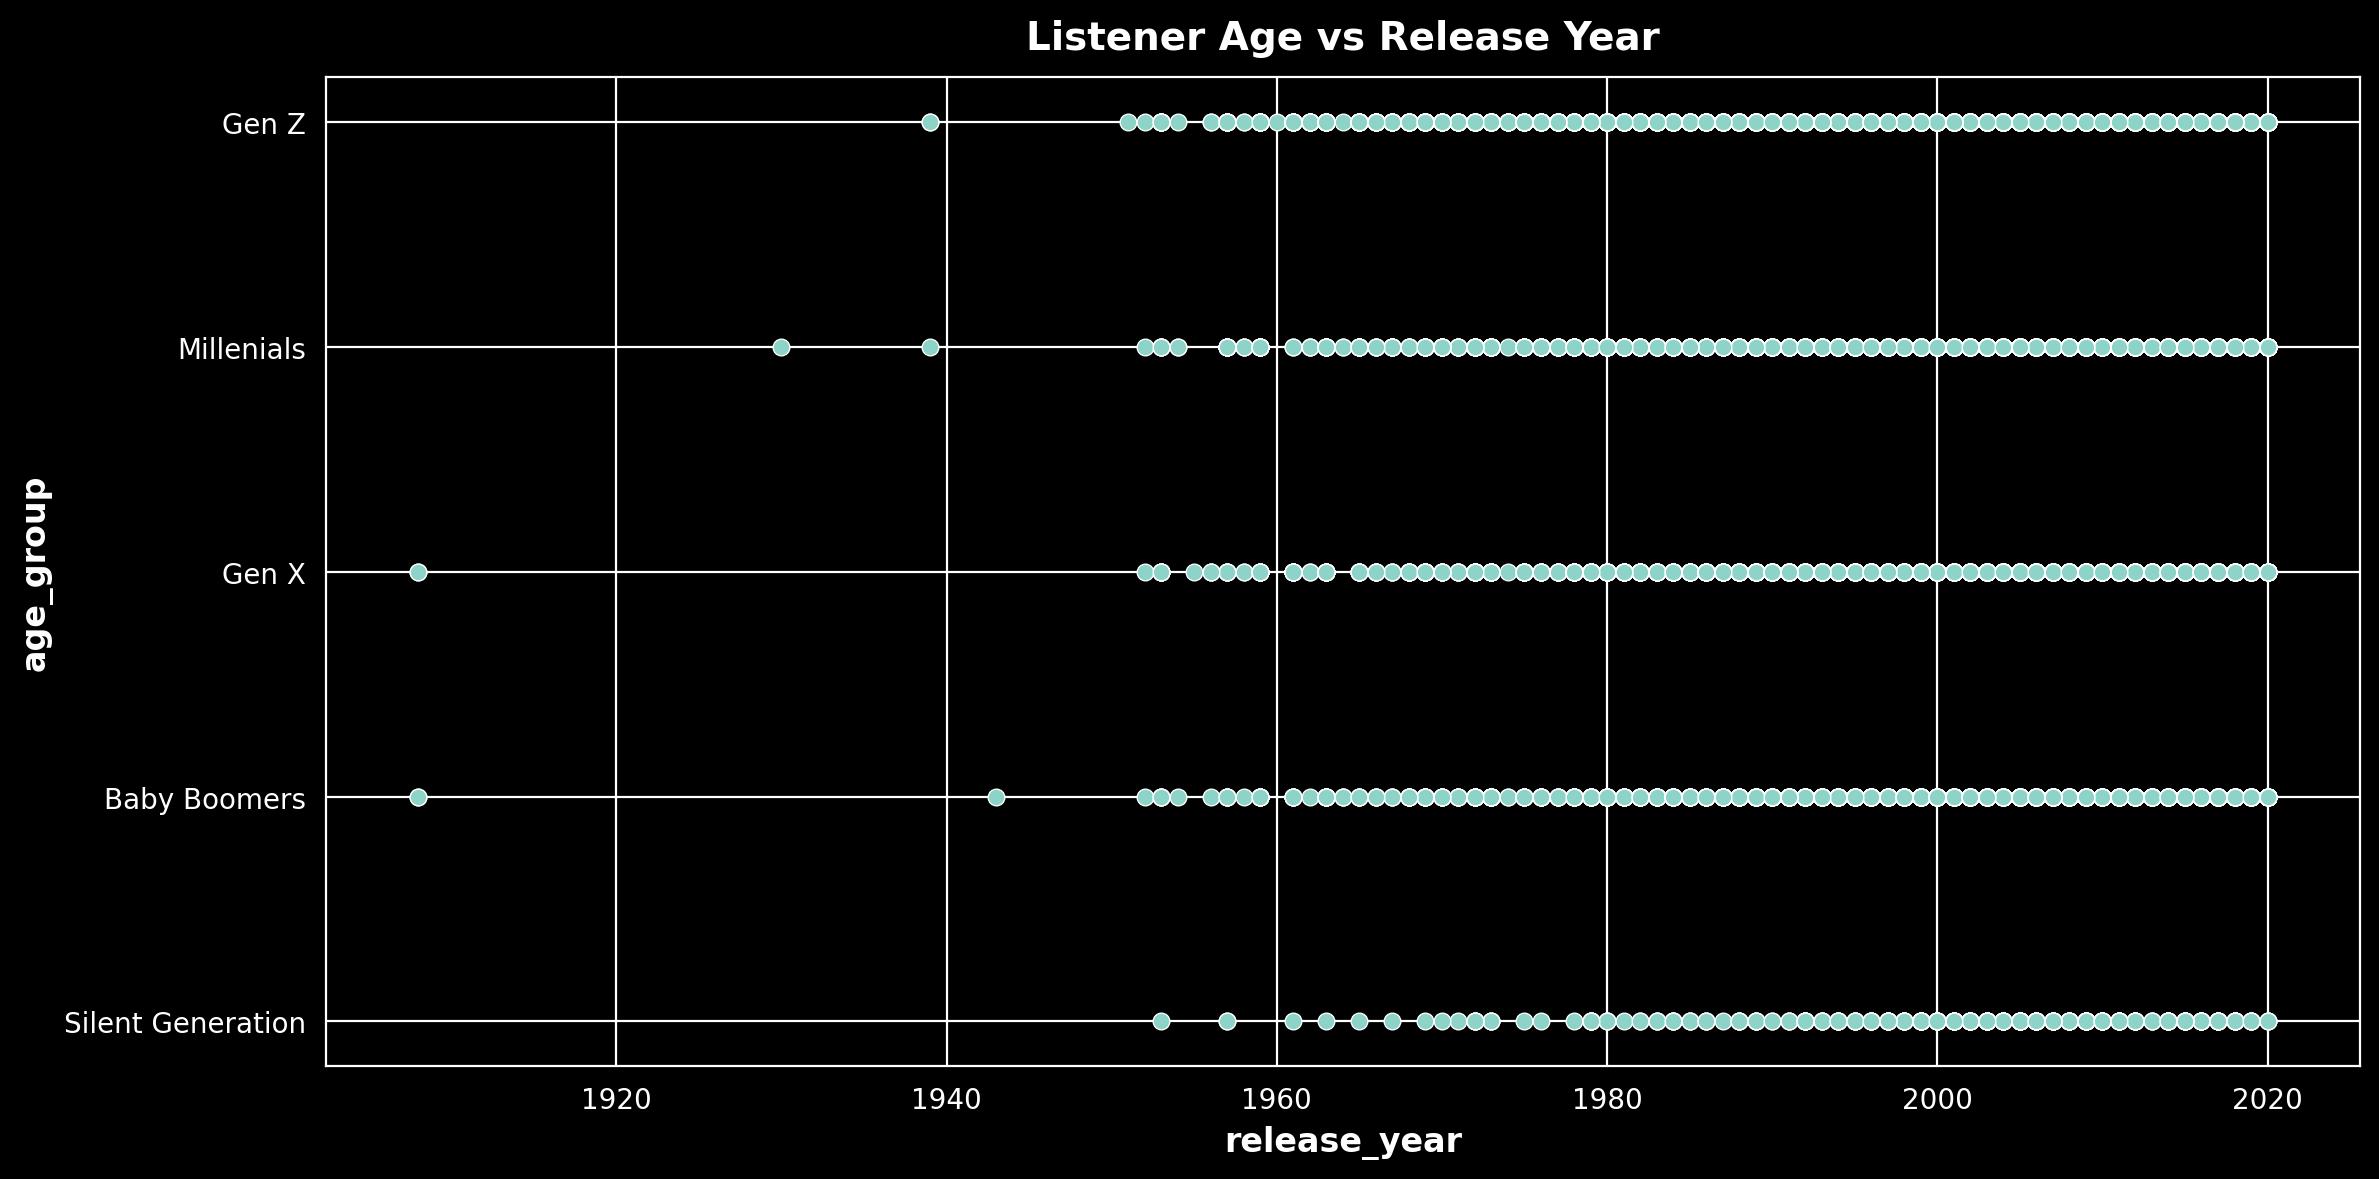

Correlation between age and release year: 0.010


In [49]:
df['release_year'] = df['release_date'].dt.year
plt.figure(figsize=(12, 6))
sns.scatterplot(x='release_year', y='age_group', data=df)
plt.title('Listener Age vs Release Year')
plt.show()

correlation = df['age'].corr(df['release_year'])
print(f"Correlation between age and release year: {correlation:.3f}")

## Gender and artist preferences

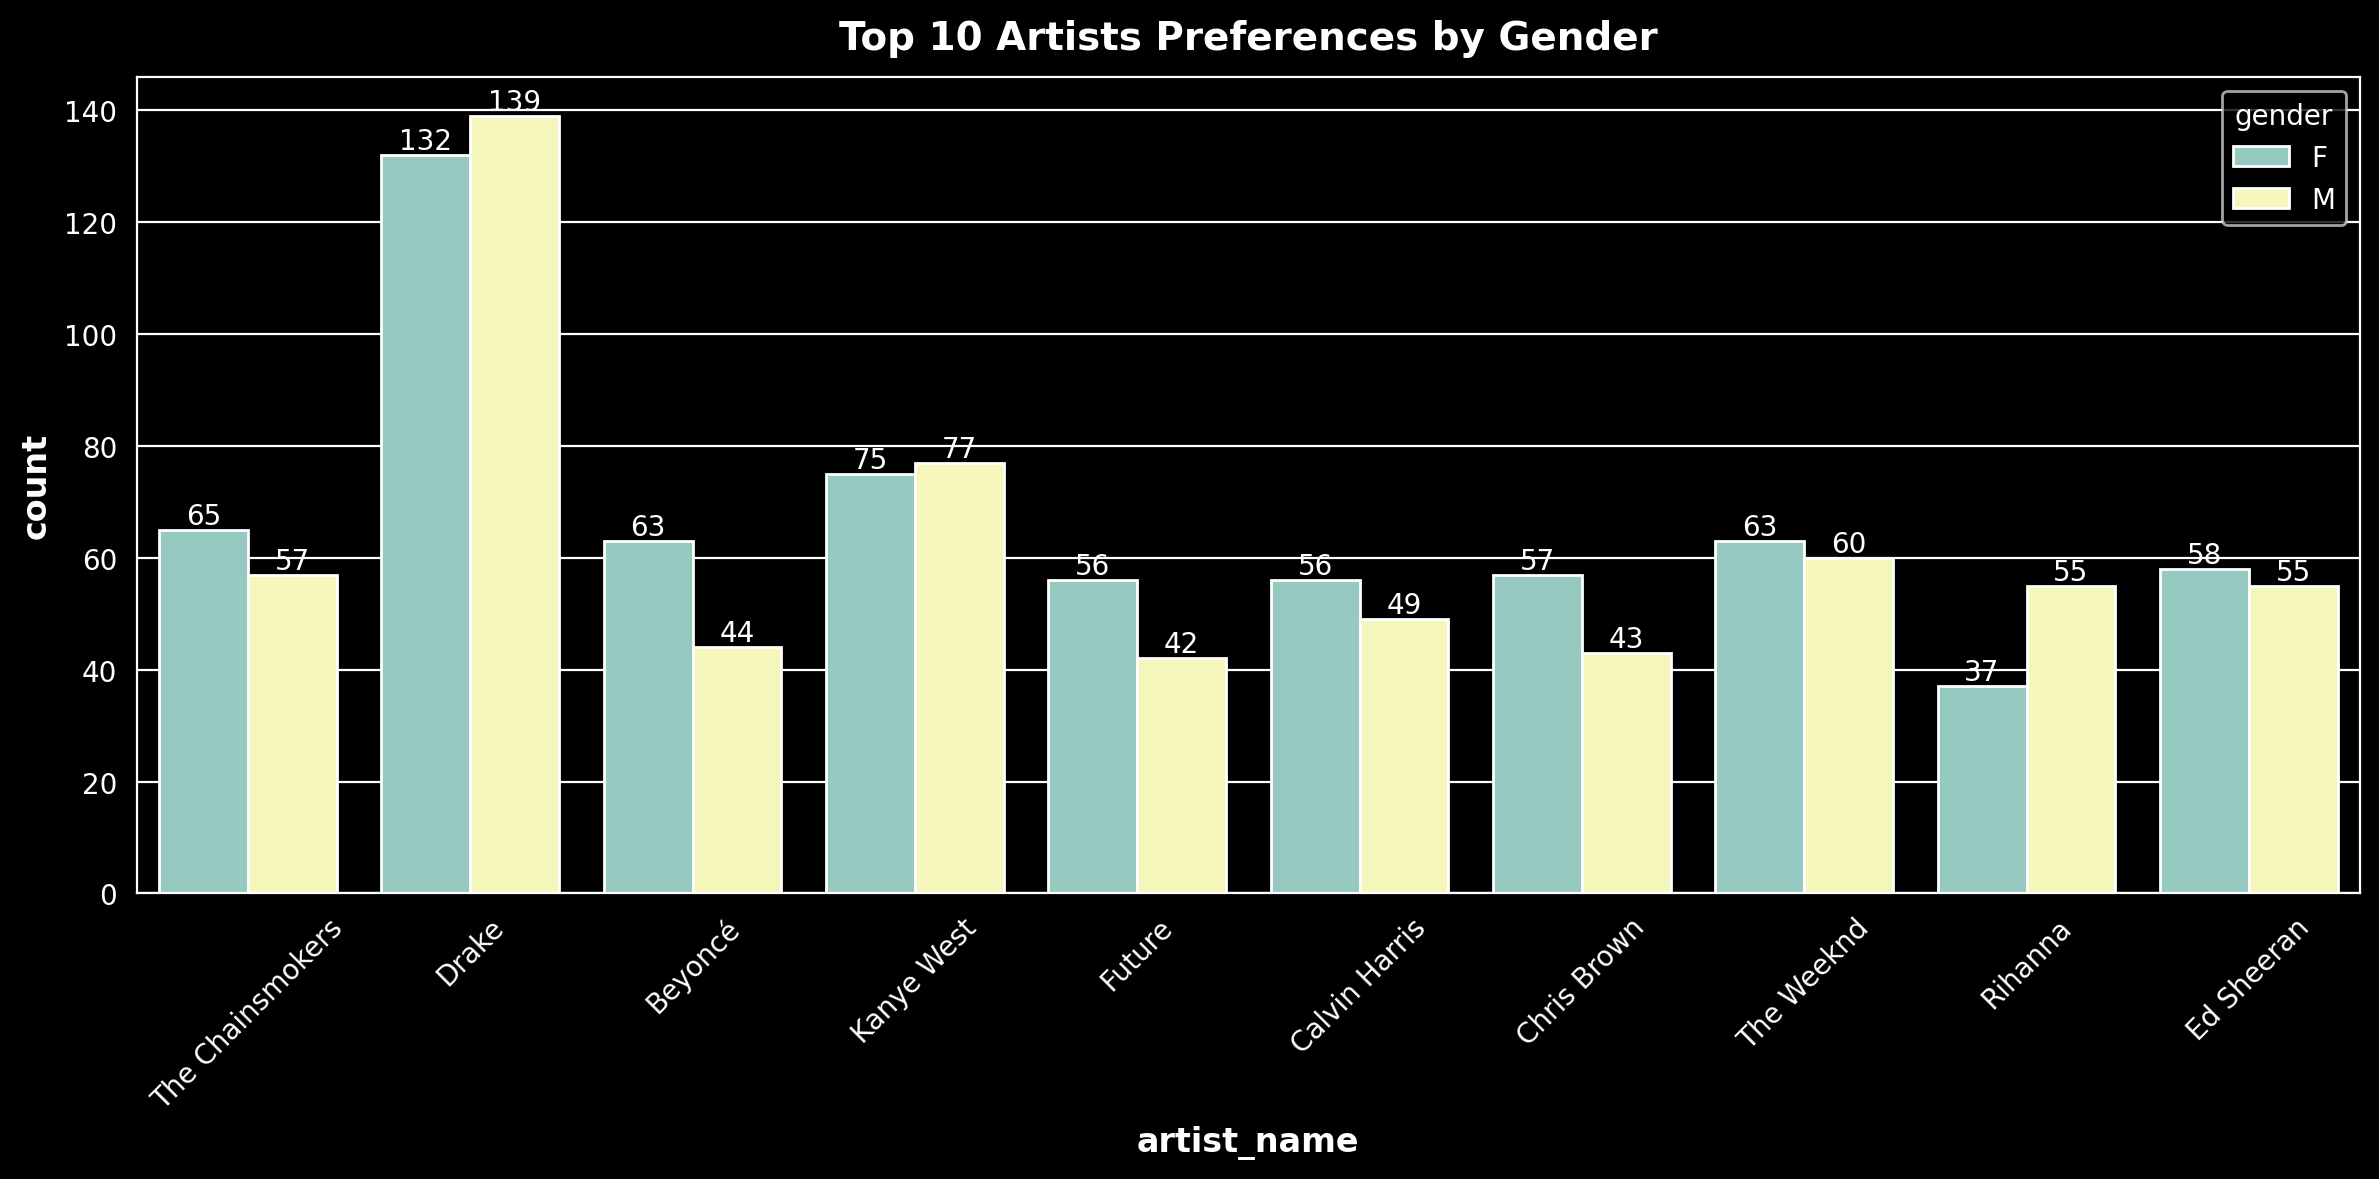

In [50]:
top_artists = df['artist_name'].value_counts().head(10).index
artist_gender_data = df[df['artist_name'].isin(top_artists)]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x='artist_name', hue='gender', data=artist_gender_data)
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f")
plt.title('Top 10 Artists Preferences by Gender')
plt.xticks(rotation=45)
plt.show()

## Age and tempo preferences

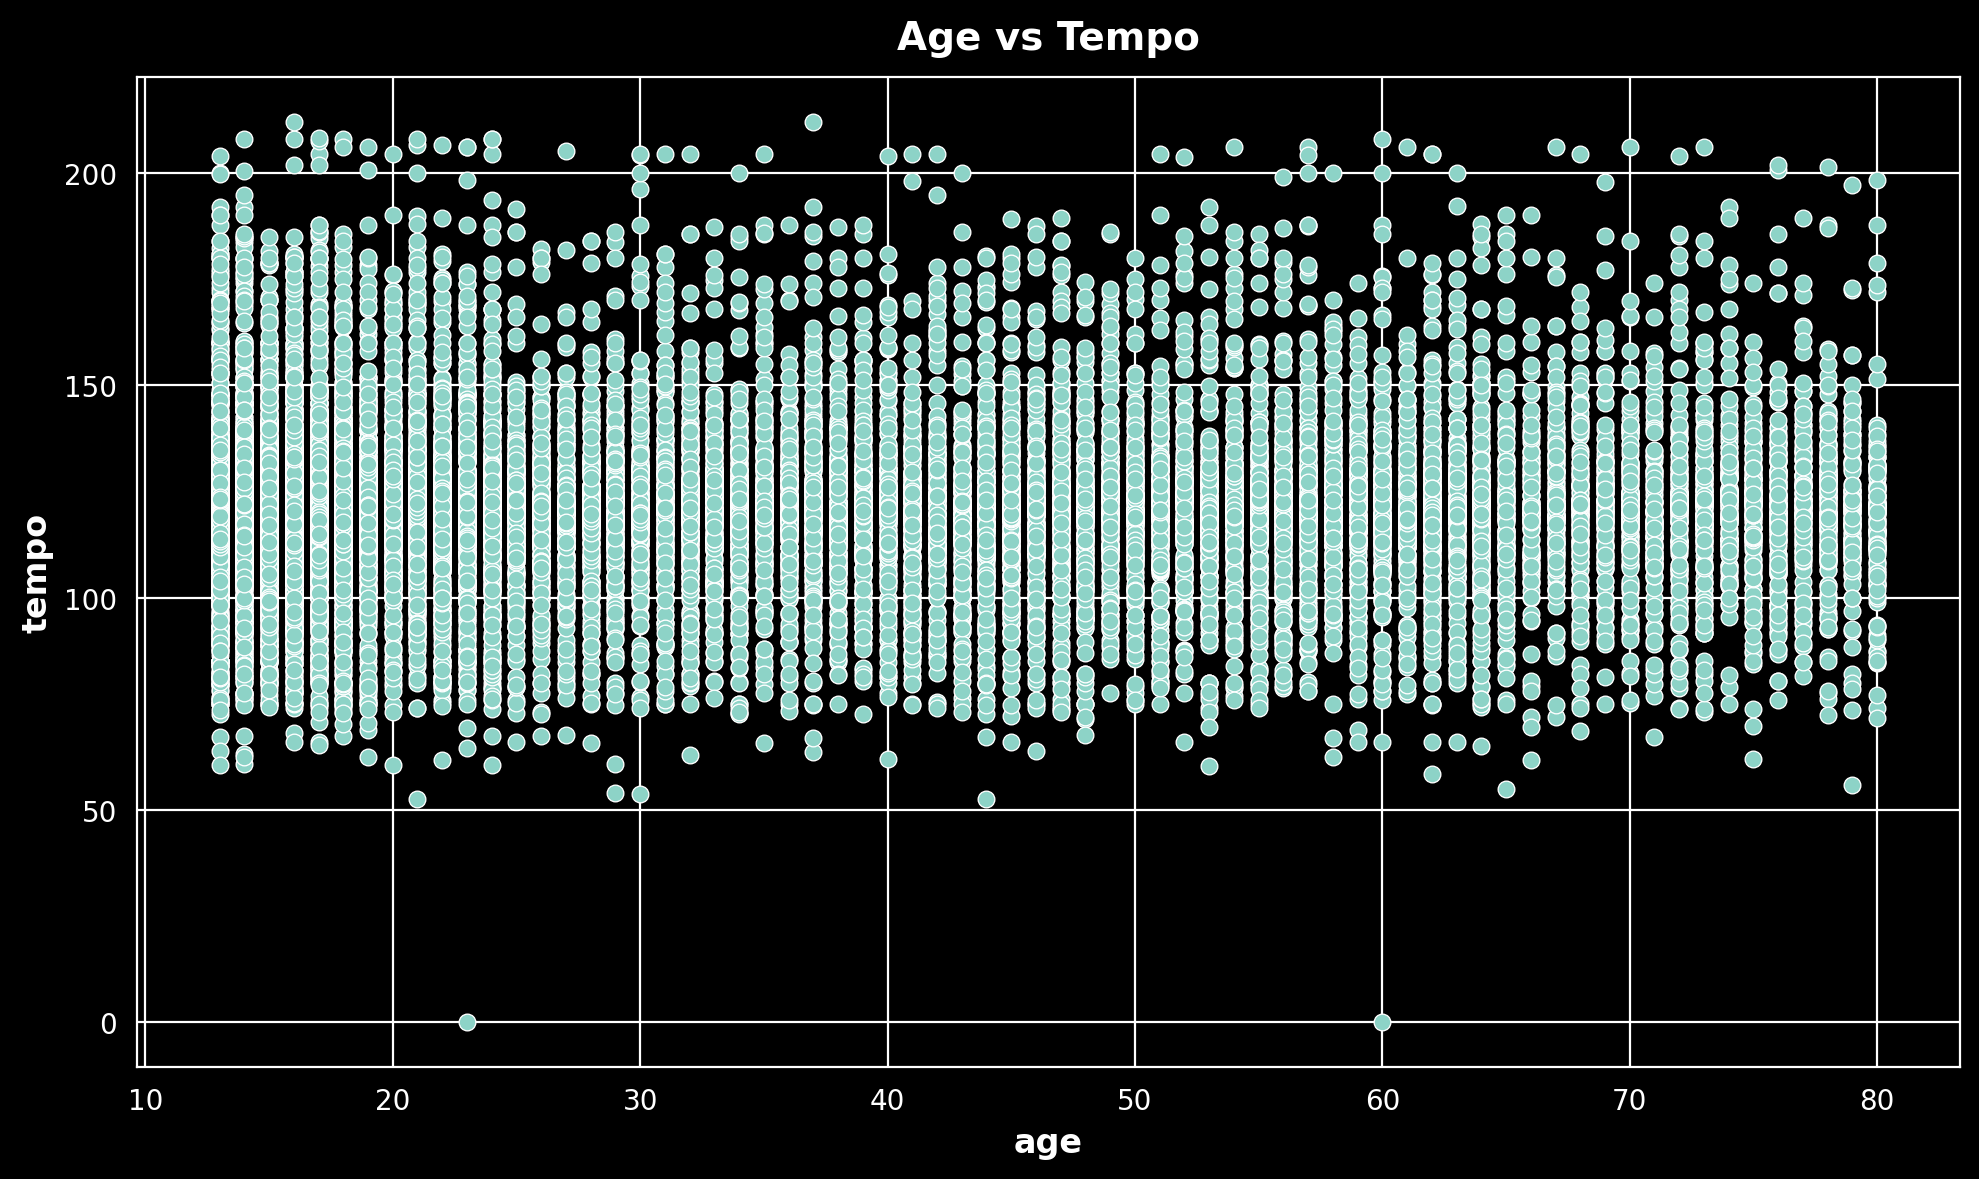

Correlation between age and tempo: 0.004


In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='tempo', data=df)
plt.title('Age vs Tempo')
plt.show()

correlation = df['age'].corr(df['tempo'])
print(f"Correlation between age and tempo: {correlation:.3f}")

## Gender and Danceability

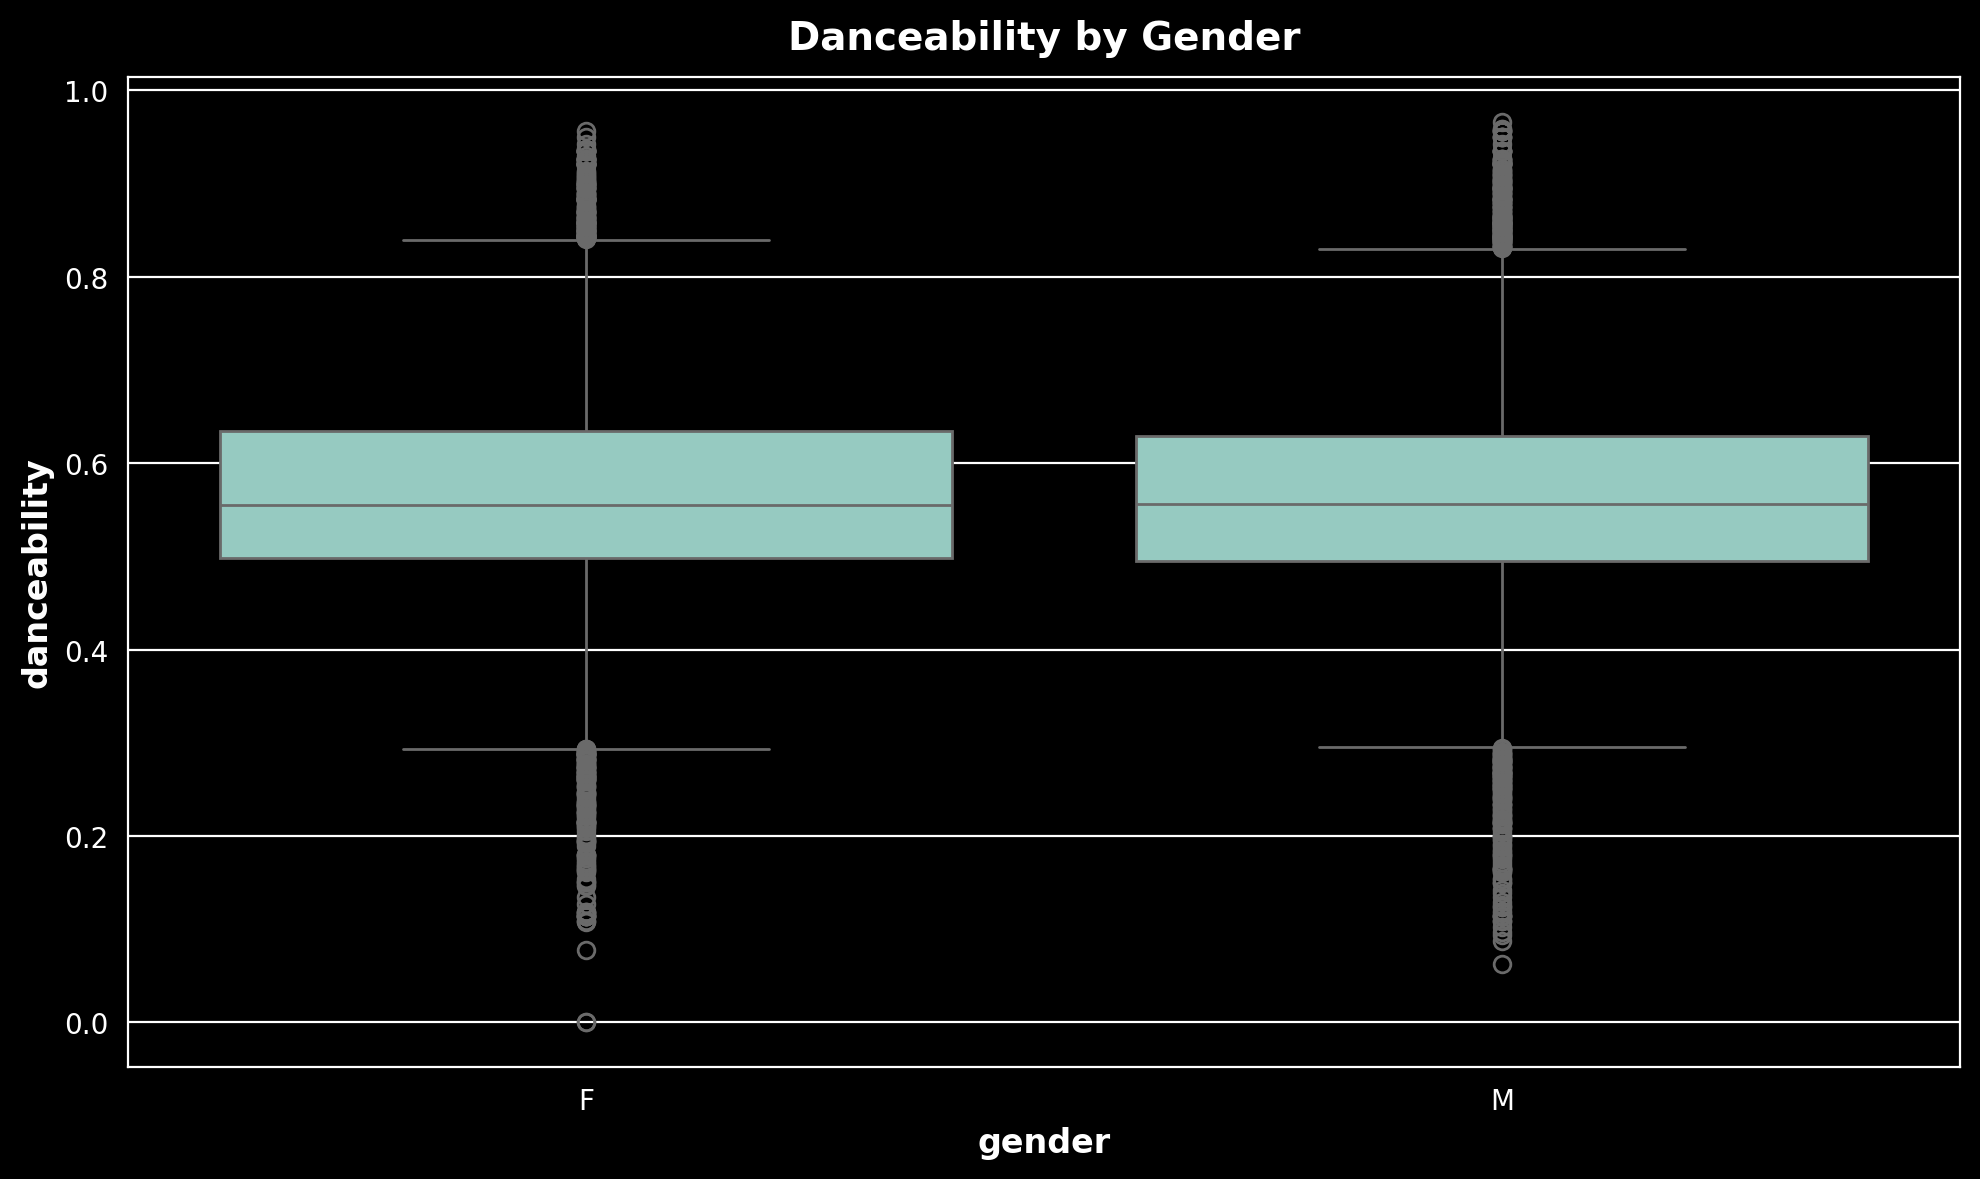

Danceability t-test:
t-statistic = -1.4190306678236608
p-value = 0.15590568087433074


In [52]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='danceability', data=df)
plt.title('Danceability by Gender')
plt.show()

t_stat, p_value = stats.ttest_ind(df[df['gender'] == 'M']['danceability'],
                                  df[df['gender'] == 'F']['danceability'])
print(f"Danceability t-test:\nt-statistic = {t_stat}\np-value = {p_value}")

# Machine Learning Prediction of User Preferences

In [53]:
df.columns

Index(['user_id', 'age', 'gender', 'music', 'artist_name', 'featured_artists',
       'genre', 'plays', 'duration', 'music_id', 'id_artists', 'acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'release_date', 'explicit', 'age_group', 'release_year'],
      dtype='object')

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Prepare df for modeling
features = ['age', 'gender', 'danceability', 'energy']
X = pd.get_dummies(df[features], drop_first=True)
y = df['genre']

# Split df into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 0.15544430538172715
Classification Report:
                  precision    recall  f1-score   support

           Blues       0.08      0.08      0.08        96
Christian/Gospel       0.19      0.26      0.22        96
       Classical       0.16      0.20      0.18       471
         Country       0.02      0.02      0.02       155
Dance/Electronic       0.13      0.12      0.13       392
       Dark Trap       0.52      0.42      0.46        31
  Easy Listening       0.11      0.09      0.10        91
             Emo       0.28      0.18      0.22       148
   Folk/Acoustic       0.14      0.10      0.12       185
         Hip-Hop       0.18      0.19      0.18       431
            Jazz       0.11      0.11      0.11       292
           Metal       0.06      0.05      0.06        56
           Other       0.20      0.33      0.25         3
             Pop       0.15      0.17      0.16       168
            Punk       0.09      0.07      0.08        30
             Rap  

# Tensorflow recommenders

In [55]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


NameError: name 'tf' is not defined

In [58]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
tf.random.set_seed(42)
print(tf.__version__)
TF_ENABLE_ONEDNN_OPTS=0

2.15.1


In [59]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [60]:
# Split the data
data = df.drop(columns=['release_date']).dropna(axis = 0).copy()

In [61]:
data.isnull().sum().sum()

0

In [62]:
# Ensure all columns have consistent data types
data['user_id'] = data['user_id'].astype(str)
data['music_id'] = data['music_id'].astype(str)
data['age'] = data['age'].astype(int)
data['duration'] = data['duration'].astype(float)
data['acousticness'] = data['acousticness'].astype(float)
data['danceability'] = data['danceability'].astype(float)
data['energy'] = data['energy'].astype(float)
data['key'] = data['key'].astype(int)
data['loudness'] = data['loudness'].astype(float)
data['mode'] = data['mode'].astype(int)
data['speechiness'] = data['speechiness'].astype(float)
data['instrumentalness'] = data['instrumentalness'].astype(float)
data['liveness'] = data['liveness'].astype(float)
data['valence'] = data['valence'].astype(float)
data['tempo'] = data['tempo'].astype(float)
data['time_signature'] = data['time_signature'].astype(float)
data['explicit'] = data['explicit'].astype(bool)

In [63]:
data['music_id'].value_counts()

music_id
7BKLCZ1jbUBVqRi2FVlTVw    33
7yq4Qj7cqayVTp3FF9CWbm    31
3a1lNhkSLSkpJE4MSHpDu9    31
152lZdxL1OR0ZMW6KquMif    27
1xznGGDReH1oQq0xzbwXa3    22
                          ..
7pWcjb71SqY2256QasmAhJ     1
5Yj5pG9BPF6p77d7BRF2bL     1
4AyDzfSssIVPriQXxoXCVq     1
1zxVazSCSoclwCJy7dmDGZ     1
3zTqNXUMKnaU4hBJbheSxy     1
Name: count, Length: 8271, dtype: int64

## Collaborative Filtering

In [64]:
df.columns

Index(['user_id', 'age', 'gender', 'music', 'artist_name', 'featured_artists',
       'genre', 'plays', 'duration', 'music_id', 'id_artists', 'acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'release_date', 'explicit', 'age_group', 'release_year'],
      dtype='object')

In [65]:
df['explicit'].unique()

array([ True, False])

## Collaborative Filtering

In [66]:
data.select_dtypes(include = 'number').columns

Index(['age', 'plays', 'duration', 'acousticness', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'release_year'],
      dtype='object')

In [67]:
data.select_dtypes(include = np.number).columns.tolist()

['age',
 'plays',
 'duration',
 'acousticness',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'release_year']

In [68]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import DenseFeatures

# Encode categorical features
label_encoders = {}

categorical_features = data.select_dtypes(include = ['category', 'object']).columns.tolist()
numerical_features = data.select_dtypes(include = np.number).columns.tolist()

for feature in categorical_features:
    le = LabelEncoder()
    data[feature] = le.fit_transform(data[feature])
    label_encoders[feature] = le

# Define feature columns
feature_columns = []

# Categorical feature columns
for feature in categorical_features:
    vocab = data[feature].unique()
    feature_columns.append(tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_vocabulary_list(feature, vocab), dimension=32))

# Numerical feature columns
for feature in numerical_features:
    feature_columns.append(tf.feature_column.numeric_column(feature, normalizer_fn=lambda x: x))

# Create the input function
def make_input_fn(data_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices(dict(data_df))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(data_df))
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(data)


Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [69]:
import tensorflow_recommenders as tfrs
from tensorflow.keras import layers

class MusicRecommenderModel(tfrs.Model):
    def __init__(self):
        super().__init__()

        # Define embedding and dense layers
        self.embedding_layers = tf.keras.layers.DenseFeatures(feature_columns)
        self.dense_layers = tf.keras.Sequential([
            layers.BatchNormalization(),
            layers.Dense(256, activation="relu"),
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            layers.Dense(128, activation = "relu"),
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            layers.Dense(64, activation="relu"),
            layers.Dense(1)  # Output layer
        ])

        # Task
        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, features):
        embeddings = self.embedding_layers(features)
        return self.dense_layers(embeddings)

    def compute_loss(self, features, training=False):
        labels = features["valence"]  # Example of using 'valence' as a proxy target
        predictions = self(features)
        return self.task(labels=labels, predictions=predictions)


In [70]:
# Create and train the model
model = MusicRecommenderModel()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

stop_early = tf.keras.callbacks.EarlyStopping(
    min_delta=0.00001,
    patience=10,
    restore_best_weights=True
)

# Create a TensorFlow dataset
train_input_fn = make_input_fn(data)
train_ds = train_input_fn()

# Create a Validation dataset
valid_input_fn = make_input_fn(data, num_epochs=1, shuffle=False)
valid_ds = valid_input_fn()


2024-07-20 01:02:53.043204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 01:02:53.043399: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 01:02:53.043435: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 01:02:53.230545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-20 01:02:53.230699: I external/local_xla/xla/stream_executor

In [71]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [72]:
#train the model on GPU
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        epochs=10,
        callbacks=[stop_early],
        validation_data=valid_ds
    )

Epoch 1/10


2024-07-20 01:03:09.975154: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc63ab67af0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-20 01:03:09.975248: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-07-20 01:03:09.997843: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-20 01:03:10.043215: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1721437390.135572    9448 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4580/4580 [==============================] - 212s 45ms/step - root_mean_squared_error: 3.0959 - loss: 9.5759 - regularization_loss: 0.0000e+00 - total_loss: 9.5759 - val_root_mean_squared_error: 0.2141 - val_loss: 0.0459 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0459
Epoch 2/10
4580/4580 [==============================] - 174s 38ms/step - root_mean_squared_error: 0.4372 - loss: 0.1911 - regularization_loss: 0.0000e+00 - total_loss: 0.1911 - val_root_mean_squared_error: 0.0885 - val_loss: 0.0103 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0103
Epoch 3/10
4580/4580 [==============================] - 173s 38ms/step - root_mean_squared_error: 0.5070 - loss: 0.2568 - regularization_loss: 0.0000e+00 - total_loss: 0.2568 - val_root_mean_squared_error: 0.1950 - val_loss: 0.0347 - val_regularization_loss: 0.0000e+00 - val_total_loss: 0.0347
Epoch 4/10
4580/4580 [==============================] - 173s 38ms/step - root_mean_squared_error: 0.1304 - loss: 0.0170 - regu

In [73]:
history_df = pd.DataFrame(history.history)
history_df.head(10)

root_mean_squared_error      loss  regularization_loss  total_loss  \
0                 3.095874  0.056505                    0    0.056505   
1                 0.437202  0.013417                    0    0.013417   
2                 0.506968  0.021299                    0    0.021299   
3                 0.130443  0.001136                    0    0.001136   
4                 0.053459  0.000838                    0    0.000838   
5                 0.081727  0.001745                    0    0.001745   
6                 0.022290  0.000147                    0    0.000147   
7                 0.016414  0.000176                    0    0.000176   
8                 0.011996  0.000853                    0    0.000853   
9                 0.012008  0.000029                    0    0.000029   

   val_root_mean_squared_error  val_loss  val_regularization_loss  \
0                     0.214130  0.045875                        0   
1                     0.088498  0.010276                        0   
2                     0.195019  0.034668                        0   
3                     0.060897  0.004035                        0   
4                     0.030076  0.000866                        0   
5                     0.027466  0.000860                        0   
6                     0.023426  0.000650                        0   
7                     0.016696  0.000253                        0   
8                     0.012844  0.000127                        0   
9                     0.006854  0.000031                        0   

   val_total_loss  
0        0.045875  
1        0.010276  
2        0.034668  
3        0.004035  
4        0.000866  
5        0.000860  
6        0.000650  
7        0.000253  
8        0.000127  
9        0.000031

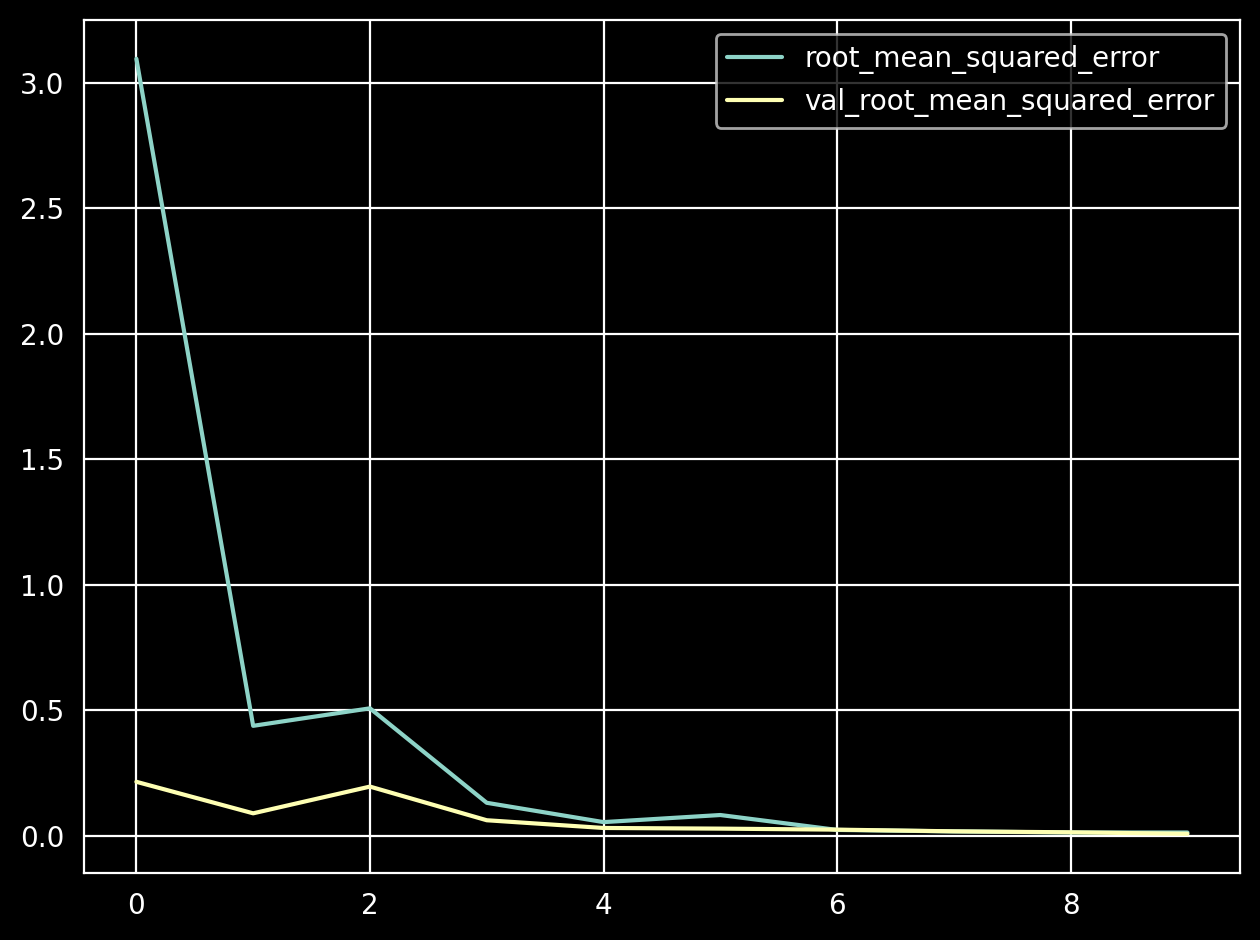

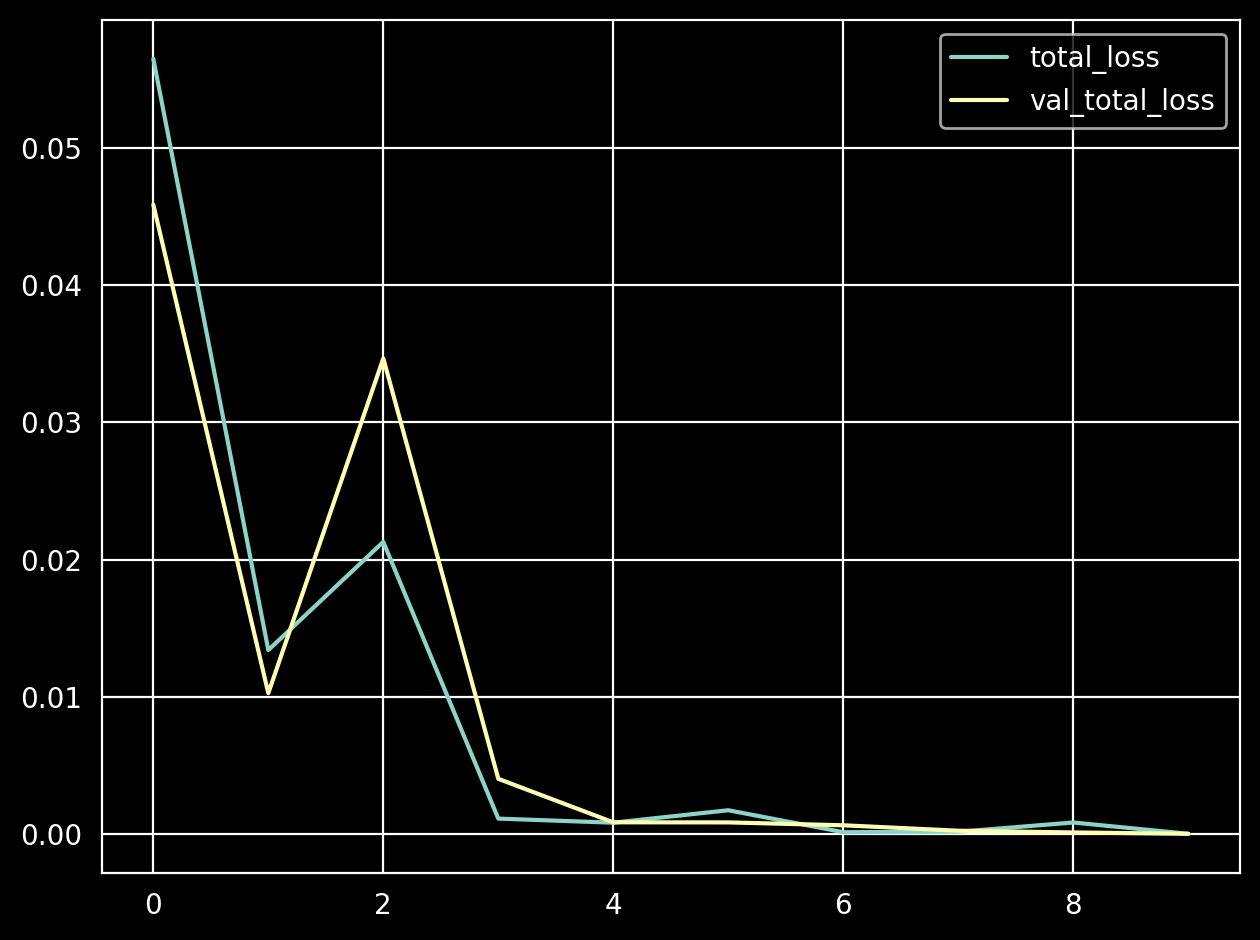

In [74]:
history_df.loc[:, ['root_mean_squared_error', 'val_root_mean_squared_error']].plot()
history_df.loc[:, ['total_loss', 'val_total_loss']].plot();


In [75]:
print('Best RMS value: {:.4f}'.format(history_df['val_root_mean_squared_error'].min()))
print('Best loss: {}'.format(history_df['val_total_loss'].min()))

Best RMS value: 0.0069
Best loss: 3.099600871792063e-05


In [76]:
for key, val in df[df['music'] == 'Summer - Diplo & Grandtheft Remix'].to_dict().items():
    print(f'{key}: {val.values()}')

user_id: dict_values([32541])
age: dict_values([32])
gender: dict_values(['M'])
music: dict_values(['Summer - Diplo & Grandtheft Remix'])
artist_name: dict_values(['Calvin Harris'])
featured_artists: dict_values(['Luciano, Tungevaag, The Killers, Ghostemane'])
genre: dict_values(['Classical'])
plays: dict_values([1])
duration: dict_values([4.45])
music_id: dict_values(['6zonhXHUitdQqZTqylx7Jf'])
id_artists: dict_values(['spotify:artist:7CajNmpbOovFoOoasH2HaY'])
acousticness: dict_values([0.00389])
danceability: dict_values([0.731])
energy: dict_values([0.96])
key: dict_values([11])
loudness: dict_values([-4.453])
mode: dict_values([0])
speechiness: dict_values([0.0714])
instrumentalness: dict_values([0.0322])
liveness: dict_values([0.00936])
valence: dict_values([0.61])
tempo: dict_values([140.014])
time_signature: dict_values([4.0])
release_date: dict_values([Timestamp('2014-06-20 00:00:00')])
explicit: dict_values([False])
age_group: dict_values(['Millenials'])
release_year: dict_val

In [77]:
data.columns

Index(['user_id', 'age', 'gender', 'music', 'artist_name', 'featured_artists',
       'genre', 'plays', 'duration', 'music_id', 'id_artists', 'acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'explicit', 'age_group', 'release_year'],
      dtype='object')

In [78]:
data.select_dtypes(include = ['category', 'object']).columns.tolist()

[]

In [79]:
user_input = {
    'user_id': [label_encoders['user_id'].transform(['32541'])[0]],
    'age': [32],
    'gender': [label_encoders['gender'].transform(['M'])[0]],
    'music': ['Summer - Diplo & Grandtheft Remix'],
    'artist_name': ['Calvin Harris'],
    'featured_artists': ['Luciano, Tungevaag, The Killers, Ghostemane'],
    'genre': ['Classical'],
    'duration': [4.45],
    'music_id': [label_encoders['music_id'].transform(['6zonhXHUitdQqZTqylx7Jf'])[0]],
    'id_artists': ['spotify:artist:7CajNmpbOovFoOoasH2HaY'],
    'acousticness': [0.0038],
    'danceability': [0.73],
    'energy': [0.9],
    'key': [11],
    'loudness': [-4.4],
    'mode': [0],
    'speechiness': [0.05],
    'instrumentalness': [0.0322],
    'liveness': [0.01],
    'valence': [0.61],
    'tempo': [140],
    'time_signature': [4],
    'explicit': [label_encoders['explicit'].transform(['True'])[0]]
}

user_input_ds = tf.data.Dataset.from_tensor_slices(user_input).batch(1)

predictions = model.predict(user_input_ds)
print(predictions)

KeyError: 'explicit'

In [ ]:
df.tail()

user_id  age gender            music        artist_name  \
6919    40385   23      F        Holy Shit  Father John Misty   
6920    40385   23      F       White Room              Cream   
6921    84462   62      M  Better Together       Jack Johnson   
6922    84462   62      M          Forever              Drake   
6923      229   36      F       Come Clean        Hilary Duff   

                   featured_artists             genre  duration  \
6919                           None               Pop      4.02   
6920                           None               RnB      5.05   
6921   Luke Combs, The Chainsmokers              Jazz      3.46   
6922  Fall Out Boy, Paramore, Sting           Hip-Hop      5.96   
6923                           None  Dance/Electronic      3.58   

                    music_id                             id_artists  ...  \
6919  18y3XgYPJJqMJVSm0tMgRa  spotify:artist:2kGBy2WHvF0VdZyqiVCkDT  ...   
6920  5X76oXHcR5uCXali0gOyX5  spotify:artist:74oJ4qxwOZvX6oSsu1DGnw  ...   
6921  2iXdwVdzA0KrI2Q0iZNJbX  spotify:artist:3GBPw9NK25X1Wt2OUvOwY3  ...   
6922  31Q9ZTF9x81BDonlObCbvP  spotify:artist:3TVXtAsR1Inumwj472S9r4  ...   
6923  2TZ1apxMDlubCGMsOxcTbT  spotify:artist:2S9W9aSAd7e5mp8WqWxN2h  ...   

      loudness  mode  speechiness  instrumentalness  liveness   valence  \
6919 -6.486000   1.0     0.173350          0.001645  0.186100  0.529500   
6920 -7.474231   1.0     0.047023          0.068571  0.276354  0.384462   
6921 -8.764333   1.0     0.071511          0.104111  0.111922  0.547556   
6922 -8.533343   1.0     0.074670          0.182938  0.199521  0.388387   
6923 -7.434444   1.0     0.052700          0.071019  0.125578  0.471811   

           tempo  time_signature  release_date  explicit  
6919  134.644000             4.0    2017-01-13     False  
6920  120.015462             4.0    1999-10-05     False  
6921  121.935556             4.0          1978     False  
6922  121.365924             4.0    1973-10-15     False  
6923  117.551444             4.0    1997-06-17     False  

[5 rows x 24 columns]

In [ ]:
track_list = [
    {
        'music': 'Summer - Diplo & Grandtheft Remix',
        'artist_name': 'Calvin Harris',
        'featured_artists': 'Luciano, Tungevaag, The Killers, Ghostemane',
        'genre': 'Classical',
        'duration': 4.42,
        'music_id': '6zonhXHUitdQqZTqylx7Jf',
        'id_artists': 'spotify:artist:7CajNmpbOovFoOoasH2HaY',
        'acousticness': 0.0038,
        'danceability': 0.73,
        'energy': 0.9,
        'key': 11,
        'loudness': -4.4,
        'mode': 0,
        'speechiness': 0.05,
        'instrumentalness': 0.0322,
        'liveness': 0.01,
        'valence': 0.61,
        'tempo': 140,
        'time_signature': 4,
        'explicit': 'True'
    },
    {
        'music': 'Holy Shit',
        'artist_name': 'Father John Misty',
        'featured_artists': None,
        'genre': 'Pop',
        'duration': 4.02,
        'music_id': '18y3XgYPJJqMJVSm0tMgRa',
        'id_artists': 'spotify:artist:2kGBy2WHvF0VdZyqiVCkDT',
        'acousticness': 0.1,
        'danceability': 0.9,
        'energy': 0.9,
        'key': 7,
        'loudness': -3.5,
        'mode': 0,
        'speechiness': 0.05,
        'instrumentalness': 0.1,
        'liveness': 0.3,
        'valence': 0.8,
        'tempo': 130.0,
        'time_signature': 4,
        'explicit': 'False'
    }
]

# Prepare the input data similar to how you did for a single prediction
input_data = {
    'user_id': [label_encoders['user_id'].transform(['32541'])[0]] * len(track_list),
    'age': [32] * len(track_list),
    'gender': [label_encoders['gender'].transform(['M'])[0]] * len(track_list),
    'music': [track['music'] for track in track_list],
    'artist_name': [track['artist_name'] for track in track_list],
    'genre': [track['genre'] for track in track_list],
    'duration': [track['duration'] for track in track_list],
    'featured_artists': [track['featured_artists'] for track in track_list],
    'music_id': [label_encoders['music_id'].transform([track['music_id']])[0] for track in track_list],
    'id_artists': [track['id_artists'] for track in track_list],
    'acousticness': [track['acousticness'] for track in track_list],
    'danceability': [track['danceability'] for track in track_list],
    'energy': [track['energy'] for track in track_list],
    'key': [track['key'] for track in track_list],
    'loudness': [track['loudness'] for track in track_list],
    'mode': [track['mode'] for track in track_list],
    'speechiness': [track['speechiness'] for track in track_list],
    'instrumentalness': [track['instrumentalness'] for track in track_list],
    'liveness': [track['liveness'] for track in track_list],
    'valence': [track['valence'] for track in track_list],
    'tempo': [track['tempo'] for track in track_list],
    'time_signature': [track['time_signature'] for track in track_list],
    'explicit': [label_encoders['explicit'].transform([track['explicit']])[0] for track in track_list]
}


# Create a dataset from the input data
input_data_ds = tf.data.Dataset.from_tensor_slices(input_data).batch(1)

# Predict scores for the input data
predictions = model.predict(input_data_ds)

# Get the top-N recommendations
top_N = 2
top_N_indices = predictions.flatten().argsort()[-top_N:][::-1]

# Print the top-N recommended tracks
recommended_tracks = [track_list[i] for i in top_N_indices]
for track in recommended_tracks:
    print(track)

ValueError: Can't convert Python sequence with mixed types to Tensor.

In [ ]:
data.columns

Index(['user_id', 'age', 'gender', 'music', 'artist_name', 'featured_artists',
       'genre', 'duration', 'music_id', 'id_artists', 'acousticness',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'explicit'],
      dtype='object')

In [ ]:
categorical_features = ['user_id', 'gender', 'music_id', 'explicit']
numerical_features = ['age', 'duration', 'acousticness', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature']
